 # DOGGO GAN CLASSIFICATOR

## Import

In [0]:

#!pip show tqdm
import os
import os.path
import sys
from skimage import io
import shutil
import logging
import pandas as pd
import numpy as np
from datetime import datetime
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
from torch.backends import cudnn
from torch.nn.utils import spectral_norm
from torch.autograd import Variable

import torchvision
from torchvision import transforms
from torchvision.models import alexnet, vgg11_bn, squeezenet1_0, densenet121, inception_v3
from torchvision.datasets import VisionDataset
import torchvision.utils as vutils
from torchvision.utils import save_image

from PIL import Image
import tqdm

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import imshow
from copy import deepcopy
import time
import xml.etree.ElementTree as ET

# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)


## Download datasets from Github (or local..)

In [2]:
# Clone github repository with data
if os.path.isdir('dataset'):
    root_dir='./'
else:
    root_dir='./doggo_gan/'
    # Clone github repository with data
    if not os.path.isdir('./doggo_gan'):
      !git clone 'https://gitlab.com/isnob46/doggo_gan.git'


Cloning into 'doggo_gan'...
remote: Enumerating objects: 71693, done.
remote: Counting objects: 100% (71693/71693), done.
remote: Compressing objects: 100% (51417/51417), done.
remote: Total 71693 (delta 20294), reused 71609 (delta 20271), pack-reused 0
Receiving objects: 100% (71693/71693), 5.03 GiB | 36.65 MiB/s, done.
Resolving deltas: 100% (20294/20294), done.
Checking out files: 100% (91954/91954), done.


In [0]:
DEVICE = 'cuda' 
def donetime(start=None):
  if start != None:
    if ((time.time() - start)/60) < 60:
      print('DONE (time {:4.2f} m)'.format((time.time() - start)/60))
    else:
      print('DONE (time {:4.2f} h)'.format((time.time() - start)/3600))
  else:
    print('\nDONE')
  return

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


def show_batch_images(dataset,batch_size,title=''):
  fig, axs = plt.subplots(1, batch_size,figsize=(15, 3), dpi=80, facecolor='white')
  for i in range(batch_size):
    n=randint(0,len(dataset))
    im,label=dataset[n]
    unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    im=unorm(im)
    axs[i].imshow(im.permute(1,2,0))
    axs[i].set_title(list(dataset.class_to_idx.keys())[label] )
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()

def show_grid_samples(dataset,title='dataset samples',size=32):
    # visualization batch image
    images=[]
    for i in range(size):
      n=randint(0,len(dataset))
      im,label=dataset[n]
      images.append(im)
    plt.figure(figsize=(20,20))
    plt.axis("off")
    plt.title(title)
    image = np.transpose(vutils.make_grid(images, normalize=True).cpu(),axes=(1,2,0))
    plt.imshow(image)
    plt.show()

## Transforms

In [0]:
# This is the old transform. New ones should look like the ones below.

random_transforms = [transforms.ColorJitter()]
gan_transform = transforms.Compose([transforms.Resize(256),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3),
                                 transforms.CenterCrop(224), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation of ImageNet
])

test_transform = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation of ImageNet
])



## Load datasets

-----------------------------------STOCK DATASET-----------------------------------
Stock Dataset loaded: 20580
Stock Dataset classes: 120


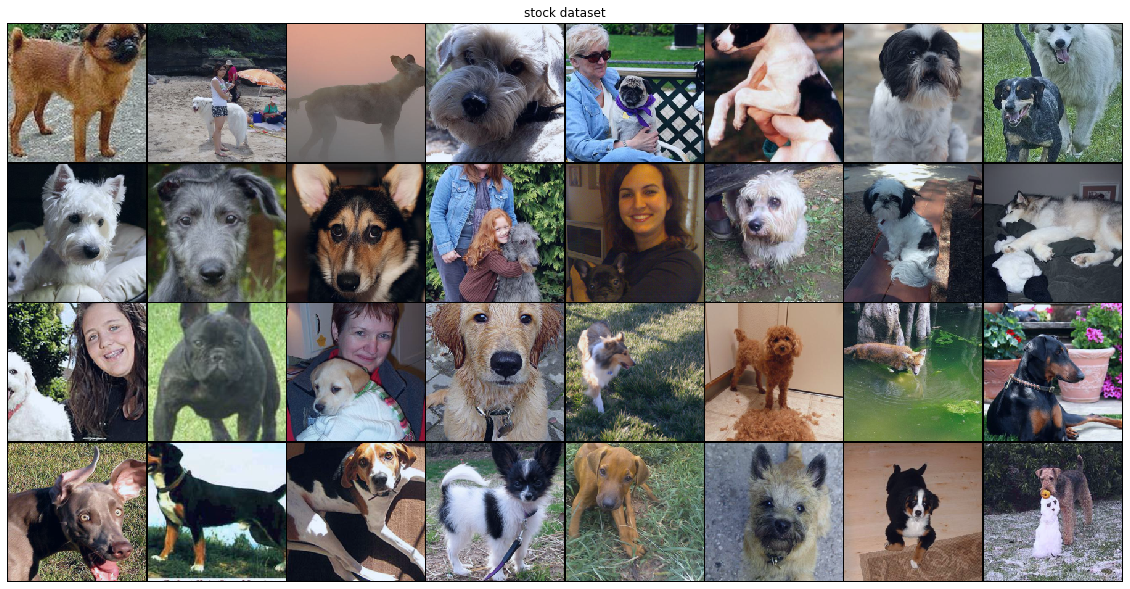

-----------------------------------GENERATED DATASET-----------------------------------
Generated Dataset loaded: 30000
Generated Dataset classes: 120


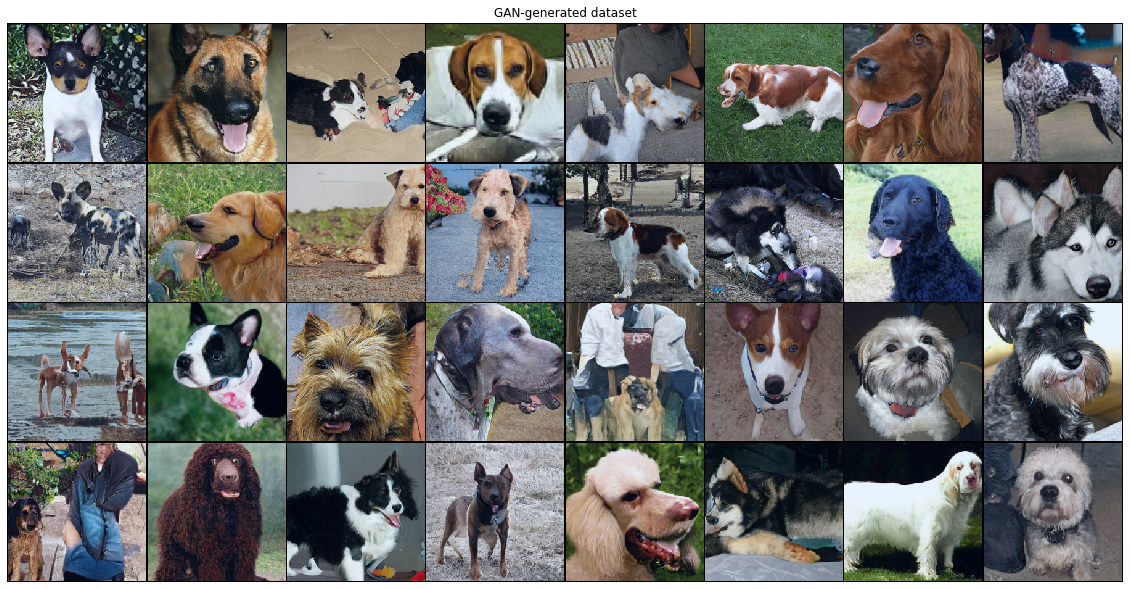

In [7]:
DEVICE = 'cuda' 
NUM_CLASSES = 120
BATCH_SIZE = 256 
stock_dir='dataset_clean/images'
generated_dir='dataset_augmentated/images'
dataset_stock = torchvision.datasets.ImageFolder(
    root_dir+stock_dir,
    transform=gan_transform
)

dataset_generated = torchvision.datasets.ImageFolder(
    root_dir+generated_dir,
    transform=gan_transform
)

print('-----------------------------------STOCK DATASET-----------------------------------')
print('Stock Dataset loaded:',len(dataset_stock))
print('Stock Dataset classes:',len(dataset_stock.classes))
show_grid_samples(dataset_stock,title='stock dataset')

print('-----------------------------------GENERATED DATASET-----------------------------------')
print('Generated Dataset loaded:',len(dataset_generated))
print('Generated Dataset classes:',len(dataset_generated.classes))
show_grid_samples(dataset_generated,title='GAN-generated dataset')

## Split dataset (train and test and val) and then concatenate with augmented dataset

Manual seed 42
----------split dataset stock (train,test,val)---------
Train (stock dataset):  16464  /  20580 loaded ->  80.0 % of stock Dataset
Test (stock dataset):  4116  /  20580 loaded ->  20.0 % of stock Dataset
----------augment dataset---------
Train (augmented dataset):  23664  /  16464 loaded -> 143.73 % of train Dataset


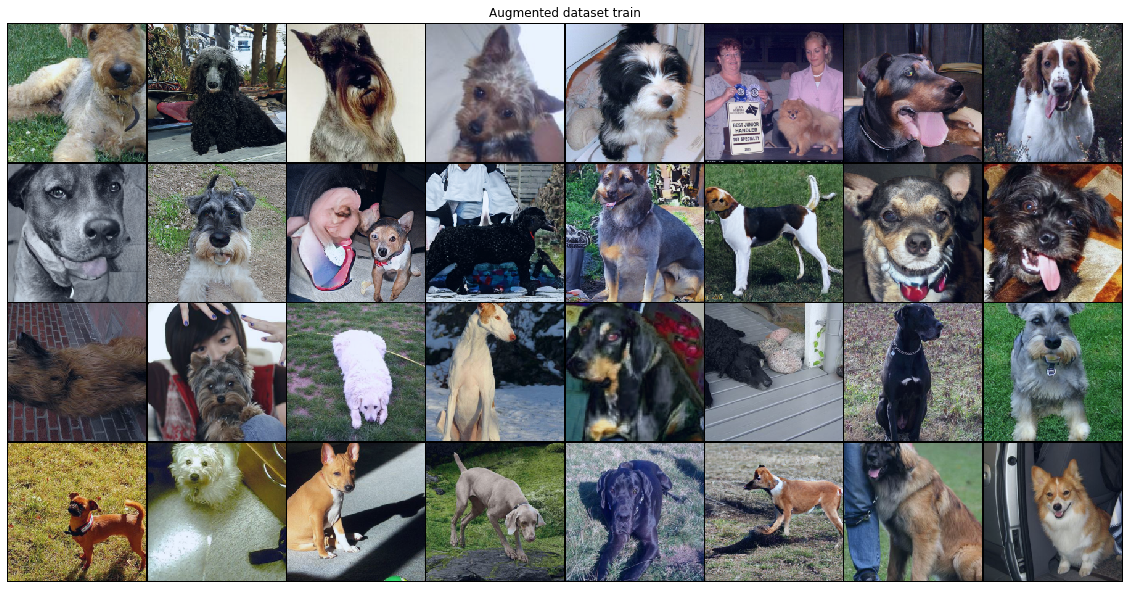

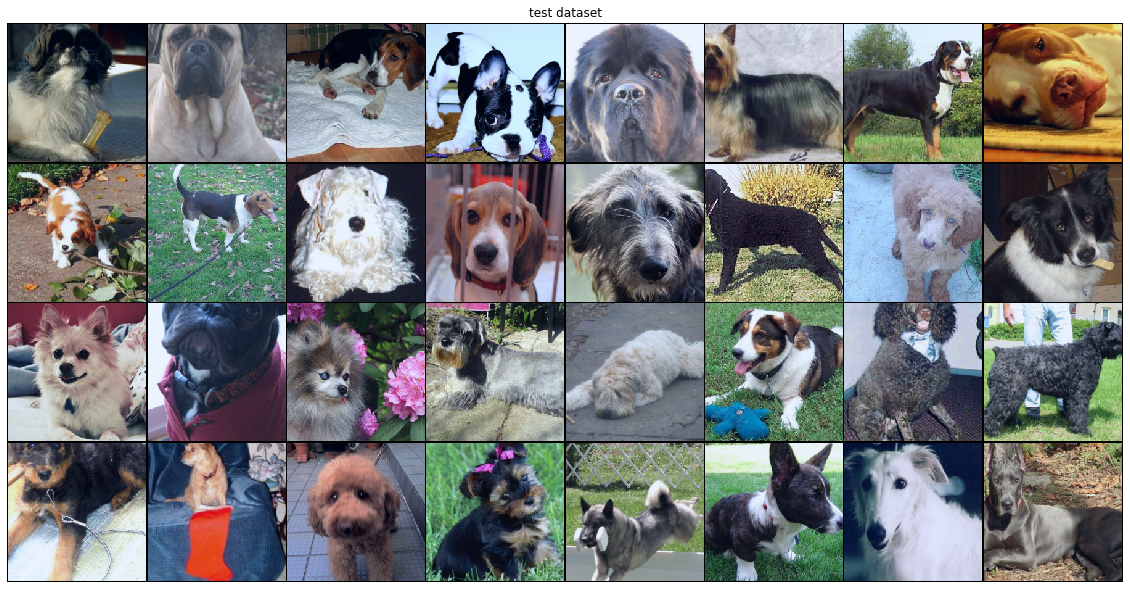

In [8]:
AUG_PERCENTAGE=1

#Split the dataset in traning, validation and test 
torch.manual_seed(42) #manual seed for random (reproducible) test set generator
print('Manual seed',torch.initial_seed())
size = len(dataset_stock)

test_size = int(np.trunc(0.2*size))
#val_size=test_size
#train_size = size - test_size - val_size
train_size = size - test_size

#train_dataset_stock, test_dataset , validation_dataset = torch.utils.data.random_split(dataset_stock, [train_size, test_size,val_size])
train_dataset_stock, test_dataset  = torch.utils.data.random_split(dataset_stock, [train_size, test_size])
#reduce dataset augmented
'''AUG_SIZE=int(AUG_PERCENTAGE*len(dataset_generated))
dataset_aug,_  = torch.utils.data.random_split(dataset_generated, [AUG_SIZE,int(len(dataset_generated)-AUG_SIZE)])'''

# these are the class performed better in ALEXNET(100%),so we augment only this classess
class_to_augment= [1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 
                   1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
                   1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
                   0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0]
idxs=[]
MAX_VAL=int(AUG_PERCENTAGE*120)
for clas in range(120):
  if(class_to_augment[clas]==1):
    for i in range(MAX_VAL):
      idxs.append(clas*250+i)

dataset_aug  = torch.utils.data.Subset(dataset_generated, idxs)

#concat stock and augmented datasets
train_dataset_augmented = torch.utils.data.ConcatDataset([train_dataset_stock, dataset_aug])



print('----------split dataset stock (train,test,val)---------')
print("Train (stock dataset): ", len(train_dataset_stock) ," / ", len(dataset_stock), "loaded -> ", 100*(train_size/size), "% of stock Dataset")
print("Test (stock dataset): ", len(test_dataset)," / ", len(dataset_stock), "loaded -> ", 100*(test_size/size), "% of stock Dataset")
#print("Validation (stock dataset): ", len(validation_dataset)," / ", len(dataset_stock), "loaded -> ", 100*(val_size/size), "% of stock Dataset")
print('----------augment dataset---------')

print("Train (augmented dataset): ", len(train_dataset_augmented) ," / ", len(train_dataset_stock), "loaded -> {:.2f} % of train Dataset".format(100*(len(train_dataset_augmented) /len(train_dataset_stock))))

test_dataset.dataset.transform = test_transform # apply test transform (no random transforms)

show_grid_samples(train_dataset_augmented,title='Augmented dataset train')
show_grid_samples(test_dataset,title='test dataset')


## Train functions

In [0]:
#Arrays used to compute stats
times = [] #All training times will be appended here
test_time = []  #All test times will be appended here
model_accuracy = [] #All final accuracy value 
accuracy = [] #All the accuracy values
lost = [] #All the loss values

def graph_train(NUM_EPOCHS, title=''):

  #This is a utility function used to plot the results
  #of the last NUM_EPOCHS loss and accuracy values 
  #i.e. the last training's results
  fig, (ax1, ax2) = plt.subplots(1,2,facecolor='white')
  ax1.set_title("Loss")
  ax2.set_title("Accuracy")
  if title != '':
    fig.suptitle(title + "\n", fontsize=12)
  ax1.plot(lost[-NUM_EPOCHS:], 'bo-')
  ax2.plot(accuracy[-NUM_EPOCHS:], 'bo-')
  ax1.grid(True)
  ax2.grid(True)
  ax1.set(xlabel ="Epoch", ylabel = "Loss")
  ax2.set(xlabel ="Epoch", ylabel = "Accuracy")
  plt.tight_layout()
  plt.show()
def plot_loss(losses, epoch,title='Loss graph',):
    plt.figure(figsize=(10,5),facecolor='white')
    plt.title( title +' epochs: ' + str(epoch))
    plt.plot(losses)
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

def plot_barh(class_accuracy):
  plt.figure(figsize=(10,22),facecolor='white')
  plt.title("Accuracy for each class")
  plt.grid()
  plt.barh(list(class_accuracy.keys()),class_accuracy.values())
  plt.show()
def plot_dual_barh(stock_acc,aug_acc,class_distribution):
  frame={}
  

  for i in range(len(stock_acc)):
    class_name=list(class_distrib.keys())[i]
    if(class_name not in frame):
      frame[class_name]={}
    frame[class_name]['acc_stock']=list(stock_acc.values())[i]
    frame[class_name]['acc_aug']=list(aug_acc.values())[i]
    frame[class_name]['size_stock']=list(class_distrib.values())[i]['stock']
    frame[class_name]['size_aug']=list(class_distrib.values())[i]['aug']
  
  data=pd.DataFrame.from_dict(frame,orient='index')
  data=data.sort_values(by=['size_stock'],ascending=False)

 

  fig, ax = plt.subplots(figsize=(10,45),facecolor='white')
  ax.set_title("Accuracy score for each class\n(dimension stock dataset)/(dimension augmented dataset)")
  idx=np.arange(len(list(stock_acc.keys())))


  labels=data.index
  new_labels=[]
  for label in labels:
    new_labels.append(label+' ({}/{})'.format(class_distribution[label]['stock'],class_distribution[label]['aug']))
  
  width = 0.4
  major_ticks = np.arange(0, 101, 10)
  minor_ticks = np.arange(0, 101, 5)

  
  ax.set_xticks(major_ticks)
  ax.set_xticks(minor_ticks, minor=True)

  # And a corresponding grid
  #ax.minor_ticks_on()
  ax.grid(which='both')
  
  ax.barh(idx,data['acc_stock'],width,label='stock')
  ax.barh(idx+width,data['acc_aug'],width,label='augmented')
  ax.set(yticks=idx + width, yticklabels=new_labels, ylim=[2*width - 1, len(idx)])

  ax.legend()
  plt.show()
  print('----------------------')
  print(frame)

def plot_dual_loss(losses_1, losses_2, epoch=20,label1='net1',label2='net2'):
    plt.figure(figsize=(10,5),facecolor='white')
    plt.title("compare Loss - EPOCH "+ str(epoch))
    plt.plot(losses_1,label=label1)
    plt.plot(losses_2,label=label2)
    plt.grid()
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
def top_k(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def perform_test(net, test_dataloader):
  #This function performs accuracy tests on a provided trained cnn (net)
  #using a given dataloader
  classes=test_dataloader.dataset.dataset.classes
  num_classes=len(classes)
  net.eval() # Set Network to evaluation mode
  running_corrects = 0
  class_correct = list(0. for i in range(num_classes))
  class_total = list(0. for i in range(num_classes))
  #tot_outputs=torch.tensor([])
  #test_start = datetime.now()                 #Used to monitor training time
  for images, labels in test_dataloader:
    
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    batch_size=labels.size(0)
    outputs = net(images)# Forward Pass
    _, preds = torch.max(outputs.data, 1)# Get predictions
    c = (preds == labels).squeeze()
    running_corrects += torch.sum(preds == labels.data).data.item()# Update Corrects
    for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
  # Calculate Accuracy
  accuracy = 100*(running_corrects / float(len(test_dataloader.dataset)))
  class_accuracy={}
  for i in range(num_classes): #accyracy for class
    class_accuracy[classes[i]]= 100 * class_correct[i] / class_total[i]

  net.train(True) # Set Network to evaluation mode
  print('Total Accuracy',accuracy)
  return accuracy,class_accuracy


def train_net(net, train_dataloader,  optimizer_name='SGD', 
              batch_size=256, learning_rate=1e-3, momentum=0.9, weight_decay=5e-5, 
              epochs_n=30, step_size=20, gamma=0.1,log_frequency=20, eps=None, rho=None, model_description=''):

  #This function trains a given network on a given train_dataloader, 
  # And plot the results. Different optimizers can be used, and optimizer parameters
  #different to the default ones can be passed if desired. 

  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  cudnn.benchmark # Calling this optimizes runtime

  #OPTIMEZER PARAMS:
  #Implementation could be improved using the param object. 
  BATCH_SIZE = batch_size      # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                               # the batch size, learning rate should change by the same factor to have comparable results
  LR = learning_rate           # The initial Learning Rate
  MOMENTUM = momentum          # Hyperparameter for SGD, keep this at 0.9 when using SGD
  WEIGHT_DECAY = weight_decay  # Regularization, you can keep this at the default
  NUM_EPOCHS = epochs_n        # Total number of training epochs (iterations over dataset)
  STEP_SIZE = step_size        # How many epochs before decreasing learning rate (if using a step-down policy)
  GAMMA = gamma                # Multiplicative factor for learning rate step-down
  LOG_FREQUENCY = log_frequency
  EPS = eps

  #Loss, opt and scheduler initialization for chosen strategy
  if(optimizer_name == 'SGD'):
    criterion = nn.CrossEntropyLoss()         
    parameters_to_optimize = net.parameters() 
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
  if(optimizer_name == 'Adam'):
    criterion = nn.CrossEntropyLoss()        
    parameters_to_optimize = net.parameters() 
    optimizer = optim.Adam(parameters_to_optimize,lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
  if(optimizer_name == 'Ada'):
    criterion = nn.CrossEntropyLoss() 
    parameters_to_optimize = net.parameters() 
    optimizer = optim.Adadelta(parameters_to_optimize,lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  current_step = 0 #scheduler steps 
  startTime = time.time() #Used to monitor training time
  losses=[]
  for epoch in range(NUM_EPOCHS): # Start iterating over the epochs
    current_step=0
    print('Epoch [{}/{}], LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
    for images, labels in train_dataloader:
      images = images.to(DEVICE)        # Bring data over the device of choice
      labels = labels.to(DEVICE)        # Bring data over the device of choice

      net.train()                       # Sets module in training mode
      optimizer.zero_grad()             # Zero-ing the gradients
      
      outputs = net(images)             # Forward pass to the network
      loss = criterion(outputs, labels) # Compute loss based on output and ground truth
      
      # Compute gradients for each layer and update weights
      loss.backward()                   # backward pass: computes gradients
      
      '''if current_step % log_frequency == 0:
        print('\t [{}/{}] loss:{:.3f}'.format(current_step,len(train_dataloader),loss.item()))'''
      optimizer.step()                  # update weights based on accumulated gradients    
      current_step += 1
    losses.append(loss.item())
    # Step the scheduler
    scheduler.step()

  plot_loss(losses,NUM_EPOCHS,title=model_description)
  donetime(startTime)
  return losses

In [0]:
def class_distribution():
  
  class_to_idx=train_dataset_stock.dataset.class_to_idx
  tmp=np.zeros(len(class_to_idx),dtype=int)
  for data in train_dataset_stock:
    tmp[data[1]]+=1

  obj={}
  for lab,idx in class_to_idx.items():
    if lab not in obj:
      obj[lab]={'stock':0,'aug':0}
    obj[lab]['stock']=tmp[idx]

  
  tmp=np.zeros(len(class_to_idx),dtype=int)
  for data in train_dataset_augmented:
    tmp[data[1]]+=1

  for lab,idx in class_to_idx.items():
    if lab not in obj:
      obj[lab]={'stock':0,'aug':0}
    obj[lab]['aug']=tmp[idx]
  return obj

In [0]:

# Calculate the distribution of dogs for class 
class_distrib=class_distribution()


# AlexNet (stock params) lr: 0.01 20 epochs step 10




## Train and test (stock dataset)

In [0]:
train_dataloader_stock=DataLoader(train_dataset_stock, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
alexnet_stock = alexnet(pretrained=True) # Loading AlexNet model
alexnet_stock.classifier[6] = nn.Linear(4096, NUM_CLASSES)
loss_alexnet_stock=train_net(alexnet_stock, train_dataloader_stock, learning_rate=0.01,epochs_n=20,step_size=10,log_frequency=50, model_description='AlexNet (stock)')
#test
accuracy_alexnet_stock,acc_class_alexnet_stock=perform_test(alexnet_stock, test_dataloader)
print('Accuracy: {}'.format(accuracy_alexnet_stock))


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Epoch [1/20], LR = [0.01]
Epoch [2/20], LR = [0.01]
Epoch [3/20], LR = [0.01]


## Train and test (augmented dataset)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Epoch [1/20], LR = [0.01]
Epoch [2/20], LR = [0.01]
Epoch [3/20], LR = [0.01]
Epoch [4/20], LR = [0.01]
Epoch [5/20], LR = [0.01]
Epoch [6/20], LR = [0.01]
Epoch [7/20], LR = [0.01]
Epoch [8/20], LR = [0.01]
Epoch [9/20], LR = [0.01]
Epoch [10/20], LR = [0.01]
Epoch [11/20], LR = [0.0001]
Epoch [12/20], LR = [0.001]
Epoch [13/20], LR = [0.001]
Epoch [14/20], LR = [0.001]
Epoch [15/20], LR = [0.001]
Epoch [16/20], LR = [0.001]
Epoch [17/20], LR = [0.001]
Epoch [18/20], LR = [0.001]
Epoch [19/20], LR = [0.001]
Epoch [20/20], LR = [0.001]


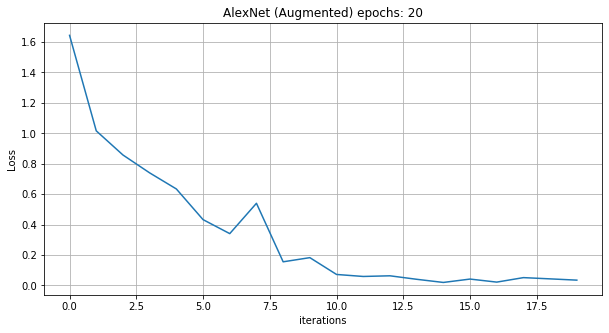

DONE (time 36.45 m)
Total Accuracy 63.88079041140266
Accuracy: 63.88079041140266


In [0]:
train_dataloader_augment=DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dataloader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

net_alexnet_aug = alexnet(pretrained=True) # Loading AlexNet model
net_alexnet_aug.classifier[6] = nn.Linear(4096, NUM_CLASSES)

loss_alexnet_augmented=train_net(net_alexnet_aug, train_dataloader_augment,learning_rate=0.01,epochs_n=20,step_size=10,log_frequency=100, model_description='AlexNet (Augmented)')
accuracy_alexnet_augmented,acc_class_alexnet_aug=perform_test(net_alexnet_aug, test_dataloader)
print('Accuracy: {}'.format(accuracy_alexnet_augmented))


## Compare

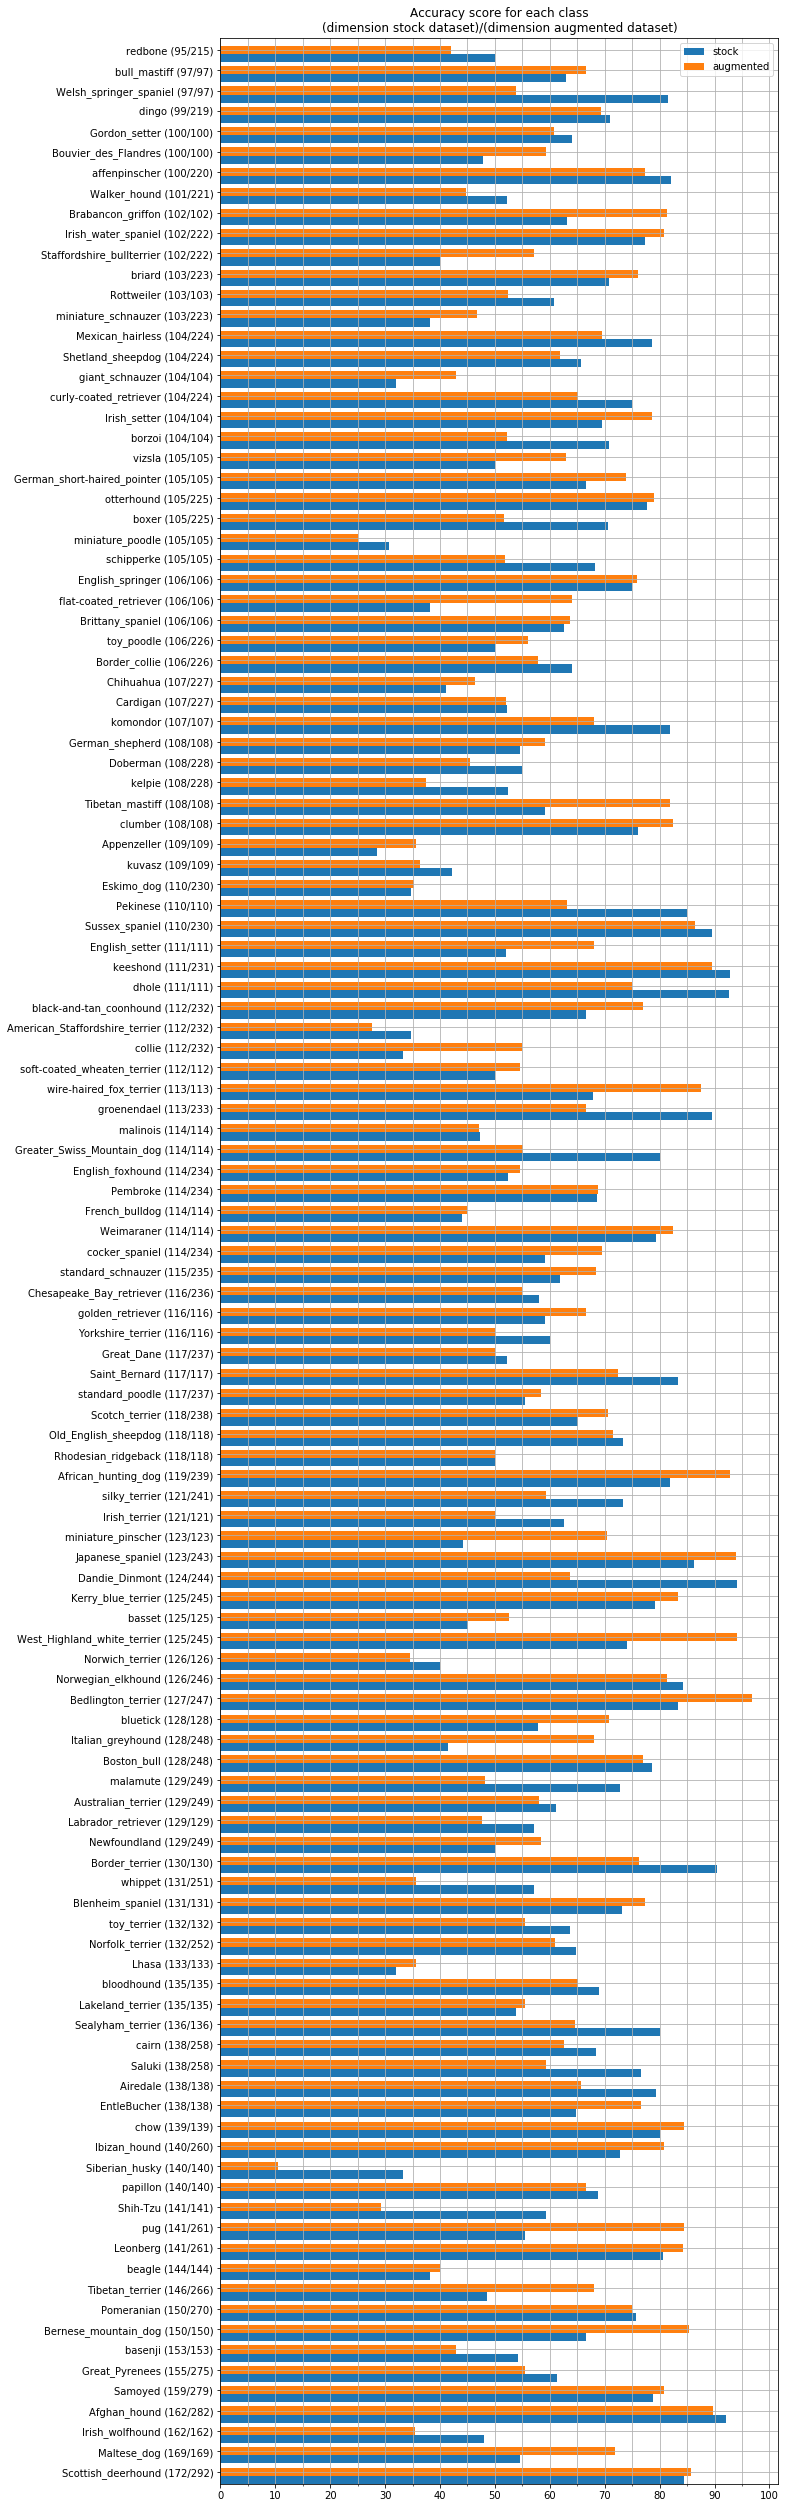

----------------------
{'Afghan_hound': {'acc_stock': 92.10526315789474, 'acc_aug': 89.74358974358974, 'size_stock': 162, 'size_aug': 282}, 'African_hunting_dog': {'acc_stock': 81.81818181818181, 'acc_aug': 92.85714285714286, 'size_stock': 119, 'size_aug': 239}, 'Airedale': {'acc_stock': 79.3103448275862, 'acc_aug': 65.71428571428571, 'size_stock': 138, 'size_aug': 138}, 'American_Staffordshire_terrier': {'acc_stock': 34.78260869565217, 'acc_aug': 27.586206896551722, 'size_stock': 112, 'size_aug': 232}, 'Appenzeller': {'acc_stock': 28.571428571428573, 'acc_aug': 35.714285714285715, 'size_stock': 109, 'size_aug': 109}, 'Australian_terrier': {'acc_stock': 61.111111111111114, 'acc_aug': 58.064516129032256, 'size_stock': 129, 'size_aug': 249}, 'Bedlington_terrier': {'acc_stock': 83.33333333333333, 'acc_aug': 96.7741935483871, 'size_stock': 127, 'size_aug': 247}, 'Bernese_mountain_dog': {'acc_stock': 66.66666666666667, 'acc_aug': 85.36585365853658, 'size_stock': 150, 'size_aug': 150}, 'Blen

In [0]:

plot_dual_loss(loss_alexnet_stock,loss_alexnet_augmented,epoch=30,label1='Alexnet stock',label2='Alexnet augmented')
plot_dual_barh(acc_class_alexnet,acc_class_alexnet_aug,class_distrib)


# VGG 11
### train and test STOCK

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth



Epoch [1/10], LR = [0.01]
Epoch [2/10], LR = [0.01]
Epoch [3/10], LR = [0.01]
Epoch [4/10], LR = [0.01]
Epoch [5/10], LR = [0.01]
Epoch [6/10], LR = [0.01]
Epoch [7/10], LR = [0.01]
Epoch [8/10], LR = [0.0001]
Epoch [9/10], LR = [0.001]
Epoch [10/10], LR = [0.001]


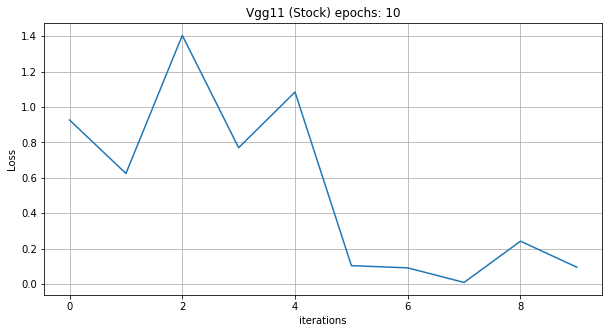

DONE (time 22.98 m)
Total Accuracy 76.3200518302559
Accuracy: 76.3200518302559


In [0]:
train_dataloader=DataLoader(train_dataset_stock, batch_size=64, shuffle=True, num_workers=8)
test_dataloader=DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8)

vgg_stock = vgg11_bn(pretrained=True) # Loading vgg model
vgg_stock.classifier[6] = nn.Linear(4096, NUM_CLASSES)
loss_vgg_stock=train_net(vgg_stock, train_dataloader,learning_rate=0.01,epochs_n=10,step_size=7,log_frequency=50, model_description='Vgg11 (Stock)')
accuracy_vgg_stock,acc_class_vgg_stock=perform_test(vgg_stock, test_dataloader)
print('Accuracy: {}'.format(accuracy_vgg_stock))



## Train and test augmented

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth



Epoch [1/10], LR = [0.01]
Epoch [2/10], LR = [0.01]
Epoch [3/10], LR = [0.01]
Epoch [4/10], LR = [0.01]
Epoch [5/10], LR = [0.01]
Epoch [6/10], LR = [0.01]
Epoch [7/10], LR = [0.01]
Epoch [8/10], LR = [0.0001]
Epoch [9/10], LR = [0.001]
Epoch [10/10], LR = [0.001]


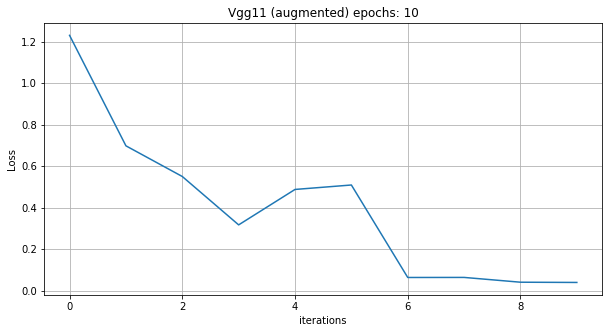

DONE (time 30.40 m)
Total Accuracy 75.47781017168772
Accuracy: 75.47781017168772


In [0]:
train_dataloader=DataLoader(train_dataset_augmented, batch_size=64, shuffle=True, num_workers=8)
test_dataloader=DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8)

vgg_aug = vgg11_bn(pretrained=True) # Loading vgg model
vgg_aug.classifier[6] = nn.Linear(4096, NUM_CLASSES)
loss_vgg_aug=train_net(vgg_aug, train_dataloader,learning_rate=0.01,epochs_n=10,step_size=7,log_frequency=50, model_description='Vgg11 (augmented)')
accuracy_vgg_aug,acc_class_vgg_aug=perform_test(vgg_aug, test_dataloader)
print('Accuracy: {}'.format(accuracy_vgg_aug))


## Compare


In [0]:
#plot_dual_loss(loss_vgg_stock,loss_vgg_aug,epoch=10,label1='vgg1 stock',label2='vgg11 augmented')
plot_dual_barh(acc_class_vgg,acc_class_vgg_aug,class_distrib)


NameError: ignored

# DenseNet
### Train and test stock

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth



Epoch [1/10], LR = [0.01]
Epoch [2/10], LR = [0.01]
Epoch [3/10], LR = [0.01]
Epoch [4/10], LR = [0.01]
Epoch [5/10], LR = [0.01]
Epoch [6/10], LR = [0.01]
Epoch [7/10], LR = [0.01]
Epoch [8/10], LR = [0.0001]
Epoch [9/10], LR = [0.001]
Epoch [10/10], LR = [0.001]


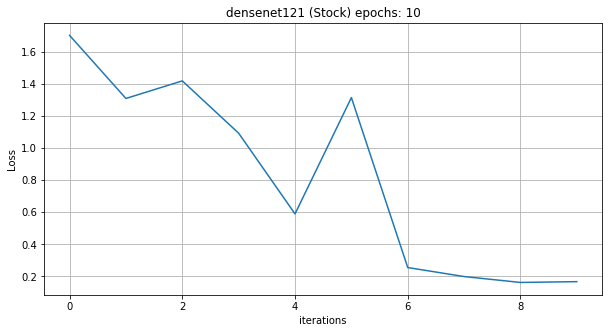

DONE (time 26.91 m)
Total Accuracy 78.16650469711695
Accuracy: 78.16650469711695


In [0]:
train_dataloader=DataLoader(train_dataset_stock, batch_size=32, shuffle=True, num_workers=8)
val_dataloader=DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=8)
densenet_stock = densenet121(pretrained=True) 

densenet_stock.classifier = nn.Linear(1024, NUM_CLASSES)
loss_densenet_stock=train_net(densenet_stock, train_dataloader,learning_rate=0.01,epochs_n=10,step_size=7,log_frequency=50, model_description='densenet121 (Stock)')
accuracy_densenet_stock,acc_class_densenet_stock=perform_test(densenet_stock, test_dataloader)
print('Accuracy: {}'.format(accuracy_densenet_stock))


### Train and test augmented

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth



Epoch [1/10], LR = [0.01]
Epoch [2/10], LR = [0.01]
Epoch [3/10], LR = [0.01]
Epoch [4/10], LR = [0.01]
Epoch [5/10], LR = [0.01]
Epoch [6/10], LR = [0.01]
Epoch [7/10], LR = [0.01]
Epoch [8/10], LR = [0.0001]
Epoch [9/10], LR = [0.001]
Epoch [10/10], LR = [0.001]


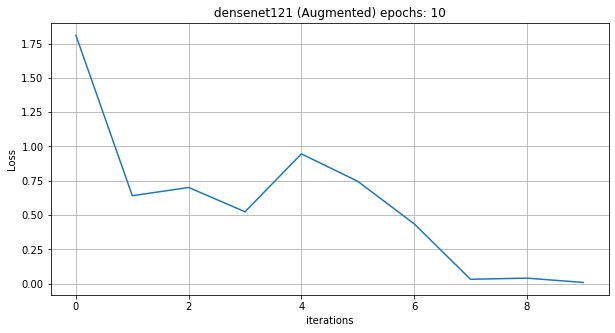

DONE (time 29.69 m)


In [0]:
train_dataloader=DataLoader(train_dataset_augmented, batch_size=32, shuffle=True, num_workers=8)
test_dataloader=DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=8)
densenet_aug = densenet121(pretrained=True) 
densenet_aug.classifier = nn.Linear(1024, NUM_CLASSES)

loss_densenet_aug=train_net(densenet_aug, train_dataloader,learning_rate=0.01,epochs_n=10,step_size=7,log_frequency=50, model_description='densenet121 (Augmented)')
densenet_aug=torch.save(densenet_aug,'./densenet_aug_20epochs.pth')

In [0]:
#load the model because cuda out of memory
densenet_aug=torch.load('densenet_aug_20epochs (1).pth')
train_dataloader=DataLoader(train_dataset_stock, batch_size=32, shuffle=True, num_workers=8)
test_dataloader=DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=8)
accuracy_densenet_aug,acc_class_densenet_aug=perform_test(densenet_aug, val_dataloader)
print('Accuracy: {}'.format(accuracy_densenet_aug))

Total Accuracy 78.52283770651117
Accuracy: 78.52283770651117


## compare 

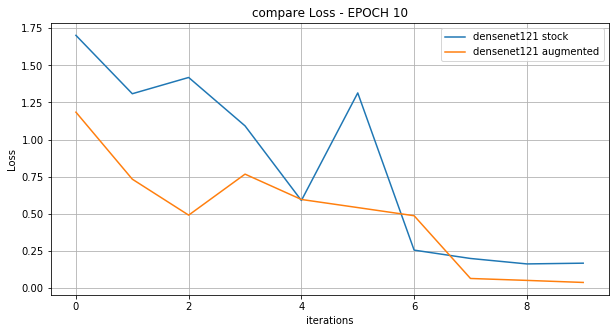

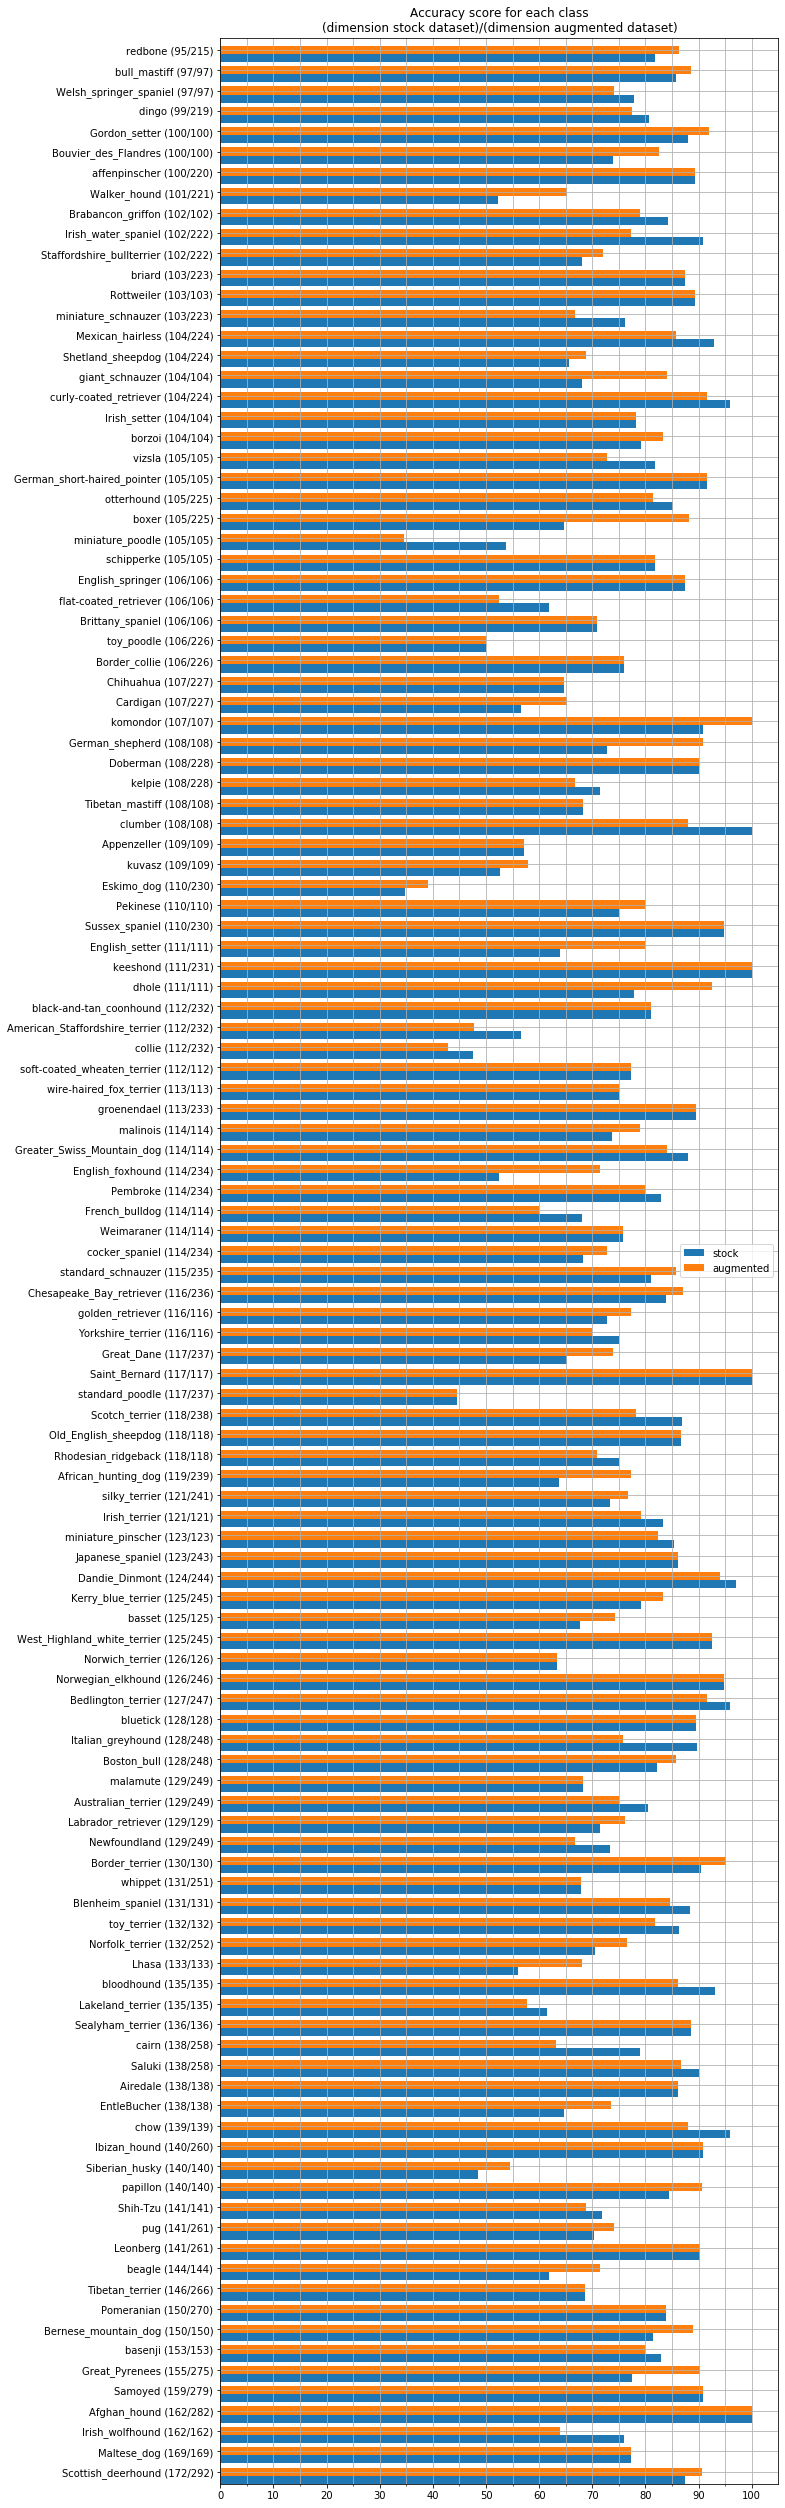

----------------------
{'Afghan_hound': {'acc_stock': 100.0, 'acc_aug': 100.0, 'size_stock': 162, 'size_aug': 282}, 'African_hunting_dog': {'acc_stock': 63.63636363636363, 'acc_aug': 77.27272727272727, 'size_stock': 119, 'size_aug': 239}, 'Airedale': {'acc_stock': 86.20689655172414, 'acc_aug': 86.20689655172414, 'size_stock': 138, 'size_aug': 138}, 'American_Staffordshire_terrier': {'acc_stock': 56.52173913043478, 'acc_aug': 47.82608695652174, 'size_stock': 112, 'size_aug': 232}, 'Appenzeller': {'acc_stock': 57.142857142857146, 'acc_aug': 57.142857142857146, 'size_stock': 109, 'size_aug': 109}, 'Australian_terrier': {'acc_stock': 80.55555555555556, 'acc_aug': 75.0, 'size_stock': 129, 'size_aug': 249}, 'Bedlington_terrier': {'acc_stock': 95.83333333333333, 'acc_aug': 91.66666666666667, 'size_stock': 127, 'size_aug': 247}, 'Bernese_mountain_dog': {'acc_stock': 81.48148148148148, 'acc_aug': 88.88888888888889, 'size_stock': 150, 'size_aug': 150}, 'Blenheim_spaniel': {'acc_stock': 88.461538

In [0]:
plot_dual_loss(loss_densenet_stock,loss_densenet_aug,epoch=10,label1='densenet121 stock',label2='densenet121 augmented')
plot_dual_barh(acc_class_densenet_stock,acc_class_densenet_aug,class_distrib)


In [0]:
vgg_25={'Afghan_hound': {'acc_stock': 97.36842105263158, 'acc_aug': 97.36842105263158, 'size_stock': 162, 'size_aug': 192}, 'African_hunting_dog': {'acc_stock': 77.27272727272727, 'acc_aug': 90.9090909090909, 'size_stock': 119, 'size_aug': 149}, 'Airedale': {'acc_stock': 89.65517241379311, 'acc_aug': 79.3103448275862, 'size_stock': 138, 'size_aug': 168}, 'American_Staffordshire_terrier': {'acc_stock': 60.869565217391305, 'acc_aug': 47.82608695652174, 'size_stock': 112, 'size_aug': 142}, 'Appenzeller': {'acc_stock': 50.0, 'acc_aug': 57.142857142857146, 'size_stock': 109, 'size_aug': 139}, 'Australian_terrier': {'acc_stock': 69.44444444444444, 'acc_aug': 61.111111111111114, 'size_stock': 129, 'size_aug': 159}, 'Bedlington_terrier': {'acc_stock': 95.83333333333333, 'acc_aug': 95.83333333333333, 'size_stock': 127, 'size_aug': 157}, 'Bernese_mountain_dog': {'acc_stock': 92.5925925925926, 'acc_aug': 85.18518518518519, 'size_stock': 150, 'size_aug': 180}, 'Blenheim_spaniel': {'acc_stock': 80.76923076923077, 'acc_aug': 69.23076923076923, 'size_stock': 131, 'size_aug': 161}, 'Border_collie': {'acc_stock': 72.0, 'acc_aug': 68.0, 'size_stock': 106, 'size_aug': 136}, 'Border_terrier': {'acc_stock': 95.23809523809524, 'acc_aug': 85.71428571428571, 'size_stock': 130, 'size_aug': 160}, 'Boston_bull': {'acc_stock': 82.14285714285714, 'acc_aug': 75.0, 'size_stock': 128, 'size_aug': 158}, 'Bouvier_des_Flandres': {'acc_stock': 73.91304347826087, 'acc_aug': 78.26086956521739, 'size_stock': 100, 'size_aug': 130}, 'Brabancon_griffon': {'acc_stock': 94.73684210526316, 'acc_aug': 84.21052631578948, 'size_stock': 102, 'size_aug': 132}, 'Brittany_spaniel': {'acc_stock': 66.66666666666667, 'acc_aug': 70.83333333333333, 'size_stock': 106, 'size_aug': 136}, 'Cardigan': {'acc_stock': 56.52173913043478, 'acc_aug': 56.52173913043478, 'size_stock': 107, 'size_aug': 137}, 'Chesapeake_Bay_retriever': {'acc_stock': 77.41935483870968, 'acc_aug': 83.87096774193549, 'size_stock': 116, 'size_aug': 146}, 'Chihuahua': {'acc_stock': 70.58823529411765, 'acc_aug': 76.47058823529412, 'size_stock': 107, 'size_aug': 137}, 'Dandie_Dinmont': {'acc_stock': 91.17647058823529, 'acc_aug': 97.05882352941177, 'size_stock': 124, 'size_aug': 154}, 'Doberman': {'acc_stock': 75.0, 'acc_aug': 65.0, 'size_stock': 108, 'size_aug': 138}, 'English_foxhound': {'acc_stock': 57.142857142857146, 'acc_aug': 52.38095238095238, 'size_stock': 114, 'size_aug': 144}, 'English_setter': {'acc_stock': 76.0, 'acc_aug': 80.0, 'size_stock': 111, 'size_aug': 141}, 'English_springer': {'acc_stock': 91.66666666666667, 'acc_aug': 91.66666666666667, 'size_stock': 106, 'size_aug': 136}, 'EntleBucher': {'acc_stock': 70.58823529411765, 'acc_aug': 64.70588235294117, 'size_stock': 138, 'size_aug': 168}, 'Eskimo_dog': {'acc_stock': 21.73913043478261, 'acc_aug': 39.130434782608695, 'size_stock': 110, 'size_aug': 140}, 'French_bulldog': {'acc_stock': 60.0, 'acc_aug': 68.0, 'size_stock': 114, 'size_aug': 144}, 'German_shepherd': {'acc_stock': 68.18181818181819, 'acc_aug': 63.63636363636363, 'size_stock': 108, 'size_aug': 138}, 'German_short-haired_pointer': {'acc_stock': 87.5, 'acc_aug': 83.33333333333333, 'size_stock': 105, 'size_aug': 135}, 'Gordon_setter': {'acc_stock': 84.0, 'acc_aug': 88.0, 'size_stock': 100, 'size_aug': 130}, 'Great_Dane': {'acc_stock': 52.17391304347826, 'acc_aug': 60.869565217391305, 'size_stock': 117, 'size_aug': 147}, 'Great_Pyrenees': {'acc_stock': 80.64516129032258, 'acc_aug': 67.74193548387096, 'size_stock': 155, 'size_aug': 185}, 'Greater_Swiss_Mountain_dog': {'acc_stock': 92.0, 'acc_aug': 84.0, 'size_stock': 114, 'size_aug': 144}, 'Ibizan_hound': {'acc_stock': 90.9090909090909, 'acc_aug': 77.27272727272727, 'size_stock': 140, 'size_aug': 170}, 'Irish_setter': {'acc_stock': 82.6086956521739, 'acc_aug': 78.26086956521739, 'size_stock': 104, 'size_aug': 134}, 'Irish_terrier': {'acc_stock': 66.66666666666667, 'acc_aug': 75.0, 'size_stock': 121, 'size_aug': 151}, 'Irish_water_spaniel': {'acc_stock': 81.81818181818181, 'acc_aug': 86.36363636363636, 'size_stock': 102, 'size_aug': 132}, 'Irish_wolfhound': {'acc_stock': 68.0, 'acc_aug': 72.0, 'size_stock': 162, 'size_aug': 192}, 'Italian_greyhound': {'acc_stock': 86.20689655172414, 'acc_aug': 72.41379310344827, 'size_stock': 128, 'size_aug': 158}, 'Japanese_spaniel': {'acc_stock': 82.75862068965517, 'acc_aug': 89.65517241379311, 'size_stock': 123, 'size_aug': 153}, 'Kerry_blue_terrier': {'acc_stock': 87.5, 'acc_aug': 83.33333333333333, 'size_stock': 125, 'size_aug': 155}, 'Labrador_retriever': {'acc_stock': 61.904761904761905, 'acc_aug': 71.42857142857143, 'size_stock': 129, 'size_aug': 159}, 'Lakeland_terrier': {'acc_stock': 65.38461538461539, 'acc_aug': 69.23076923076923, 'size_stock': 135, 'size_aug': 165}, 'Leonberg': {'acc_stock': 87.09677419354838, 'acc_aug': 90.3225806451613, 'size_stock': 141, 'size_aug': 171}, 'Lhasa': {'acc_stock': 64.0, 'acc_aug': 64.0, 'size_stock': 133, 'size_aug': 163}, 'Maltese_dog': {'acc_stock': 75.0, 'acc_aug': 81.81818181818181, 'size_stock': 169, 'size_aug': 199}, 'Mexican_hairless': {'acc_stock': 92.85714285714286, 'acc_aug': 92.85714285714286, 'size_stock': 104, 'size_aug': 134}, 'Newfoundland': {'acc_stock': 76.66666666666667, 'acc_aug': 76.66666666666667, 'size_stock': 129, 'size_aug': 159}, 'Norfolk_terrier': {'acc_stock': 64.70588235294117, 'acc_aug': 64.70588235294117, 'size_stock': 132, 'size_aug': 162}, 'Norwegian_elkhound': {'acc_stock': 92.10526315789474, 'acc_aug': 94.73684210526316, 'size_stock': 126, 'size_aug': 156}, 'Norwich_terrier': {'acc_stock': 70.0, 'acc_aug': 60.0, 'size_stock': 126, 'size_aug': 156}, 'Old_English_sheepdog': {'acc_stock': 93.33333333333333, 'acc_aug': 90.0, 'size_stock': 118, 'size_aug': 148}, 'Pekinese': {'acc_stock': 75.0, 'acc_aug': 80.0, 'size_stock': 110, 'size_aug': 140}, 'Pembroke': {'acc_stock': 65.71428571428571, 'acc_aug': 77.14285714285714, 'size_stock': 114, 'size_aug': 144}, 'Pomeranian': {'acc_stock': 83.78378378378379, 'acc_aug': 81.08108108108108, 'size_stock': 150, 'size_aug': 180}, 'Rhodesian_ridgeback': {'acc_stock': 70.83333333333333, 'acc_aug': 75.0, 'size_stock': 118, 'size_aug': 148}, 'Rottweiler': {'acc_stock': 85.71428571428571, 'acc_aug': 85.71428571428571, 'size_stock': 103, 'size_aug': 133}, 'Saint_Bernard': {'acc_stock': 91.66666666666667, 'acc_aug': 100.0, 'size_stock': 117, 'size_aug': 147}, 'Saluki': {'acc_stock': 80.0, 'acc_aug': 86.66666666666667, 'size_stock': 138, 'size_aug': 168}, 'Samoyed': {'acc_stock': 84.84848484848484, 'acc_aug': 93.93939393939394, 'size_stock': 159, 'size_aug': 189}, 'Scotch_terrier': {'acc_stock': 86.95652173913044, 'acc_aug': 78.26086956521739, 'size_stock': 118, 'size_aug': 148}, 'Scottish_deerhound': {'acc_stock': 90.625, 'acc_aug': 93.75, 'size_stock': 172, 'size_aug': 202}, 'Sealyham_terrier': {'acc_stock': 88.57142857142857, 'acc_aug': 82.85714285714286, 'size_stock': 136, 'size_aug': 166}, 'Shetland_sheepdog': {'acc_stock': 56.25, 'acc_aug': 62.5, 'size_stock': 104, 'size_aug': 134}, 'Shih-Tzu': {'acc_stock': 53.125, 'acc_aug': 59.375, 'size_stock': 141, 'size_aug': 171}, 'Siberian_husky': {'acc_stock': 60.60606060606061, 'acc_aug': 33.333333333333336, 'size_stock': 140, 'size_aug': 170}, 'Staffordshire_bullterrier': {'acc_stock': 68.0, 'acc_aug': 72.0, 'size_stock': 102, 'size_aug': 132}, 'Sussex_spaniel': {'acc_stock': 84.21052631578948, 'acc_aug': 94.73684210526316, 'size_stock': 110, 'size_aug': 140}, 'Tibetan_mastiff': {'acc_stock': 63.63636363636363, 'acc_aug': 54.54545454545455, 'size_stock': 108, 'size_aug': 138}, 'Tibetan_terrier': {'acc_stock': 71.42857142857143, 'acc_aug': 71.42857142857143, 'size_stock': 146, 'size_aug': 176}, 'Walker_hound': {'acc_stock': 78.26086956521739, 'acc_aug': 73.91304347826087, 'size_stock': 101, 'size_aug': 131}, 'Weimaraner': {'acc_stock': 86.20689655172414, 'acc_aug': 75.86206896551724, 'size_stock': 114, 'size_aug': 144}, 'Welsh_springer_spaniel': {'acc_stock': 85.18518518518519, 'acc_aug': 74.07407407407408, 'size_stock': 97, 'size_aug': 127}, 'West_Highland_white_terrier': {'acc_stock': 85.18518518518519, 'acc_aug': 81.48148148148148, 'size_stock': 125, 'size_aug': 155}, 'Yorkshire_terrier': {'acc_stock': 70.0, 'acc_aug': 60.0, 'size_stock': 116, 'size_aug': 146}, 'affenpinscher': {'acc_stock': 89.28571428571429, 'acc_aug': 78.57142857142857, 'size_stock': 100, 'size_aug': 130}, 'basenji': {'acc_stock': 80.0, 'acc_aug': 68.57142857142857, 'size_stock': 153, 'size_aug': 183}, 'basset': {'acc_stock': 70.96774193548387, 'acc_aug': 70.96774193548387, 'size_stock': 125, 'size_aug': 155}, 'beagle': {'acc_stock': 80.95238095238095, 'acc_aug': 47.61904761904762, 'size_stock': 144, 'size_aug': 174}, 'black-and-tan_coonhound': {'acc_stock': 80.95238095238095, 'acc_aug': 85.71428571428571, 'size_stock': 112, 'size_aug': 142}, 'bloodhound': {'acc_stock': 82.75862068965517, 'acc_aug': 89.65517241379311, 'size_stock': 135, 'size_aug': 165}, 'bluetick': {'acc_stock': 78.94736842105263, 'acc_aug': 84.21052631578948, 'size_stock': 128, 'size_aug': 158}, 'borzoi': {'acc_stock': 70.83333333333333, 'acc_aug': 66.66666666666667, 'size_stock': 104, 'size_aug': 134}, 'boxer': {'acc_stock': 76.47058823529412, 'acc_aug': 76.47058823529412, 'size_stock': 105, 'size_aug': 135}, 'briard': {'acc_stock': 83.33333333333333, 'acc_aug': 91.66666666666667, 'size_stock': 103, 'size_aug': 133}, 'bull_mastiff': {'acc_stock': 80.0, 'acc_aug': 85.71428571428571, 'size_stock': 97, 'size_aug': 127}, 'cairn': {'acc_stock': 73.6842105263158, 'acc_aug': 100.0, 'size_stock': 138, 'size_aug': 168}, 'chow': {'acc_stock': 96.0, 'acc_aug': 96.0, 'size_stock': 139, 'size_aug': 169}, 'clumber': {'acc_stock': 88.0, 'acc_aug': 96.0, 'size_stock': 108, 'size_aug': 138}, 'cocker_spaniel': {'acc_stock': 68.18181818181819, 'acc_aug': 63.63636363636363, 'size_stock': 114, 'size_aug': 144}, 'collie': {'acc_stock': 47.61904761904762, 'acc_aug': 47.61904761904762, 'size_stock': 112, 'size_aug': 142}, 'curly-coated_retriever': {'acc_stock': 83.33333333333333, 'acc_aug': 87.5, 'size_stock': 104, 'size_aug': 134}, 'dhole': {'acc_stock': 88.88888888888889, 'acc_aug': 92.5925925925926, 'size_stock': 111, 'size_aug': 141}, 'dingo': {'acc_stock': 74.19354838709677, 'acc_aug': 77.41935483870968, 'size_stock': 99, 'size_aug': 129}, 'flat-coated_retriever': {'acc_stock': 57.142857142857146, 'acc_aug': 71.42857142857143, 'size_stock': 106, 'size_aug': 136}, 'giant_schnauzer': {'acc_stock': 72.0, 'acc_aug': 56.0, 'size_stock': 104, 'size_aug': 134}, 'golden_retriever': {'acc_stock': 81.81818181818181, 'acc_aug': 63.63636363636363, 'size_stock': 116, 'size_aug': 146}, 'groenendael': {'acc_stock': 89.47368421052632, 'acc_aug': 89.47368421052632, 'size_stock': 113, 'size_aug': 143}, 'keeshond': {'acc_stock': 96.42857142857143, 'acc_aug': 100.0, 'size_stock': 111, 'size_aug': 141}, 'kelpie': {'acc_stock': 57.142857142857146, 'acc_aug': 61.904761904761905, 'size_stock': 108, 'size_aug': 138}, 'komondor': {'acc_stock': 90.9090909090909, 'acc_aug': 81.81818181818181, 'size_stock': 107, 'size_aug': 137}, 'kuvasz': {'acc_stock': 68.42105263157895, 'acc_aug': 73.6842105263158, 'size_stock': 109, 'size_aug': 139}, 'malamute': {'acc_stock': 68.18181818181819, 'acc_aug': 63.63636363636363, 'size_stock': 129, 'size_aug': 159}, 'malinois': {'acc_stock': 73.6842105263158, 'acc_aug': 78.94736842105263, 'size_stock': 114, 'size_aug': 144}, 'miniature_pinscher': {'acc_stock': 82.3529411764706, 'acc_aug': 73.52941176470588, 'size_stock': 123, 'size_aug': 153}, 'miniature_poodle': {'acc_stock': 34.61538461538461, 'acc_aug': 50.0, 'size_stock': 105, 'size_aug': 135}, 'miniature_schnauzer': {'acc_stock': 61.904761904761905, 'acc_aug': 61.904761904761905, 'size_stock': 103, 'size_aug': 133}, 'otterhound': {'acc_stock': 74.07407407407408, 'acc_aug': 85.18518518518519, 'size_stock': 105, 'size_aug': 135}, 'papillon': {'acc_stock': 78.125, 'acc_aug': 81.25, 'size_stock': 140, 'size_aug': 170}, 'pug': {'acc_stock': 88.88888888888889, 'acc_aug': 81.48148148148148, 'size_stock': 141, 'size_aug': 171}, 'redbone': {'acc_stock': 81.81818181818181, 'acc_aug': 86.36363636363636, 'size_stock': 95, 'size_aug': 125}, 'schipperke': {'acc_stock': 81.81818181818181, 'acc_aug': 81.81818181818181, 'size_stock': 105, 'size_aug': 135}, 'silky_terrier': {'acc_stock': 66.66666666666667, 'acc_aug': 70.0, 'size_stock': 121, 'size_aug': 151}, 'soft-coated_wheaten_terrier': {'acc_stock': 59.09090909090909, 'acc_aug': 77.27272727272727, 'size_stock': 112, 'size_aug': 142}, 'standard_poodle': {'acc_stock': 44.44444444444444, 'acc_aug': 33.333333333333336, 'size_stock': 117, 'size_aug': 147}, 'standard_schnauzer': {'acc_stock': 61.904761904761905, 'acc_aug': 66.66666666666667, 'size_stock': 115, 'size_aug': 145}, 'toy_poodle': {'acc_stock': 65.0, 'acc_aug': 30.0, 'size_stock': 106, 'size_aug': 136}, 'toy_terrier': {'acc_stock': 63.63636363636363, 'acc_aug': 63.63636363636363, 'size_stock': 132, 'size_aug': 162}, 'vizsla': {'acc_stock': 72.72727272727273, 'acc_aug': 86.36363636363636, 'size_stock': 105, 'size_aug': 135}, 'whippet': {'acc_stock': 64.28571428571429, 'acc_aug': 67.85714285714286, 'size_stock': 131, 'size_aug': 161}, 'wire-haired_fox_terrier': {'acc_stock': 78.57142857142857, 'acc_aug': 75.0, 'size_stock': 113, 'size_aug': 143}}

In [0]:
vgg_50={'Afghan_hound': {'acc_stock': 94.73684210526316, 'acc_aug': 94.73684210526316, 'size_stock': 162, 'size_aug': 222}, 'African_hunting_dog': {'acc_stock': 90.9090909090909, 'acc_aug': 90.9090909090909, 'size_stock': 119, 'size_aug': 179}, 'Airedale': {'acc_stock': 82.75862068965517, 'acc_aug': 86.20689655172414, 'size_stock': 138, 'size_aug': 198}, 'American_Staffordshire_terrier': {'acc_stock': 52.17391304347826, 'acc_aug': 47.82608695652174, 'size_stock': 112, 'size_aug': 172}, 'Appenzeller': {'acc_stock': 50.0, 'acc_aug': 50.0, 'size_stock': 109, 'size_aug': 169}, 'Australian_terrier': {'acc_stock': 69.44444444444444, 'acc_aug': 69.44444444444444, 'size_stock': 129, 'size_aug': 189}, 'Bedlington_terrier': {'acc_stock': 87.5, 'acc_aug': 91.66666666666667, 'size_stock': 127, 'size_aug': 187}, 'Bernese_mountain_dog': {'acc_stock': 92.5925925925926, 'acc_aug': 85.18518518518519, 'size_stock': 150, 'size_aug': 210}, 'Blenheim_spaniel': {'acc_stock': 73.07692307692308, 'acc_aug': 76.92307692307692, 'size_stock': 131, 'size_aug': 191}, 'Border_collie': {'acc_stock': 72.0, 'acc_aug': 80.0, 'size_stock': 106, 'size_aug': 166}, 'Border_terrier': {'acc_stock': 95.23809523809524, 'acc_aug': 95.23809523809524, 'size_stock': 130, 'size_aug': 190}, 'Boston_bull': {'acc_stock': 78.57142857142857, 'acc_aug': 82.14285714285714, 'size_stock': 128, 'size_aug': 188}, 'Bouvier_des_Flandres': {'acc_stock': 69.56521739130434, 'acc_aug': 56.52173913043478, 'size_stock': 100, 'size_aug': 160}, 'Brabancon_griffon': {'acc_stock': 84.21052631578948, 'acc_aug': 89.47368421052632, 'size_stock': 102, 'size_aug': 162}, 'Brittany_spaniel': {'acc_stock': 62.5, 'acc_aug': 75.0, 'size_stock': 106, 'size_aug': 166}, 'Cardigan': {'acc_stock': 60.869565217391305, 'acc_aug': 60.869565217391305, 'size_stock': 107, 'size_aug': 167}, 'Chesapeake_Bay_retriever': {'acc_stock': 83.87096774193549, 'acc_aug': 83.87096774193549, 'size_stock': 116, 'size_aug': 176}, 'Chihuahua': {'acc_stock': 64.70588235294117, 'acc_aug': 64.70588235294117, 'size_stock': 107, 'size_aug': 167}, 'Dandie_Dinmont': {'acc_stock': 94.11764705882354, 'acc_aug': 88.23529411764706, 'size_stock': 124, 'size_aug': 184}, 'Doberman': {'acc_stock': 80.0, 'acc_aug': 90.0, 'size_stock': 108, 'size_aug': 168}, 'English_foxhound': {'acc_stock': 57.142857142857146, 'acc_aug': 42.857142857142854, 'size_stock': 114, 'size_aug': 174}, 'English_setter': {'acc_stock': 76.0, 'acc_aug': 76.0, 'size_stock': 111, 'size_aug': 171}, 'English_springer': {'acc_stock': 91.66666666666667, 'acc_aug': 95.83333333333333, 'size_stock': 106, 'size_aug': 166}, 'EntleBucher': {'acc_stock': 82.3529411764706, 'acc_aug': 73.52941176470588, 'size_stock': 138, 'size_aug': 198}, 'Eskimo_dog': {'acc_stock': 30.434782608695652, 'acc_aug': 34.78260869565217, 'size_stock': 110, 'size_aug': 170}, 'French_bulldog': {'acc_stock': 68.0, 'acc_aug': 56.0, 'size_stock': 114, 'size_aug': 174}, 'German_shepherd': {'acc_stock': 68.18181818181819, 'acc_aug': 54.54545454545455, 'size_stock': 108, 'size_aug': 168}, 'German_short-haired_pointer': {'acc_stock': 83.33333333333333, 'acc_aug': 79.16666666666667, 'size_stock': 105, 'size_aug': 165}, 'Gordon_setter': {'acc_stock': 88.0, 'acc_aug': 88.0, 'size_stock': 100, 'size_aug': 160}, 'Great_Dane': {'acc_stock': 69.56521739130434, 'acc_aug': 56.52173913043478, 'size_stock': 117, 'size_aug': 177}, 'Great_Pyrenees': {'acc_stock': 74.19354838709677, 'acc_aug': 70.96774193548387, 'size_stock': 155, 'size_aug': 215}, 'Greater_Swiss_Mountain_dog': {'acc_stock': 80.0, 'acc_aug': 80.0, 'size_stock': 114, 'size_aug': 174}, 'Ibizan_hound': {'acc_stock': 86.36363636363636, 'acc_aug': 86.36363636363636, 'size_stock': 140, 'size_aug': 200}, 'Irish_setter': {'acc_stock': 86.95652173913044, 'acc_aug': 73.91304347826087, 'size_stock': 104, 'size_aug': 164}, 'Irish_terrier': {'acc_stock': 70.83333333333333, 'acc_aug': 70.83333333333333, 'size_stock': 121, 'size_aug': 181}, 'Irish_water_spaniel': {'acc_stock': 77.27272727272727, 'acc_aug': 81.81818181818181, 'size_stock': 102, 'size_aug': 162}, 'Irish_wolfhound': {'acc_stock': 72.0, 'acc_aug': 76.0, 'size_stock': 162, 'size_aug': 222}, 'Italian_greyhound': {'acc_stock': 65.51724137931035, 'acc_aug': 82.75862068965517, 'size_stock': 128, 'size_aug': 188}, 'Japanese_spaniel': {'acc_stock': 89.65517241379311, 'acc_aug': 89.65517241379311, 'size_stock': 123, 'size_aug': 183}, 'Kerry_blue_terrier': {'acc_stock': 87.5, 'acc_aug': 83.33333333333333, 'size_stock': 125, 'size_aug': 185}, 'Labrador_retriever': {'acc_stock': 66.66666666666667, 'acc_aug': 71.42857142857143, 'size_stock': 129, 'size_aug': 189}, 'Lakeland_terrier': {'acc_stock': 65.38461538461539, 'acc_aug': 65.38461538461539, 'size_stock': 135, 'size_aug': 195}, 'Leonberg': {'acc_stock': 87.09677419354838, 'acc_aug': 90.3225806451613, 'size_stock': 141, 'size_aug': 201}, 'Lhasa': {'acc_stock': 56.0, 'acc_aug': 48.0, 'size_stock': 133, 'size_aug': 193}, 'Maltese_dog': {'acc_stock': 81.81818181818181, 'acc_aug': 63.63636363636363, 'size_stock': 169, 'size_aug': 229}, 'Mexican_hairless': {'acc_stock': 89.28571428571429, 'acc_aug': 89.28571428571429, 'size_stock': 104, 'size_aug': 164}, 'Newfoundland': {'acc_stock': 80.0, 'acc_aug': 80.0, 'size_stock': 129, 'size_aug': 189}, 'Norfolk_terrier': {'acc_stock': 70.58823529411765, 'acc_aug': 70.58823529411765, 'size_stock': 132, 'size_aug': 192}, 'Norwegian_elkhound': {'acc_stock': 97.36842105263158, 'acc_aug': 94.73684210526316, 'size_stock': 126, 'size_aug': 186}, 'Norwich_terrier': {'acc_stock': 60.0, 'acc_aug': 70.0, 'size_stock': 126, 'size_aug': 186}, 'Old_English_sheepdog': {'acc_stock': 93.33333333333333, 'acc_aug': 86.66666666666667, 'size_stock': 118, 'size_aug': 178}, 'Pekinese': {'acc_stock': 75.0, 'acc_aug': 80.0, 'size_stock': 110, 'size_aug': 170}, 'Pembroke': {'acc_stock': 71.42857142857143, 'acc_aug': 74.28571428571429, 'size_stock': 114, 'size_aug': 174}, 'Pomeranian': {'acc_stock': 81.08108108108108, 'acc_aug': 83.78378378378379, 'size_stock': 150, 'size_aug': 210}, 'Rhodesian_ridgeback': {'acc_stock': 79.16666666666667, 'acc_aug': 62.5, 'size_stock': 118, 'size_aug': 178}, 'Rottweiler': {'acc_stock': 82.14285714285714, 'acc_aug': 89.28571428571429, 'size_stock': 103, 'size_aug': 163}, 'Saint_Bernard': {'acc_stock': 91.66666666666667, 'acc_aug': 91.66666666666667, 'size_stock': 117, 'size_aug': 177}, 'Saluki': {'acc_stock': 86.66666666666667, 'acc_aug': 83.33333333333333, 'size_stock': 138, 'size_aug': 198}, 'Samoyed': {'acc_stock': 84.84848484848484, 'acc_aug': 93.93939393939394, 'size_stock': 159, 'size_aug': 219}, 'Scotch_terrier': {'acc_stock': 78.26086956521739, 'acc_aug': 78.26086956521739, 'size_stock': 118, 'size_aug': 178}, 'Scottish_deerhound': {'acc_stock': 75.0, 'acc_aug': 75.0, 'size_stock': 172, 'size_aug': 232}, 'Sealyham_terrier': {'acc_stock': 88.57142857142857, 'acc_aug': 91.42857142857143, 'size_stock': 136, 'size_aug': 196}, 'Shetland_sheepdog': {'acc_stock': 62.5, 'acc_aug': 71.875, 'size_stock': 104, 'size_aug': 164}, 'Shih-Tzu': {'acc_stock': 59.375, 'acc_aug': 62.5, 'size_stock': 141, 'size_aug': 201}, 'Siberian_husky': {'acc_stock': 54.54545454545455, 'acc_aug': 45.45454545454545, 'size_stock': 140, 'size_aug': 200}, 'Staffordshire_bullterrier': {'acc_stock': 76.0, 'acc_aug': 68.0, 'size_stock': 102, 'size_aug': 162}, 'Sussex_spaniel': {'acc_stock': 89.47368421052632, 'acc_aug': 84.21052631578948, 'size_stock': 110, 'size_aug': 170}, 'Tibetan_mastiff': {'acc_stock': 50.0, 'acc_aug': 68.18181818181819, 'size_stock': 108, 'size_aug': 168}, 'Tibetan_terrier': {'acc_stock': 74.28571428571429, 'acc_aug': 77.14285714285714, 'size_stock': 146, 'size_aug': 206}, 'Walker_hound': {'acc_stock': 56.52173913043478, 'acc_aug': 56.52173913043478, 'size_stock': 101, 'size_aug': 161}, 'Weimaraner': {'acc_stock': 79.3103448275862, 'acc_aug': 82.75862068965517, 'size_stock': 114, 'size_aug': 174}, 'Welsh_springer_spaniel': {'acc_stock': 81.48148148148148, 'acc_aug': 81.48148148148148, 'size_stock': 97, 'size_aug': 157}, 'West_Highland_white_terrier': {'acc_stock': 85.18518518518519, 'acc_aug': 74.07407407407408, 'size_stock': 125, 'size_aug': 185}, 'Yorkshire_terrier': {'acc_stock': 70.0, 'acc_aug': 55.0, 'size_stock': 116, 'size_aug': 176}, 'affenpinscher': {'acc_stock': 82.14285714285714, 'acc_aug': 82.14285714285714, 'size_stock': 100, 'size_aug': 160}, 'basenji': {'acc_stock': 80.0, 'acc_aug': 68.57142857142857, 'size_stock': 153, 'size_aug': 213}, 'basset': {'acc_stock': 83.87096774193549, 'acc_aug': 80.64516129032258, 'size_stock': 125, 'size_aug': 185}, 'beagle': {'acc_stock': 61.904761904761905, 'acc_aug': 61.904761904761905, 'size_stock': 144, 'size_aug': 204}, 'black-and-tan_coonhound': {'acc_stock': 80.95238095238095, 'acc_aug': 80.95238095238095, 'size_stock': 112, 'size_aug': 172}, 'bloodhound': {'acc_stock': 82.75862068965517, 'acc_aug': 86.20689655172414, 'size_stock': 135, 'size_aug': 195}, 'bluetick': {'acc_stock': 78.94736842105263, 'acc_aug': 84.21052631578948, 'size_stock': 128, 'size_aug': 188}, 'borzoi': {'acc_stock': 75.0, 'acc_aug': 75.0, 'size_stock': 104, 'size_aug': 164}, 'boxer': {'acc_stock': 64.70588235294117, 'acc_aug': 82.3529411764706, 'size_stock': 105, 'size_aug': 165}, 'briard': {'acc_stock': 100.0, 'acc_aug': 91.66666666666667, 'size_stock': 103, 'size_aug': 163}, 'bull_mastiff': {'acc_stock': 88.57142857142857, 'acc_aug': 85.71428571428571, 'size_stock': 97, 'size_aug': 157}, 'cairn': {'acc_stock': 78.94736842105263, 'acc_aug': 94.73684210526316, 'size_stock': 138, 'size_aug': 198}, 'chow': {'acc_stock': 92.0, 'acc_aug': 92.0, 'size_stock': 139, 'size_aug': 199}, 'clumber': {'acc_stock': 88.0, 'acc_aug': 92.0, 'size_stock': 108, 'size_aug': 168}, 'cocker_spaniel': {'acc_stock': 72.72727272727273, 'acc_aug': 54.54545454545455, 'size_stock': 114, 'size_aug': 174}, 'collie': {'acc_stock': 42.857142857142854, 'acc_aug': 42.857142857142854, 'size_stock': 112, 'size_aug': 172}, 'curly-coated_retriever': {'acc_stock': 87.5, 'acc_aug': 91.66666666666667, 'size_stock': 104, 'size_aug': 164}, 'dhole': {'acc_stock': 88.88888888888889, 'acc_aug': 88.88888888888889, 'size_stock': 111, 'size_aug': 171}, 'dingo': {'acc_stock': 74.19354838709677, 'acc_aug': 83.87096774193549, 'size_stock': 99, 'size_aug': 159}, 'flat-coated_retriever': {'acc_stock': 57.142857142857146, 'acc_aug': 71.42857142857143, 'size_stock': 106, 'size_aug': 166}, 'giant_schnauzer': {'acc_stock': 72.0, 'acc_aug': 48.0, 'size_stock': 104, 'size_aug': 164}, 'golden_retriever': {'acc_stock': 77.27272727272727, 'acc_aug': 68.18181818181819, 'size_stock': 116, 'size_aug': 176}, 'groenendael': {'acc_stock': 94.73684210526316, 'acc_aug': 89.47368421052632, 'size_stock': 113, 'size_aug': 173}, 'keeshond': {'acc_stock': 100.0, 'acc_aug': 96.42857142857143, 'size_stock': 111, 'size_aug': 171}, 'kelpie': {'acc_stock': 61.904761904761905, 'acc_aug': 66.66666666666667, 'size_stock': 108, 'size_aug': 168}, 'komondor': {'acc_stock': 95.45454545454545, 'acc_aug': 86.36363636363636, 'size_stock': 107, 'size_aug': 167}, 'kuvasz': {'acc_stock': 57.89473684210526, 'acc_aug': 57.89473684210526, 'size_stock': 109, 'size_aug': 169}, 'malamute': {'acc_stock': 72.72727272727273, 'acc_aug': 72.72727272727273, 'size_stock': 129, 'size_aug': 189}, 'malinois': {'acc_stock': 89.47368421052632, 'acc_aug': 78.94736842105263, 'size_stock': 114, 'size_aug': 174}, 'miniature_pinscher': {'acc_stock': 76.47058823529412, 'acc_aug': 82.3529411764706, 'size_stock': 123, 'size_aug': 183}, 'miniature_poodle': {'acc_stock': 46.15384615384615, 'acc_aug': 50.0, 'size_stock': 105, 'size_aug': 165}, 'miniature_schnauzer': {'acc_stock': 61.904761904761905, 'acc_aug': 61.904761904761905, 'size_stock': 103, 'size_aug': 163}, 'otterhound': {'acc_stock': 81.48148148148148, 'acc_aug': 81.48148148148148, 'size_stock': 105, 'size_aug': 165}, 'papillon': {'acc_stock': 81.25, 'acc_aug': 78.125, 'size_stock': 140, 'size_aug': 200}, 'pug': {'acc_stock': 85.18518518518519, 'acc_aug': 81.48148148148148, 'size_stock': 141, 'size_aug': 201}, 'redbone': {'acc_stock': 77.27272727272727, 'acc_aug': 72.72727272727273, 'size_stock': 95, 'size_aug': 155}, 'schipperke': {'acc_stock': 81.81818181818181, 'acc_aug': 81.81818181818181, 'size_stock': 105, 'size_aug': 165}, 'silky_terrier': {'acc_stock': 60.0, 'acc_aug': 66.66666666666667, 'size_stock': 121, 'size_aug': 181}, 'soft-coated_wheaten_terrier': {'acc_stock': 63.63636363636363, 'acc_aug': 63.63636363636363, 'size_stock': 112, 'size_aug': 172}, 'standard_poodle': {'acc_stock': 44.44444444444444, 'acc_aug': 33.333333333333336, 'size_stock': 117, 'size_aug': 177}, 'standard_schnauzer': {'acc_stock': 76.19047619047619, 'acc_aug': 76.19047619047619, 'size_stock': 115, 'size_aug': 175}, 'toy_poodle': {'acc_stock': 60.0, 'acc_aug': 50.0, 'size_stock': 106, 'size_aug': 166}, 'toy_terrier': {'acc_stock': 81.81818181818181, 'acc_aug': 72.72727272727273, 'size_stock': 132, 'size_aug': 192}, 'vizsla': {'acc_stock': 77.27272727272727, 'acc_aug': 68.18181818181819, 'size_stock': 105, 'size_aug': 165}, 'whippet': {'acc_stock': 75.0, 'acc_aug': 67.85714285714286, 'size_stock': 131, 'size_aug': 191}, 'wire-haired_fox_terrier': {'acc_stock': 78.57142857142857, 'acc_aug': 71.42857142857143, 'size_stock': 113, 'size_aug': 173}}

In [0]:
vgg_75={'Afghan_hound': {'acc_stock': 97.36842105263158, 'acc_aug': 92.10526315789474, 'size_stock': 162, 'size_aug': 252}, 'African_hunting_dog': {'acc_stock': 81.81818181818181, 'acc_aug': 81.81818181818181, 'size_stock': 119, 'size_aug': 209}, 'Airedale': {'acc_stock': 75.86206896551724, 'acc_aug': 86.20689655172414, 'size_stock': 138, 'size_aug': 228}, 'American_Staffordshire_terrier': {'acc_stock': 47.82608695652174, 'acc_aug': 47.82608695652174, 'size_stock': 112, 'size_aug': 202}, 'Appenzeller': {'acc_stock': 71.42857142857143, 'acc_aug': 50.0, 'size_stock': 109, 'size_aug': 199}, 'Australian_terrier': {'acc_stock': 66.66666666666667, 'acc_aug': 72.22222222222223, 'size_stock': 129, 'size_aug': 219}, 'Bedlington_terrier': {'acc_stock': 91.66666666666667, 'acc_aug': 91.66666666666667, 'size_stock': 127, 'size_aug': 217}, 'Bernese_mountain_dog': {'acc_stock': 85.18518518518519, 'acc_aug': 88.88888888888889, 'size_stock': 150, 'size_aug': 240}, 'Blenheim_spaniel': {'acc_stock': 73.07692307692308, 'acc_aug': 69.23076923076923, 'size_stock': 131, 'size_aug': 221}, 'Border_collie': {'acc_stock': 64.0, 'acc_aug': 88.0, 'size_stock': 106, 'size_aug': 196}, 'Border_terrier': {'acc_stock': 85.71428571428571, 'acc_aug': 90.47619047619048, 'size_stock': 130, 'size_aug': 220}, 'Boston_bull': {'acc_stock': 78.57142857142857, 'acc_aug': 75.0, 'size_stock': 128, 'size_aug': 218}, 'Bouvier_des_Flandres': {'acc_stock': 82.6086956521739, 'acc_aug': 69.56521739130434, 'size_stock': 100, 'size_aug': 190}, 'Brabancon_griffon': {'acc_stock': 84.21052631578948, 'acc_aug': 89.47368421052632, 'size_stock': 102, 'size_aug': 192}, 'Brittany_spaniel': {'acc_stock': 66.66666666666667, 'acc_aug': 66.66666666666667, 'size_stock': 106, 'size_aug': 196}, 'Cardigan': {'acc_stock': 52.17391304347826, 'acc_aug': 65.21739130434783, 'size_stock': 107, 'size_aug': 197}, 'Chesapeake_Bay_retriever': {'acc_stock': 83.87096774193549, 'acc_aug': 77.41935483870968, 'size_stock': 116, 'size_aug': 206}, 'Chihuahua': {'acc_stock': 52.94117647058823, 'acc_aug': 70.58823529411765, 'size_stock': 107, 'size_aug': 197}, 'Dandie_Dinmont': {'acc_stock': 97.05882352941177, 'acc_aug': 94.11764705882354, 'size_stock': 124, 'size_aug': 214}, 'Doberman': {'acc_stock': 70.0, 'acc_aug': 75.0, 'size_stock': 108, 'size_aug': 198}, 'English_foxhound': {'acc_stock': 47.61904761904762, 'acc_aug': 57.142857142857146, 'size_stock': 114, 'size_aug': 204}, 'English_setter': {'acc_stock': 76.0, 'acc_aug': 68.0, 'size_stock': 111, 'size_aug': 201}, 'English_springer': {'acc_stock': 87.5, 'acc_aug': 91.66666666666667, 'size_stock': 106, 'size_aug': 196}, 'EntleBucher': {'acc_stock': 73.52941176470588, 'acc_aug': 76.47058823529412, 'size_stock': 138, 'size_aug': 228}, 'Eskimo_dog': {'acc_stock': 30.434782608695652, 'acc_aug': 39.130434782608695, 'size_stock': 110, 'size_aug': 200}, 'French_bulldog': {'acc_stock': 64.0, 'acc_aug': 64.0, 'size_stock': 114, 'size_aug': 204}, 'German_shepherd': {'acc_stock': 50.0, 'acc_aug': 63.63636363636363, 'size_stock': 108, 'size_aug': 198}, 'German_short-haired_pointer': {'acc_stock': 79.16666666666667, 'acc_aug': 91.66666666666667, 'size_stock': 105, 'size_aug': 195}, 'Gordon_setter': {'acc_stock': 76.0, 'acc_aug': 84.0, 'size_stock': 100, 'size_aug': 190}, 'Great_Dane': {'acc_stock': 60.869565217391305, 'acc_aug': 60.869565217391305, 'size_stock': 117, 'size_aug': 207}, 'Great_Pyrenees': {'acc_stock': 74.19354838709677, 'acc_aug': 61.29032258064516, 'size_stock': 155, 'size_aug': 245}, 'Greater_Swiss_Mountain_dog': {'acc_stock': 88.0, 'acc_aug': 88.0, 'size_stock': 114, 'size_aug': 204}, 'Ibizan_hound': {'acc_stock': 86.36363636363636, 'acc_aug': 77.27272727272727, 'size_stock': 140, 'size_aug': 230}, 'Irish_setter': {'acc_stock': 91.30434782608695, 'acc_aug': 91.30434782608695, 'size_stock': 104, 'size_aug': 194}, 'Irish_terrier': {'acc_stock': 62.5, 'acc_aug': 66.66666666666667, 'size_stock': 121, 'size_aug': 211}, 'Irish_water_spaniel': {'acc_stock': 72.72727272727273, 'acc_aug': 81.81818181818181, 'size_stock': 102, 'size_aug': 192}, 'Irish_wolfhound': {'acc_stock': 68.0, 'acc_aug': 72.0, 'size_stock': 162, 'size_aug': 252}, 'Italian_greyhound': {'acc_stock': 65.51724137931035, 'acc_aug': 75.86206896551724, 'size_stock': 128, 'size_aug': 218}, 'Japanese_spaniel': {'acc_stock': 89.65517241379311, 'acc_aug': 86.20689655172414, 'size_stock': 123, 'size_aug': 213}, 'Kerry_blue_terrier': {'acc_stock': 79.16666666666667, 'acc_aug': 87.5, 'size_stock': 125, 'size_aug': 215}, 'Labrador_retriever': {'acc_stock': 66.66666666666667, 'acc_aug': 66.66666666666667, 'size_stock': 129, 'size_aug': 219}, 'Lakeland_terrier': {'acc_stock': 76.92307692307692, 'acc_aug': 76.92307692307692, 'size_stock': 135, 'size_aug': 225}, 'Leonberg': {'acc_stock': 93.54838709677419, 'acc_aug': 93.54838709677419, 'size_stock': 141, 'size_aug': 231}, 'Lhasa': {'acc_stock': 60.0, 'acc_aug': 52.0, 'size_stock': 133, 'size_aug': 223}, 'Maltese_dog': {'acc_stock': 79.54545454545455, 'acc_aug': 70.45454545454545, 'size_stock': 169, 'size_aug': 259}, 'Mexican_hairless': {'acc_stock': 89.28571428571429, 'acc_aug': 85.71428571428571, 'size_stock': 104, 'size_aug': 194}, 'Newfoundland': {'acc_stock': 80.0, 'acc_aug': 70.0, 'size_stock': 129, 'size_aug': 219}, 'Norfolk_terrier': {'acc_stock': 64.70588235294117, 'acc_aug': 52.94117647058823, 'size_stock': 132, 'size_aug': 222}, 'Norwegian_elkhound': {'acc_stock': 94.73684210526316, 'acc_aug': 89.47368421052632, 'size_stock': 126, 'size_aug': 216}, 'Norwich_terrier': {'acc_stock': 70.0, 'acc_aug': 70.0, 'size_stock': 126, 'size_aug': 216}, 'Old_English_sheepdog': {'acc_stock': 93.33333333333333, 'acc_aug': 80.0, 'size_stock': 118, 'size_aug': 208}, 'Pekinese': {'acc_stock': 75.0, 'acc_aug': 75.0, 'size_stock': 110, 'size_aug': 200}, 'Pembroke': {'acc_stock': 77.14285714285714, 'acc_aug': 82.85714285714286, 'size_stock': 114, 'size_aug': 204}, 'Pomeranian': {'acc_stock': 78.37837837837837, 'acc_aug': 89.1891891891892, 'size_stock': 150, 'size_aug': 240}, 'Rhodesian_ridgeback': {'acc_stock': 70.83333333333333, 'acc_aug': 66.66666666666667, 'size_stock': 118, 'size_aug': 208}, 'Rottweiler': {'acc_stock': 92.85714285714286, 'acc_aug': 78.57142857142857, 'size_stock': 103, 'size_aug': 193}, 'Saint_Bernard': {'acc_stock': 91.66666666666667, 'acc_aug': 91.66666666666667, 'size_stock': 117, 'size_aug': 207}, 'Saluki': {'acc_stock': 80.0, 'acc_aug': 83.33333333333333, 'size_stock': 138, 'size_aug': 228}, 'Samoyed': {'acc_stock': 87.87878787878788, 'acc_aug': 90.9090909090909, 'size_stock': 159, 'size_aug': 249}, 'Scotch_terrier': {'acc_stock': 73.91304347826087, 'acc_aug': 78.26086956521739, 'size_stock': 118, 'size_aug': 208}, 'Scottish_deerhound': {'acc_stock': 84.375, 'acc_aug': 87.5, 'size_stock': 172, 'size_aug': 262}, 'Sealyham_terrier': {'acc_stock': 88.57142857142857, 'acc_aug': 82.85714285714286, 'size_stock': 136, 'size_aug': 226}, 'Shetland_sheepdog': {'acc_stock': 75.0, 'acc_aug': 78.125, 'size_stock': 104, 'size_aug': 194}, 'Shih-Tzu': {'acc_stock': 75.0, 'acc_aug': 68.75, 'size_stock': 141, 'size_aug': 231}, 'Siberian_husky': {'acc_stock': 42.42424242424242, 'acc_aug': 45.45454545454545, 'size_stock': 140, 'size_aug': 230}, 'Staffordshire_bullterrier': {'acc_stock': 64.0, 'acc_aug': 72.0, 'size_stock': 102, 'size_aug': 192}, 'Sussex_spaniel': {'acc_stock': 84.21052631578948, 'acc_aug': 94.73684210526316, 'size_stock': 110, 'size_aug': 200}, 'Tibetan_mastiff': {'acc_stock': 68.18181818181819, 'acc_aug': 59.09090909090909, 'size_stock': 108, 'size_aug': 198}, 'Tibetan_terrier': {'acc_stock': 65.71428571428571, 'acc_aug': 68.57142857142857, 'size_stock': 146, 'size_aug': 236}, 'Walker_hound': {'acc_stock': 73.91304347826087, 'acc_aug': 65.21739130434783, 'size_stock': 101, 'size_aug': 191}, 'Weimaraner': {'acc_stock': 82.75862068965517, 'acc_aug': 89.65517241379311, 'size_stock': 114, 'size_aug': 204}, 'Welsh_springer_spaniel': {'acc_stock': 81.48148148148148, 'acc_aug': 74.07407407407408, 'size_stock': 97, 'size_aug': 187}, 'West_Highland_white_terrier': {'acc_stock': 81.48148148148148, 'acc_aug': 85.18518518518519, 'size_stock': 125, 'size_aug': 215}, 'Yorkshire_terrier': {'acc_stock': 65.0, 'acc_aug': 60.0, 'size_stock': 116, 'size_aug': 206}, 'affenpinscher': {'acc_stock': 82.14285714285714, 'acc_aug': 92.85714285714286, 'size_stock': 100, 'size_aug': 190}, 'basenji': {'acc_stock': 74.28571428571429, 'acc_aug': 68.57142857142857, 'size_stock': 153, 'size_aug': 243}, 'basset': {'acc_stock': 64.51612903225806, 'acc_aug': 67.74193548387096, 'size_stock': 125, 'size_aug': 215}, 'beagle': {'acc_stock': 57.142857142857146, 'acc_aug': 66.66666666666667, 'size_stock': 144, 'size_aug': 234}, 'black-and-tan_coonhound': {'acc_stock': 80.95238095238095, 'acc_aug': 80.95238095238095, 'size_stock': 112, 'size_aug': 202}, 'bloodhound': {'acc_stock': 82.75862068965517, 'acc_aug': 86.20689655172414, 'size_stock': 135, 'size_aug': 225}, 'bluetick': {'acc_stock': 78.94736842105263, 'acc_aug': 78.94736842105263, 'size_stock': 128, 'size_aug': 218}, 'borzoi': {'acc_stock': 70.83333333333333, 'acc_aug': 75.0, 'size_stock': 104, 'size_aug': 194}, 'boxer': {'acc_stock': 70.58823529411765, 'acc_aug': 70.58823529411765, 'size_stock': 105, 'size_aug': 195}, 'briard': {'acc_stock': 79.16666666666667, 'acc_aug': 95.83333333333333, 'size_stock': 103, 'size_aug': 193}, 'bull_mastiff': {'acc_stock': 85.71428571428571, 'acc_aug': 80.0, 'size_stock': 97, 'size_aug': 187}, 'cairn': {'acc_stock': 84.21052631578948, 'acc_aug': 73.6842105263158, 'size_stock': 138, 'size_aug': 228}, 'chow': {'acc_stock': 92.0, 'acc_aug': 88.0, 'size_stock': 139, 'size_aug': 229}, 'clumber': {'acc_stock': 92.0, 'acc_aug': 96.0, 'size_stock': 108, 'size_aug': 198}, 'cocker_spaniel': {'acc_stock': 54.54545454545455, 'acc_aug': 59.09090909090909, 'size_stock': 114, 'size_aug': 204}, 'collie': {'acc_stock': 57.142857142857146, 'acc_aug': 47.61904761904762, 'size_stock': 112, 'size_aug': 202}, 'curly-coated_retriever': {'acc_stock': 91.66666666666667, 'acc_aug': 91.66666666666667, 'size_stock': 104, 'size_aug': 194}, 'dhole': {'acc_stock': 88.88888888888889, 'acc_aug': 96.29629629629629, 'size_stock': 111, 'size_aug': 201}, 'dingo': {'acc_stock': 77.41935483870968, 'acc_aug': 74.19354838709677, 'size_stock': 99, 'size_aug': 189}, 'flat-coated_retriever': {'acc_stock': 76.19047619047619, 'acc_aug': 61.904761904761905, 'size_stock': 106, 'size_aug': 196}, 'giant_schnauzer': {'acc_stock': 48.0, 'acc_aug': 60.0, 'size_stock': 104, 'size_aug': 194}, 'golden_retriever': {'acc_stock': 86.36363636363636, 'acc_aug': 72.72727272727273, 'size_stock': 116, 'size_aug': 206}, 'groenendael': {'acc_stock': 94.73684210526316, 'acc_aug': 89.47368421052632, 'size_stock': 113, 'size_aug': 203}, 'keeshond': {'acc_stock': 100.0, 'acc_aug': 100.0, 'size_stock': 111, 'size_aug': 201}, 'kelpie': {'acc_stock': 66.66666666666667, 'acc_aug': 61.904761904761905, 'size_stock': 108, 'size_aug': 198}, 'komondor': {'acc_stock': 95.45454545454545, 'acc_aug': 95.45454545454545, 'size_stock': 107, 'size_aug': 197}, 'kuvasz': {'acc_stock': 57.89473684210526, 'acc_aug': 63.1578947368421, 'size_stock': 109, 'size_aug': 199}, 'malamute': {'acc_stock': 77.27272727272727, 'acc_aug': 72.72727272727273, 'size_stock': 129, 'size_aug': 219}, 'malinois': {'acc_stock': 84.21052631578948, 'acc_aug': 73.6842105263158, 'size_stock': 114, 'size_aug': 204}, 'miniature_pinscher': {'acc_stock': 82.3529411764706, 'acc_aug': 85.29411764705883, 'size_stock': 123, 'size_aug': 213}, 'miniature_poodle': {'acc_stock': 38.46153846153846, 'acc_aug': 46.15384615384615, 'size_stock': 105, 'size_aug': 195}, 'miniature_schnauzer': {'acc_stock': 71.42857142857143, 'acc_aug': 57.142857142857146, 'size_stock': 103, 'size_aug': 193}, 'otterhound': {'acc_stock': 81.48148148148148, 'acc_aug': 85.18518518518519, 'size_stock': 105, 'size_aug': 195}, 'papillon': {'acc_stock': 78.125, 'acc_aug': 78.125, 'size_stock': 140, 'size_aug': 230}, 'pug': {'acc_stock': 77.77777777777777, 'acc_aug': 81.48148148148148, 'size_stock': 141, 'size_aug': 231}, 'redbone': {'acc_stock': 77.27272727272727, 'acc_aug': 86.36363636363636, 'size_stock': 95, 'size_aug': 185}, 'schipperke': {'acc_stock': 81.81818181818181, 'acc_aug': 86.36363636363636, 'size_stock': 105, 'size_aug': 195}, 'silky_terrier': {'acc_stock': 70.0, 'acc_aug': 60.0, 'size_stock': 121, 'size_aug': 211}, 'soft-coated_wheaten_terrier': {'acc_stock': 59.09090909090909, 'acc_aug': 68.18181818181819, 'size_stock': 112, 'size_aug': 202}, 'standard_poodle': {'acc_stock': 44.44444444444444, 'acc_aug': 44.44444444444444, 'size_stock': 117, 'size_aug': 207}, 'standard_schnauzer': {'acc_stock': 52.38095238095238, 'acc_aug': 71.42857142857143, 'size_stock': 115, 'size_aug': 205}, 'toy_poodle': {'acc_stock': 55.0, 'acc_aug': 60.0, 'size_stock': 106, 'size_aug': 196}, 'toy_terrier': {'acc_stock': 72.72727272727273, 'acc_aug': 68.18181818181819, 'size_stock': 132, 'size_aug': 222}, 'vizsla': {'acc_stock': 63.63636363636363, 'acc_aug': 86.36363636363636, 'size_stock': 105, 'size_aug': 195}, 'whippet': {'acc_stock': 60.714285714285715, 'acc_aug': 67.85714285714286, 'size_stock': 131, 'size_aug': 221}, 'wire-haired_fox_terrier': {'acc_stock': 78.57142857142857, 'acc_aug': 78.57142857142857, 'size_stock': 113, 'size_aug': 203}}

In [0]:
vgg_100={'Afghan_hound': {'acc_stock': 100.0, 'acc_aug': 97.36842105263158, 'size_stock': 162, 'size_aug': 282}, 'African_hunting_dog': {'acc_stock': 86.36363636363636, 'acc_aug': 86.36363636363636, 'size_stock': 119, 'size_aug': 239}, 'Airedale': {'acc_stock': 82.75862068965517, 'acc_aug': 86.20689655172414, 'size_stock': 138, 'size_aug': 258}, 'American_Staffordshire_terrier': {'acc_stock': 47.82608695652174, 'acc_aug': 39.130434782608695, 'size_stock': 112, 'size_aug': 232}, 'Appenzeller': {'acc_stock': 50.0, 'acc_aug': 64.28571428571429, 'size_stock': 109, 'size_aug': 229}, 'Australian_terrier': {'acc_stock': 72.22222222222223, 'acc_aug': 72.22222222222223, 'size_stock': 129, 'size_aug': 249}, 'Bedlington_terrier': {'acc_stock': 79.16666666666667, 'acc_aug': 87.5, 'size_stock': 127, 'size_aug': 247}, 'Bernese_mountain_dog': {'acc_stock': 77.77777777777777, 'acc_aug': 85.18518518518519, 'size_stock': 150, 'size_aug': 270}, 'Blenheim_spaniel': {'acc_stock': 84.61538461538461, 'acc_aug': 76.92307692307692, 'size_stock': 131, 'size_aug': 251}, 'Border_collie': {'acc_stock': 72.0, 'acc_aug': 64.0, 'size_stock': 106, 'size_aug': 226}, 'Border_terrier': {'acc_stock': 80.95238095238095, 'acc_aug': 90.47619047619048, 'size_stock': 130, 'size_aug': 250}, 'Boston_bull': {'acc_stock': 82.14285714285714, 'acc_aug': 82.14285714285714, 'size_stock': 128, 'size_aug': 248}, 'Bouvier_des_Flandres': {'acc_stock': 73.91304347826087, 'acc_aug': 69.56521739130434, 'size_stock': 100, 'size_aug': 220}, 'Brabancon_griffon': {'acc_stock': 84.21052631578948, 'acc_aug': 78.94736842105263, 'size_stock': 102, 'size_aug': 222}, 'Brittany_spaniel': {'acc_stock': 70.83333333333333, 'acc_aug': 66.66666666666667, 'size_stock': 106, 'size_aug': 226}, 'Cardigan': {'acc_stock': 52.17391304347826, 'acc_aug': 47.82608695652174, 'size_stock': 107, 'size_aug': 227}, 'Chesapeake_Bay_retriever': {'acc_stock': 77.41935483870968, 'acc_aug': 80.64516129032258, 'size_stock': 116, 'size_aug': 236}, 'Chihuahua': {'acc_stock': 70.58823529411765, 'acc_aug': 70.58823529411765, 'size_stock': 107, 'size_aug': 227}, 'Dandie_Dinmont': {'acc_stock': 97.05882352941177, 'acc_aug': 85.29411764705883, 'size_stock': 124, 'size_aug': 244}, 'Doberman': {'acc_stock': 60.0, 'acc_aug': 80.0, 'size_stock': 108, 'size_aug': 228}, 'English_foxhound': {'acc_stock': 57.142857142857146, 'acc_aug': 47.61904761904762, 'size_stock': 114, 'size_aug': 234}, 'English_setter': {'acc_stock': 76.0, 'acc_aug': 64.0, 'size_stock': 111, 'size_aug': 231}, 'English_springer': {'acc_stock': 91.66666666666667, 'acc_aug': 100.0, 'size_stock': 106, 'size_aug': 226}, 'EntleBucher': {'acc_stock': 64.70588235294117, 'acc_aug': 73.52941176470588, 'size_stock': 138, 'size_aug': 258}, 'Eskimo_dog': {'acc_stock': 30.434782608695652, 'acc_aug': 30.434782608695652, 'size_stock': 110, 'size_aug': 230}, 'French_bulldog': {'acc_stock': 64.0, 'acc_aug': 60.0, 'size_stock': 114, 'size_aug': 234}, 'German_shepherd': {'acc_stock': 50.0, 'acc_aug': 54.54545454545455, 'size_stock': 108, 'size_aug': 228}, 'German_short-haired_pointer': {'acc_stock': 91.66666666666667, 'acc_aug': 75.0, 'size_stock': 105, 'size_aug': 225}, 'Gordon_setter': {'acc_stock': 84.0, 'acc_aug': 88.0, 'size_stock': 100, 'size_aug': 220}, 'Great_Dane': {'acc_stock': 52.17391304347826, 'acc_aug': 47.82608695652174, 'size_stock': 117, 'size_aug': 237}, 'Great_Pyrenees': {'acc_stock': 77.41935483870968, 'acc_aug': 64.51612903225806, 'size_stock': 155, 'size_aug': 275}, 'Greater_Swiss_Mountain_dog': {'acc_stock': 92.0, 'acc_aug': 88.0, 'size_stock': 114, 'size_aug': 234}, 'Ibizan_hound': {'acc_stock': 77.27272727272727, 'acc_aug': 90.9090909090909, 'size_stock': 140, 'size_aug': 260}, 'Irish_setter': {'acc_stock': 82.6086956521739, 'acc_aug': 82.6086956521739, 'size_stock': 104, 'size_aug': 224}, 'Irish_terrier': {'acc_stock': 62.5, 'acc_aug': 75.0, 'size_stock': 121, 'size_aug': 241}, 'Irish_water_spaniel': {'acc_stock': 77.27272727272727, 'acc_aug': 81.81818181818181, 'size_stock': 102, 'size_aug': 222}, 'Irish_wolfhound': {'acc_stock': 84.0, 'acc_aug': 52.0, 'size_stock': 162, 'size_aug': 282}, 'Italian_greyhound': {'acc_stock': 68.96551724137932, 'acc_aug': 82.75862068965517, 'size_stock': 128, 'size_aug': 248}, 'Japanese_spaniel': {'acc_stock': 93.10344827586206, 'acc_aug': 79.3103448275862, 'size_stock': 123, 'size_aug': 243}, 'Kerry_blue_terrier': {'acc_stock': 83.33333333333333, 'acc_aug': 87.5, 'size_stock': 125, 'size_aug': 245}, 'Labrador_retriever': {'acc_stock': 61.904761904761905, 'acc_aug': 66.66666666666667, 'size_stock': 129, 'size_aug': 249}, 'Lakeland_terrier': {'acc_stock': 69.23076923076923, 'acc_aug': 65.38461538461539, 'size_stock': 135, 'size_aug': 255}, 'Leonberg': {'acc_stock': 90.3225806451613, 'acc_aug': 87.09677419354838, 'size_stock': 141, 'size_aug': 261}, 'Lhasa': {'acc_stock': 56.0, 'acc_aug': 48.0, 'size_stock': 133, 'size_aug': 253}, 'Maltese_dog': {'acc_stock': 79.54545454545455, 'acc_aug': 77.27272727272727, 'size_stock': 169, 'size_aug': 289}, 'Mexican_hairless': {'acc_stock': 85.71428571428571, 'acc_aug': 92.85714285714286, 'size_stock': 104, 'size_aug': 224}, 'Newfoundland': {'acc_stock': 70.0, 'acc_aug': 73.33333333333333, 'size_stock': 129, 'size_aug': 249}, 'Norfolk_terrier': {'acc_stock': 64.70588235294117, 'acc_aug': 64.70588235294117, 'size_stock': 132, 'size_aug': 252}, 'Norwegian_elkhound': {'acc_stock': 94.73684210526316, 'acc_aug': 92.10526315789474, 'size_stock': 126, 'size_aug': 246}, 'Norwich_terrier': {'acc_stock': 66.66666666666667, 'acc_aug': 66.66666666666667, 'size_stock': 126, 'size_aug': 246}, 'Old_English_sheepdog': {'acc_stock': 90.0, 'acc_aug': 86.66666666666667, 'size_stock': 118, 'size_aug': 238}, 'Pekinese': {'acc_stock': 80.0, 'acc_aug': 75.0, 'size_stock': 110, 'size_aug': 230}, 'Pembroke': {'acc_stock': 77.14285714285714, 'acc_aug': 71.42857142857143, 'size_stock': 114, 'size_aug': 234}, 'Pomeranian': {'acc_stock': 81.08108108108108, 'acc_aug': 75.67567567567568, 'size_stock': 150, 'size_aug': 270}, 'Rhodesian_ridgeback': {'acc_stock': 83.33333333333333, 'acc_aug': 62.5, 'size_stock': 118, 'size_aug': 238}, 'Rottweiler': {'acc_stock': 78.57142857142857, 'acc_aug': 85.71428571428571, 'size_stock': 103, 'size_aug': 223}, 'Saint_Bernard': {'acc_stock': 91.66666666666667, 'acc_aug': 91.66666666666667, 'size_stock': 117, 'size_aug': 237}, 'Saluki': {'acc_stock': 86.66666666666667, 'acc_aug': 76.66666666666667, 'size_stock': 138, 'size_aug': 258}, 'Samoyed': {'acc_stock': 81.81818181818181, 'acc_aug': 93.93939393939394, 'size_stock': 159, 'size_aug': 279}, 'Scotch_terrier': {'acc_stock': 82.6086956521739, 'acc_aug': 82.6086956521739, 'size_stock': 118, 'size_aug': 238}, 'Scottish_deerhound': {'acc_stock': 84.375, 'acc_aug': 90.625, 'size_stock': 172, 'size_aug': 292}, 'Sealyham_terrier': {'acc_stock': 85.71428571428571, 'acc_aug': 88.57142857142857, 'size_stock': 136, 'size_aug': 256}, 'Shetland_sheepdog': {'acc_stock': 65.625, 'acc_aug': 71.875, 'size_stock': 104, 'size_aug': 224}, 'Shih-Tzu': {'acc_stock': 62.5, 'acc_aug': 75.0, 'size_stock': 141, 'size_aug': 261}, 'Siberian_husky': {'acc_stock': 42.42424242424242, 'acc_aug': 42.42424242424242, 'size_stock': 140, 'size_aug': 260}, 'Staffordshire_bullterrier': {'acc_stock': 56.0, 'acc_aug': 64.0, 'size_stock': 102, 'size_aug': 222}, 'Sussex_spaniel': {'acc_stock': 78.94736842105263, 'acc_aug': 84.21052631578948, 'size_stock': 110, 'size_aug': 230}, 'Tibetan_mastiff': {'acc_stock': 63.63636363636363, 'acc_aug': 63.63636363636363, 'size_stock': 108, 'size_aug': 228}, 'Tibetan_terrier': {'acc_stock': 80.0, 'acc_aug': 57.142857142857146, 'size_stock': 146, 'size_aug': 266}, 'Walker_hound': {'acc_stock': 47.82608695652174, 'acc_aug': 56.52173913043478, 'size_stock': 101, 'size_aug': 221}, 'Weimaraner': {'acc_stock': 82.75862068965517, 'acc_aug': 82.75862068965517, 'size_stock': 114, 'size_aug': 234}, 'Welsh_springer_spaniel': {'acc_stock': 74.07407407407408, 'acc_aug': 81.48148148148148, 'size_stock': 97, 'size_aug': 217}, 'West_Highland_white_terrier': {'acc_stock': 81.48148148148148, 'acc_aug': 81.48148148148148, 'size_stock': 125, 'size_aug': 245}, 'Yorkshire_terrier': {'acc_stock': 60.0, 'acc_aug': 60.0, 'size_stock': 116, 'size_aug': 236}, 'affenpinscher': {'acc_stock': 85.71428571428571, 'acc_aug': 85.71428571428571, 'size_stock': 100, 'size_aug': 220}, 'basenji': {'acc_stock': 88.57142857142857, 'acc_aug': 80.0, 'size_stock': 153, 'size_aug': 273}, 'basset': {'acc_stock': 80.64516129032258, 'acc_aug': 77.41935483870968, 'size_stock': 125, 'size_aug': 245}, 'beagle': {'acc_stock': 66.66666666666667, 'acc_aug': 52.38095238095238, 'size_stock': 144, 'size_aug': 264}, 'black-and-tan_coonhound': {'acc_stock': 76.19047619047619, 'acc_aug': 76.19047619047619, 'size_stock': 112, 'size_aug': 232}, 'bloodhound': {'acc_stock': 82.75862068965517, 'acc_aug': 75.86206896551724, 'size_stock': 135, 'size_aug': 255}, 'bluetick': {'acc_stock': 84.21052631578948, 'acc_aug': 73.6842105263158, 'size_stock': 128, 'size_aug': 248}, 'borzoi': {'acc_stock': 79.16666666666667, 'acc_aug': 70.83333333333333, 'size_stock': 104, 'size_aug': 224}, 'boxer': {'acc_stock': 76.47058823529412, 'acc_aug': 70.58823529411765, 'size_stock': 105, 'size_aug': 225}, 'briard': {'acc_stock': 95.83333333333333, 'acc_aug': 95.83333333333333, 'size_stock': 103, 'size_aug': 223}, 'bull_mastiff': {'acc_stock': 94.28571428571429, 'acc_aug': 88.57142857142857, 'size_stock': 97, 'size_aug': 217}, 'cairn': {'acc_stock': 78.94736842105263, 'acc_aug': 78.94736842105263, 'size_stock': 138, 'size_aug': 258}, 'chow': {'acc_stock': 96.0, 'acc_aug': 92.0, 'size_stock': 139, 'size_aug': 259}, 'clumber': {'acc_stock': 88.0, 'acc_aug': 88.0, 'size_stock': 108, 'size_aug': 228}, 'cocker_spaniel': {'acc_stock': 59.09090909090909, 'acc_aug': 63.63636363636363, 'size_stock': 114, 'size_aug': 234}, 'collie': {'acc_stock': 42.857142857142854, 'acc_aug': 47.61904761904762, 'size_stock': 112, 'size_aug': 232}, 'curly-coated_retriever': {'acc_stock': 79.16666666666667, 'acc_aug': 87.5, 'size_stock': 104, 'size_aug': 224}, 'dhole': {'acc_stock': 85.18518518518519, 'acc_aug': 96.29629629629629, 'size_stock': 111, 'size_aug': 231}, 'dingo': {'acc_stock': 64.51612903225806, 'acc_aug': 70.96774193548387, 'size_stock': 99, 'size_aug': 219}, 'flat-coated_retriever': {'acc_stock': 80.95238095238095, 'acc_aug': 66.66666666666667, 'size_stock': 106, 'size_aug': 226}, 'giant_schnauzer': {'acc_stock': 60.0, 'acc_aug': 60.0, 'size_stock': 104, 'size_aug': 224}, 'golden_retriever': {'acc_stock': 77.27272727272727, 'acc_aug': 72.72727272727273, 'size_stock': 116, 'size_aug': 236}, 'groenendael': {'acc_stock': 89.47368421052632, 'acc_aug': 94.73684210526316, 'size_stock': 113, 'size_aug': 233}, 'keeshond': {'acc_stock': 100.0, 'acc_aug': 100.0, 'size_stock': 111, 'size_aug': 231}, 'kelpie': {'acc_stock': 52.38095238095238, 'acc_aug': 61.904761904761905, 'size_stock': 108, 'size_aug': 228}, 'komondor': {'acc_stock': 95.45454545454545, 'acc_aug': 86.36363636363636, 'size_stock': 107, 'size_aug': 227}, 'kuvasz': {'acc_stock': 57.89473684210526, 'acc_aug': 78.94736842105263, 'size_stock': 109, 'size_aug': 229}, 'malamute': {'acc_stock': 68.18181818181819, 'acc_aug': 77.27272727272727, 'size_stock': 129, 'size_aug': 249}, 'malinois': {'acc_stock': 84.21052631578948, 'acc_aug': 78.94736842105263, 'size_stock': 114, 'size_aug': 234}, 'miniature_pinscher': {'acc_stock': 82.3529411764706, 'acc_aug': 73.52941176470588, 'size_stock': 123, 'size_aug': 243}, 'miniature_poodle': {'acc_stock': 53.84615384615385, 'acc_aug': 53.84615384615385, 'size_stock': 105, 'size_aug': 225}, 'miniature_schnauzer': {'acc_stock': 61.904761904761905, 'acc_aug': 61.904761904761905, 'size_stock': 103, 'size_aug': 223}, 'otterhound': {'acc_stock': 77.77777777777777, 'acc_aug': 77.77777777777777, 'size_stock': 105, 'size_aug': 225}, 'papillon': {'acc_stock': 81.25, 'acc_aug': 78.125, 'size_stock': 140, 'size_aug': 260}, 'pug': {'acc_stock': 74.07407407407408, 'acc_aug': 81.48148148148148, 'size_stock': 141, 'size_aug': 261}, 'redbone': {'acc_stock': 81.81818181818181, 'acc_aug': 77.27272727272727, 'size_stock': 95, 'size_aug': 215}, 'schipperke': {'acc_stock': 81.81818181818181, 'acc_aug': 86.36363636363636, 'size_stock': 105, 'size_aug': 225}, 'silky_terrier': {'acc_stock': 70.0, 'acc_aug': 66.66666666666667, 'size_stock': 121, 'size_aug': 241}, 'soft-coated_wheaten_terrier': {'acc_stock': 68.18181818181819, 'acc_aug': 59.09090909090909, 'size_stock': 112, 'size_aug': 232}, 'standard_poodle': {'acc_stock': 50.0, 'acc_aug': 44.44444444444444, 'size_stock': 117, 'size_aug': 237}, 'standard_schnauzer': {'acc_stock': 57.142857142857146, 'acc_aug': 66.66666666666667, 'size_stock': 115, 'size_aug': 235}, 'toy_poodle': {'acc_stock': 50.0, 'acc_aug': 30.0, 'size_stock': 106, 'size_aug': 226}, 'toy_terrier': {'acc_stock': 68.18181818181819, 'acc_aug': 68.18181818181819, 'size_stock': 132, 'size_aug': 252}, 'vizsla': {'acc_stock': 77.27272727272727, 'acc_aug': 81.81818181818181, 'size_stock': 105, 'size_aug': 225}, 'whippet': {'acc_stock': 53.57142857142857, 'acc_aug': 67.85714285714286, 'size_stock': 131, 'size_aug': 251}, 'wire-haired_fox_terrier': {'acc_stock': 75.0, 'acc_aug': 75.0, 'size_stock': 113, 'size_aug': 233}}

In [0]:
alexnet_25={'Afghan_hound': {'acc_stock': 76.3157894736842, 'acc_aug': 86.84210526315789, 'size_stock': 162, 'size_aug': 192}, 'African_hunting_dog': {'acc_stock': 72.72727272727273, 'acc_aug': 86.36363636363636, 'size_stock': 119, 'size_aug': 149}, 'Airedale': {'acc_stock': 75.86206896551724, 'acc_aug': 75.86206896551724, 'size_stock': 138, 'size_aug': 168}, 'American_Staffordshire_terrier': {'acc_stock': 34.78260869565217, 'acc_aug': 39.130434782608695, 'size_stock': 112, 'size_aug': 142}, 'Appenzeller': {'acc_stock': 28.571428571428573, 'acc_aug': 28.571428571428573, 'size_stock': 109, 'size_aug': 139}, 'Australian_terrier': {'acc_stock': 61.111111111111114, 'acc_aug': 69.44444444444444, 'size_stock': 129, 'size_aug': 159}, 'Bedlington_terrier': {'acc_stock': 75.0, 'acc_aug': 87.5, 'size_stock': 127, 'size_aug': 157}, 'Bernese_mountain_dog': {'acc_stock': 66.66666666666667, 'acc_aug': 77.77777777777777, 'size_stock': 150, 'size_aug': 180}, 'Blenheim_spaniel': {'acc_stock': 73.07692307692308, 'acc_aug': 65.38461538461539, 'size_stock': 131, 'size_aug': 161}, 'Border_collie': {'acc_stock': 52.0, 'acc_aug': 56.0, 'size_stock': 106, 'size_aug': 136}, 'Border_terrier': {'acc_stock': 85.71428571428571, 'acc_aug': 90.47619047619048, 'size_stock': 130, 'size_aug': 160}, 'Boston_bull': {'acc_stock': 75.0, 'acc_aug': 78.57142857142857, 'size_stock': 128, 'size_aug': 158}, 'Bouvier_des_Flandres': {'acc_stock': 69.56521739130434, 'acc_aug': 56.52173913043478, 'size_stock': 100, 'size_aug': 130}, 'Brabancon_griffon': {'acc_stock': 73.6842105263158, 'acc_aug': 63.1578947368421, 'size_stock': 102, 'size_aug': 132}, 'Brittany_spaniel': {'acc_stock': 62.5, 'acc_aug': 50.0, 'size_stock': 106, 'size_aug': 136}, 'Cardigan': {'acc_stock': 47.82608695652174, 'acc_aug': 47.82608695652174, 'size_stock': 107, 'size_aug': 137}, 'Chesapeake_Bay_retriever': {'acc_stock': 48.38709677419355, 'acc_aug': 70.96774193548387, 'size_stock': 116, 'size_aug': 146}, 'Chihuahua': {'acc_stock': 29.41176470588235, 'acc_aug': 41.1764705882353, 'size_stock': 107, 'size_aug': 137}, 'Dandie_Dinmont': {'acc_stock': 85.29411764705883, 'acc_aug': 85.29411764705883, 'size_stock': 124, 'size_aug': 154}, 'Doberman': {'acc_stock': 30.0, 'acc_aug': 35.0, 'size_stock': 108, 'size_aug': 138}, 'English_foxhound': {'acc_stock': 42.857142857142854, 'acc_aug': 47.61904761904762, 'size_stock': 114, 'size_aug': 144}, 'English_setter': {'acc_stock': 56.0, 'acc_aug': 60.0, 'size_stock': 111, 'size_aug': 141}, 'English_springer': {'acc_stock': 83.33333333333333, 'acc_aug': 83.33333333333333, 'size_stock': 106, 'size_aug': 136}, 'EntleBucher': {'acc_stock': 73.52941176470588, 'acc_aug': 64.70588235294117, 'size_stock': 138, 'size_aug': 168}, 'Eskimo_dog': {'acc_stock': 17.391304347826086, 'acc_aug': 34.78260869565217, 'size_stock': 110, 'size_aug': 140}, 'French_bulldog': {'acc_stock': 40.0, 'acc_aug': 52.0, 'size_stock': 114, 'size_aug': 144}, 'German_shepherd': {'acc_stock': 68.18181818181819, 'acc_aug': 59.09090909090909, 'size_stock': 108, 'size_aug': 138}, 'German_short-haired_pointer': {'acc_stock': 70.83333333333333, 'acc_aug': 70.83333333333333, 'size_stock': 105, 'size_aug': 135}, 'Gordon_setter': {'acc_stock': 76.0, 'acc_aug': 68.0, 'size_stock': 100, 'size_aug': 130}, 'Great_Dane': {'acc_stock': 43.47826086956522, 'acc_aug': 43.47826086956522, 'size_stock': 117, 'size_aug': 147}, 'Great_Pyrenees': {'acc_stock': 58.064516129032256, 'acc_aug': 58.064516129032256, 'size_stock': 155, 'size_aug': 185}, 'Greater_Swiss_Mountain_dog': {'acc_stock': 88.0, 'acc_aug': 76.0, 'size_stock': 114, 'size_aug': 144}, 'Ibizan_hound': {'acc_stock': 63.63636363636363, 'acc_aug': 81.81818181818181, 'size_stock': 140, 'size_aug': 170}, 'Irish_setter': {'acc_stock': 86.95652173913044, 'acc_aug': 73.91304347826087, 'size_stock': 104, 'size_aug': 134}, 'Irish_terrier': {'acc_stock': 66.66666666666667, 'acc_aug': 58.333333333333336, 'size_stock': 121, 'size_aug': 151}, 'Irish_water_spaniel': {'acc_stock': 77.27272727272727, 'acc_aug': 77.27272727272727, 'size_stock': 102, 'size_aug': 132}, 'Irish_wolfhound': {'acc_stock': 56.0, 'acc_aug': 52.0, 'size_stock': 162, 'size_aug': 192}, 'Italian_greyhound': {'acc_stock': 37.93103448275862, 'acc_aug': 55.172413793103445, 'size_stock': 128, 'size_aug': 158}, 'Japanese_spaniel': {'acc_stock': 82.75862068965517, 'acc_aug': 82.75862068965517, 'size_stock': 123, 'size_aug': 153}, 'Kerry_blue_terrier': {'acc_stock': 75.0, 'acc_aug': 70.83333333333333, 'size_stock': 125, 'size_aug': 155}, 'Labrador_retriever': {'acc_stock': 57.142857142857146, 'acc_aug': 57.142857142857146, 'size_stock': 129, 'size_aug': 159}, 'Lakeland_terrier': {'acc_stock': 53.84615384615385, 'acc_aug': 53.84615384615385, 'size_stock': 135, 'size_aug': 165}, 'Leonberg': {'acc_stock': 77.41935483870968, 'acc_aug': 80.64516129032258, 'size_stock': 141, 'size_aug': 171}, 'Lhasa': {'acc_stock': 52.0, 'acc_aug': 40.0, 'size_stock': 133, 'size_aug': 163}, 'Maltese_dog': {'acc_stock': 61.36363636363637, 'acc_aug': 61.36363636363637, 'size_stock': 169, 'size_aug': 199}, 'Mexican_hairless': {'acc_stock': 64.28571428571429, 'acc_aug': 71.42857142857143, 'size_stock': 104, 'size_aug': 134}, 'Newfoundland': {'acc_stock': 56.666666666666664, 'acc_aug': 56.666666666666664, 'size_stock': 129, 'size_aug': 159}, 'Norfolk_terrier': {'acc_stock': 41.1764705882353, 'acc_aug': 64.70588235294117, 'size_stock': 132, 'size_aug': 162}, 'Norwegian_elkhound': {'acc_stock': 81.57894736842105, 'acc_aug': 81.57894736842105, 'size_stock': 126, 'size_aug': 156}, 'Norwich_terrier': {'acc_stock': 46.666666666666664, 'acc_aug': 46.666666666666664, 'size_stock': 126, 'size_aug': 156}, 'Old_English_sheepdog': {'acc_stock': 76.66666666666667, 'acc_aug': 86.66666666666667, 'size_stock': 118, 'size_aug': 148}, 'Pekinese': {'acc_stock': 75.0, 'acc_aug': 70.0, 'size_stock': 110, 'size_aug': 140}, 'Pembroke': {'acc_stock': 65.71428571428571, 'acc_aug': 68.57142857142857, 'size_stock': 114, 'size_aug': 144}, 'Pomeranian': {'acc_stock': 67.56756756756756, 'acc_aug': 72.97297297297297, 'size_stock': 150, 'size_aug': 180}, 'Rhodesian_ridgeback': {'acc_stock': 70.83333333333333, 'acc_aug': 75.0, 'size_stock': 118, 'size_aug': 148}, 'Rottweiler': {'acc_stock': 78.57142857142857, 'acc_aug': 78.57142857142857, 'size_stock': 103, 'size_aug': 133}, 'Saint_Bernard': {'acc_stock': 87.5, 'acc_aug': 79.16666666666667, 'size_stock': 117, 'size_aug': 147}, 'Saluki': {'acc_stock': 63.333333333333336, 'acc_aug': 66.66666666666667, 'size_stock': 138, 'size_aug': 168}, 'Samoyed': {'acc_stock': 75.75757575757575, 'acc_aug': 78.78787878787878, 'size_stock': 159, 'size_aug': 189}, 'Scotch_terrier': {'acc_stock': 65.21739130434783, 'acc_aug': 69.56521739130434, 'size_stock': 118, 'size_aug': 148}, 'Scottish_deerhound': {'acc_stock': 78.125, 'acc_aug': 78.125, 'size_stock': 172, 'size_aug': 202}, 'Sealyham_terrier': {'acc_stock': 82.85714285714286, 'acc_aug': 74.28571428571429, 'size_stock': 136, 'size_aug': 166}, 'Shetland_sheepdog': {'acc_stock': 53.125, 'acc_aug': 53.125, 'size_stock': 104, 'size_aug': 134}, 'Shih-Tzu': {'acc_stock': 59.375, 'acc_aug': 62.5, 'size_stock': 141, 'size_aug': 171}, 'Siberian_husky': {'acc_stock': 48.484848484848484, 'acc_aug': 30.303030303030305, 'size_stock': 140, 'size_aug': 170}, 'Staffordshire_bullterrier': {'acc_stock': 52.0, 'acc_aug': 60.0, 'size_stock': 102, 'size_aug': 132}, 'Sussex_spaniel': {'acc_stock': 84.21052631578948, 'acc_aug': 89.47368421052632, 'size_stock': 110, 'size_aug': 140}, 'Tibetan_mastiff': {'acc_stock': 72.72727272727273, 'acc_aug': 59.09090909090909, 'size_stock': 108, 'size_aug': 138}, 'Tibetan_terrier': {'acc_stock': 48.57142857142857, 'acc_aug': 54.285714285714285, 'size_stock': 146, 'size_aug': 176}, 'Walker_hound': {'acc_stock': 52.17391304347826, 'acc_aug': 69.56521739130434, 'size_stock': 101, 'size_aug': 131}, 'Weimaraner': {'acc_stock': 79.3103448275862, 'acc_aug': 79.3103448275862, 'size_stock': 114, 'size_aug': 144}, 'Welsh_springer_spaniel': {'acc_stock': 74.07407407407408, 'acc_aug': 74.07407407407408, 'size_stock': 97, 'size_aug': 127}, 'West_Highland_white_terrier': {'acc_stock': 62.96296296296296, 'acc_aug': 62.96296296296296, 'size_stock': 125, 'size_aug': 155}, 'Yorkshire_terrier': {'acc_stock': 65.0, 'acc_aug': 60.0, 'size_stock': 116, 'size_aug': 146}, 'affenpinscher': {'acc_stock': 71.42857142857143, 'acc_aug': 71.42857142857143, 'size_stock': 100, 'size_aug': 130}, 'basenji': {'acc_stock': 54.285714285714285, 'acc_aug': 48.57142857142857, 'size_stock': 153, 'size_aug': 183}, 'basset': {'acc_stock': 41.935483870967744, 'acc_aug': 54.83870967741935, 'size_stock': 125, 'size_aug': 155}, 'beagle': {'acc_stock': 52.38095238095238, 'acc_aug': 61.904761904761905, 'size_stock': 144, 'size_aug': 174}, 'black-and-tan_coonhound': {'acc_stock': 61.904761904761905, 'acc_aug': 61.904761904761905, 'size_stock': 112, 'size_aug': 142}, 'bloodhound': {'acc_stock': 72.41379310344827, 'acc_aug': 68.96551724137932, 'size_stock': 135, 'size_aug': 165}, 'bluetick': {'acc_stock': 63.1578947368421, 'acc_aug': 63.1578947368421, 'size_stock': 128, 'size_aug': 158}, 'borzoi': {'acc_stock': 66.66666666666667, 'acc_aug': 58.333333333333336, 'size_stock': 104, 'size_aug': 134}, 'boxer': {'acc_stock': 47.05882352941177, 'acc_aug': 58.8235294117647, 'size_stock': 105, 'size_aug': 135}, 'briard': {'acc_stock': 66.66666666666667, 'acc_aug': 66.66666666666667, 'size_stock': 103, 'size_aug': 133}, 'bull_mastiff': {'acc_stock': 74.28571428571429, 'acc_aug': 80.0, 'size_stock': 97, 'size_aug': 127}, 'cairn': {'acc_stock': 57.89473684210526, 'acc_aug': 68.42105263157895, 'size_stock': 138, 'size_aug': 168}, 'chow': {'acc_stock': 88.0, 'acc_aug': 84.0, 'size_stock': 139, 'size_aug': 169}, 'clumber': {'acc_stock': 76.0, 'acc_aug': 68.0, 'size_stock': 108, 'size_aug': 138}, 'cocker_spaniel': {'acc_stock': 50.0, 'acc_aug': 63.63636363636363, 'size_stock': 114, 'size_aug': 144}, 'collie': {'acc_stock': 38.095238095238095, 'acc_aug': 33.333333333333336, 'size_stock': 112, 'size_aug': 142}, 'curly-coated_retriever': {'acc_stock': 62.5, 'acc_aug': 70.83333333333333, 'size_stock': 104, 'size_aug': 134}, 'dhole': {'acc_stock': 85.18518518518519, 'acc_aug': 88.88888888888889, 'size_stock': 111, 'size_aug': 141}, 'dingo': {'acc_stock': 54.83870967741935, 'acc_aug': 58.064516129032256, 'size_stock': 99, 'size_aug': 129}, 'flat-coated_retriever': {'acc_stock': 38.095238095238095, 'acc_aug': 38.095238095238095, 'size_stock': 106, 'size_aug': 136}, 'giant_schnauzer': {'acc_stock': 40.0, 'acc_aug': 44.0, 'size_stock': 104, 'size_aug': 134}, 'golden_retriever': {'acc_stock': 63.63636363636363, 'acc_aug': 63.63636363636363, 'size_stock': 116, 'size_aug': 146}, 'groenendael': {'acc_stock': 73.6842105263158, 'acc_aug': 84.21052631578948, 'size_stock': 113, 'size_aug': 143}, 'keeshond': {'acc_stock': 85.71428571428571, 'acc_aug': 92.85714285714286, 'size_stock': 111, 'size_aug': 141}, 'kelpie': {'acc_stock': 42.857142857142854, 'acc_aug': 52.38095238095238, 'size_stock': 108, 'size_aug': 138}, 'komondor': {'acc_stock': 90.9090909090909, 'acc_aug': 77.27272727272727, 'size_stock': 107, 'size_aug': 137}, 'kuvasz': {'acc_stock': 68.42105263157895, 'acc_aug': 68.42105263157895, 'size_stock': 109, 'size_aug': 139}, 'malamute': {'acc_stock': 59.09090909090909, 'acc_aug': 63.63636363636363, 'size_stock': 129, 'size_aug': 159}, 'malinois': {'acc_stock': 57.89473684210526, 'acc_aug': 52.63157894736842, 'size_stock': 114, 'size_aug': 144}, 'miniature_pinscher': {'acc_stock': 64.70588235294117, 'acc_aug': 61.76470588235294, 'size_stock': 123, 'size_aug': 153}, 'miniature_poodle': {'acc_stock': 42.30769230769231, 'acc_aug': 34.61538461538461, 'size_stock': 105, 'size_aug': 135}, 'miniature_schnauzer': {'acc_stock': 38.095238095238095, 'acc_aug': 38.095238095238095, 'size_stock': 103, 'size_aug': 133}, 'otterhound': {'acc_stock': 70.37037037037037, 'acc_aug': 66.66666666666667, 'size_stock': 105, 'size_aug': 135}, 'papillon': {'acc_stock': 78.125, 'acc_aug': 62.5, 'size_stock': 140, 'size_aug': 170}, 'pug': {'acc_stock': 55.55555555555556, 'acc_aug': 55.55555555555556, 'size_stock': 141, 'size_aug': 171}, 'redbone': {'acc_stock': 45.45454545454545, 'acc_aug': 54.54545454545455, 'size_stock': 95, 'size_aug': 125}, 'schipperke': {'acc_stock': 90.9090909090909, 'acc_aug': 72.72727272727273, 'size_stock': 105, 'size_aug': 135}, 'silky_terrier': {'acc_stock': 60.0, 'acc_aug': 63.333333333333336, 'size_stock': 121, 'size_aug': 151}, 'soft-coated_wheaten_terrier': {'acc_stock': 45.45454545454545, 'acc_aug': 68.18181818181819, 'size_stock': 112, 'size_aug': 142}, 'standard_poodle': {'acc_stock': 33.333333333333336, 'acc_aug': 50.0, 'size_stock': 117, 'size_aug': 147}, 'standard_schnauzer': {'acc_stock': 42.857142857142854, 'acc_aug': 66.66666666666667, 'size_stock': 115, 'size_aug': 145}, 'toy_poodle': {'acc_stock': 30.0, 'acc_aug': 25.0, 'size_stock': 106, 'size_aug': 136}, 'toy_terrier': {'acc_stock': 59.09090909090909, 'acc_aug': 63.63636363636363, 'size_stock': 132, 'size_aug': 162}, 'vizsla': {'acc_stock': 59.09090909090909, 'acc_aug': 63.63636363636363, 'size_stock': 105, 'size_aug': 135}, 'whippet': {'acc_stock': 53.57142857142857, 'acc_aug': 57.142857142857146, 'size_stock': 131, 'size_aug': 161}, 'wire-haired_fox_terrier': {'acc_stock': 82.14285714285714, 'acc_aug': 75.0, 'size_stock': 113, 'size_aug': 143}}

In [0]:
alexnet_50={'Afghan_hound': {'acc_stock': 76.3157894736842, 'acc_aug': 81.57894736842105, 'size_stock': 162, 'size_aug': 222}, 'African_hunting_dog': {'acc_stock': 72.72727272727273, 'acc_aug': 77.27272727272727, 'size_stock': 119, 'size_aug': 179}, 'Airedale': {'acc_stock': 75.86206896551724, 'acc_aug': 75.86206896551724, 'size_stock': 138, 'size_aug': 198}, 'American_Staffordshire_terrier': {'acc_stock': 34.78260869565217, 'acc_aug': 47.82608695652174, 'size_stock': 112, 'size_aug': 172}, 'Appenzeller': {'acc_stock': 28.571428571428573, 'acc_aug': 28.571428571428573, 'size_stock': 109, 'size_aug': 169}, 'Australian_terrier': {'acc_stock': 61.111111111111114, 'acc_aug': 61.111111111111114, 'size_stock': 129, 'size_aug': 189}, 'Bedlington_terrier': {'acc_stock': 75.0, 'acc_aug': 91.66666666666667, 'size_stock': 127, 'size_aug': 187}, 'Bernese_mountain_dog': {'acc_stock': 66.66666666666667, 'acc_aug': 70.37037037037037, 'size_stock': 150, 'size_aug': 210}, 'Blenheim_spaniel': {'acc_stock': 73.07692307692308, 'acc_aug': 69.23076923076923, 'size_stock': 131, 'size_aug': 191}, 'Border_collie': {'acc_stock': 52.0, 'acc_aug': 52.0, 'size_stock': 106, 'size_aug': 166}, 'Border_terrier': {'acc_stock': 85.71428571428571, 'acc_aug': 90.47619047619048, 'size_stock': 130, 'size_aug': 190}, 'Boston_bull': {'acc_stock': 75.0, 'acc_aug': 75.0, 'size_stock': 128, 'size_aug': 188}, 'Bouvier_des_Flandres': {'acc_stock': 69.56521739130434, 'acc_aug': 43.47826086956522, 'size_stock': 100, 'size_aug': 160}, 'Brabancon_griffon': {'acc_stock': 73.6842105263158, 'acc_aug': 63.1578947368421, 'size_stock': 102, 'size_aug': 162}, 'Brittany_spaniel': {'acc_stock': 62.5, 'acc_aug': 45.833333333333336, 'size_stock': 106, 'size_aug': 166}, 'Cardigan': {'acc_stock': 47.82608695652174, 'acc_aug': 60.869565217391305, 'size_stock': 107, 'size_aug': 167}, 'Chesapeake_Bay_retriever': {'acc_stock': 48.38709677419355, 'acc_aug': 74.19354838709677, 'size_stock': 116, 'size_aug': 176}, 'Chihuahua': {'acc_stock': 29.41176470588235, 'acc_aug': 35.294117647058826, 'size_stock': 107, 'size_aug': 167}, 'Dandie_Dinmont': {'acc_stock': 85.29411764705883, 'acc_aug': 82.3529411764706, 'size_stock': 124, 'size_aug': 184}, 'Doberman': {'acc_stock': 30.0, 'acc_aug': 50.0, 'size_stock': 108, 'size_aug': 168}, 'English_foxhound': {'acc_stock': 42.857142857142854, 'acc_aug': 38.095238095238095, 'size_stock': 114, 'size_aug': 174}, 'English_setter': {'acc_stock': 56.0, 'acc_aug': 56.0, 'size_stock': 111, 'size_aug': 171}, 'English_springer': {'acc_stock': 83.33333333333333, 'acc_aug': 75.0, 'size_stock': 106, 'size_aug': 166}, 'EntleBucher': {'acc_stock': 73.52941176470588, 'acc_aug': 67.6470588235294, 'size_stock': 138, 'size_aug': 198}, 'Eskimo_dog': {'acc_stock': 17.391304347826086, 'acc_aug': 39.130434782608695, 'size_stock': 110, 'size_aug': 170}, 'French_bulldog': {'acc_stock': 40.0, 'acc_aug': 44.0, 'size_stock': 114, 'size_aug': 174}, 'German_shepherd': {'acc_stock': 68.18181818181819, 'acc_aug': 50.0, 'size_stock': 108, 'size_aug': 168}, 'German_short-haired_pointer': {'acc_stock': 70.83333333333333, 'acc_aug': 66.66666666666667, 'size_stock': 105, 'size_aug': 165}, 'Gordon_setter': {'acc_stock': 76.0, 'acc_aug': 68.0, 'size_stock': 100, 'size_aug': 160}, 'Great_Dane': {'acc_stock': 43.47826086956522, 'acc_aug': 43.47826086956522, 'size_stock': 117, 'size_aug': 177}, 'Great_Pyrenees': {'acc_stock': 58.064516129032256, 'acc_aug': 61.29032258064516, 'size_stock': 155, 'size_aug': 215}, 'Greater_Swiss_Mountain_dog': {'acc_stock': 88.0, 'acc_aug': 80.0, 'size_stock': 114, 'size_aug': 174}, 'Ibizan_hound': {'acc_stock': 63.63636363636363, 'acc_aug': 77.27272727272727, 'size_stock': 140, 'size_aug': 200}, 'Irish_setter': {'acc_stock': 86.95652173913044, 'acc_aug': 78.26086956521739, 'size_stock': 104, 'size_aug': 164}, 'Irish_terrier': {'acc_stock': 66.66666666666667, 'acc_aug': 54.166666666666664, 'size_stock': 121, 'size_aug': 181}, 'Irish_water_spaniel': {'acc_stock': 77.27272727272727, 'acc_aug': 72.72727272727273, 'size_stock': 102, 'size_aug': 162}, 'Irish_wolfhound': {'acc_stock': 56.0, 'acc_aug': 56.0, 'size_stock': 162, 'size_aug': 222}, 'Italian_greyhound': {'acc_stock': 37.93103448275862, 'acc_aug': 48.275862068965516, 'size_stock': 128, 'size_aug': 188}, 'Japanese_spaniel': {'acc_stock': 82.75862068965517, 'acc_aug': 75.86206896551724, 'size_stock': 123, 'size_aug': 183}, 'Kerry_blue_terrier': {'acc_stock': 75.0, 'acc_aug': 75.0, 'size_stock': 125, 'size_aug': 185}, 'Labrador_retriever': {'acc_stock': 57.142857142857146, 'acc_aug': 61.904761904761905, 'size_stock': 129, 'size_aug': 189}, 'Lakeland_terrier': {'acc_stock': 53.84615384615385, 'acc_aug': 57.69230769230769, 'size_stock': 135, 'size_aug': 195}, 'Leonberg': {'acc_stock': 77.41935483870968, 'acc_aug': 83.87096774193549, 'size_stock': 141, 'size_aug': 201}, 'Lhasa': {'acc_stock': 52.0, 'acc_aug': 48.0, 'size_stock': 133, 'size_aug': 193}, 'Maltese_dog': {'acc_stock': 61.36363636363637, 'acc_aug': 65.9090909090909, 'size_stock': 169, 'size_aug': 229}, 'Mexican_hairless': {'acc_stock': 64.28571428571429, 'acc_aug': 85.71428571428571, 'size_stock': 104, 'size_aug': 164}, 'Newfoundland': {'acc_stock': 56.666666666666664, 'acc_aug': 66.66666666666667, 'size_stock': 129, 'size_aug': 189}, 'Norfolk_terrier': {'acc_stock': 41.1764705882353, 'acc_aug': 52.94117647058823, 'size_stock': 132, 'size_aug': 192}, 'Norwegian_elkhound': {'acc_stock': 81.57894736842105, 'acc_aug': 76.3157894736842, 'size_stock': 126, 'size_aug': 186}, 'Norwich_terrier': {'acc_stock': 46.666666666666664, 'acc_aug': 50.0, 'size_stock': 126, 'size_aug': 186}, 'Old_English_sheepdog': {'acc_stock': 76.66666666666667, 'acc_aug': 73.33333333333333, 'size_stock': 118, 'size_aug': 178}, 'Pekinese': {'acc_stock': 75.0, 'acc_aug': 80.0, 'size_stock': 110, 'size_aug': 170}, 'Pembroke': {'acc_stock': 65.71428571428571, 'acc_aug': 62.857142857142854, 'size_stock': 114, 'size_aug': 174}, 'Pomeranian': {'acc_stock': 67.56756756756756, 'acc_aug': 75.67567567567568, 'size_stock': 150, 'size_aug': 210}, 'Rhodesian_ridgeback': {'acc_stock': 70.83333333333333, 'acc_aug': 66.66666666666667, 'size_stock': 118, 'size_aug': 178}, 'Rottweiler': {'acc_stock': 78.57142857142857, 'acc_aug': 64.28571428571429, 'size_stock': 103, 'size_aug': 163}, 'Saint_Bernard': {'acc_stock': 87.5, 'acc_aug': 83.33333333333333, 'size_stock': 117, 'size_aug': 177}, 'Saluki': {'acc_stock': 63.333333333333336, 'acc_aug': 70.0, 'size_stock': 138, 'size_aug': 198}, 'Samoyed': {'acc_stock': 75.75757575757575, 'acc_aug': 69.6969696969697, 'size_stock': 159, 'size_aug': 219}, 'Scotch_terrier': {'acc_stock': 65.21739130434783, 'acc_aug': 65.21739130434783, 'size_stock': 118, 'size_aug': 178}, 'Scottish_deerhound': {'acc_stock': 78.125, 'acc_aug': 81.25, 'size_stock': 172, 'size_aug': 232}, 'Sealyham_terrier': {'acc_stock': 82.85714285714286, 'acc_aug': 82.85714285714286, 'size_stock': 136, 'size_aug': 196}, 'Shetland_sheepdog': {'acc_stock': 53.125, 'acc_aug': 56.25, 'size_stock': 104, 'size_aug': 164}, 'Shih-Tzu': {'acc_stock': 59.375, 'acc_aug': 62.5, 'size_stock': 141, 'size_aug': 201}, 'Siberian_husky': {'acc_stock': 48.484848484848484, 'acc_aug': 39.39393939393939, 'size_stock': 140, 'size_aug': 200}, 'Staffordshire_bullterrier': {'acc_stock': 52.0, 'acc_aug': 56.0, 'size_stock': 102, 'size_aug': 162}, 'Sussex_spaniel': {'acc_stock': 84.21052631578948, 'acc_aug': 94.73684210526316, 'size_stock': 110, 'size_aug': 170}, 'Tibetan_mastiff': {'acc_stock': 72.72727272727273, 'acc_aug': 63.63636363636363, 'size_stock': 108, 'size_aug': 168}, 'Tibetan_terrier': {'acc_stock': 48.57142857142857, 'acc_aug': 48.57142857142857, 'size_stock': 146, 'size_aug': 206}, 'Walker_hound': {'acc_stock': 52.17391304347826, 'acc_aug': 60.869565217391305, 'size_stock': 101, 'size_aug': 161}, 'Weimaraner': {'acc_stock': 79.3103448275862, 'acc_aug': 79.3103448275862, 'size_stock': 114, 'size_aug': 174}, 'Welsh_springer_spaniel': {'acc_stock': 74.07407407407408, 'acc_aug': 70.37037037037037, 'size_stock': 97, 'size_aug': 157}, 'West_Highland_white_terrier': {'acc_stock': 62.96296296296296, 'acc_aug': 70.37037037037037, 'size_stock': 125, 'size_aug': 185}, 'Yorkshire_terrier': {'acc_stock': 65.0, 'acc_aug': 60.0, 'size_stock': 116, 'size_aug': 176}, 'affenpinscher': {'acc_stock': 71.42857142857143, 'acc_aug': 75.0, 'size_stock': 100, 'size_aug': 160}, 'basenji': {'acc_stock': 54.285714285714285, 'acc_aug': 51.42857142857143, 'size_stock': 153, 'size_aug': 213}, 'basset': {'acc_stock': 41.935483870967744, 'acc_aug': 45.16129032258065, 'size_stock': 125, 'size_aug': 185}, 'beagle': {'acc_stock': 52.38095238095238, 'acc_aug': 47.61904761904762, 'size_stock': 144, 'size_aug': 204}, 'black-and-tan_coonhound': {'acc_stock': 61.904761904761905, 'acc_aug': 66.66666666666667, 'size_stock': 112, 'size_aug': 172}, 'bloodhound': {'acc_stock': 72.41379310344827, 'acc_aug': 75.86206896551724, 'size_stock': 135, 'size_aug': 195}, 'bluetick': {'acc_stock': 63.1578947368421, 'acc_aug': 63.1578947368421, 'size_stock': 128, 'size_aug': 188}, 'borzoi': {'acc_stock': 66.66666666666667, 'acc_aug': 62.5, 'size_stock': 104, 'size_aug': 164}, 'boxer': {'acc_stock': 47.05882352941177, 'acc_aug': 47.05882352941177, 'size_stock': 105, 'size_aug': 165}, 'briard': {'acc_stock': 66.66666666666667, 'acc_aug': 75.0, 'size_stock': 103, 'size_aug': 163}, 'bull_mastiff': {'acc_stock': 74.28571428571429, 'acc_aug': 74.28571428571429, 'size_stock': 97, 'size_aug': 157}, 'cairn': {'acc_stock': 57.89473684210526, 'acc_aug': 68.42105263157895, 'size_stock': 138, 'size_aug': 198}, 'chow': {'acc_stock': 88.0, 'acc_aug': 84.0, 'size_stock': 139, 'size_aug': 199}, 'clumber': {'acc_stock': 76.0, 'acc_aug': 76.0, 'size_stock': 108, 'size_aug': 168}, 'cocker_spaniel': {'acc_stock': 50.0, 'acc_aug': 54.54545454545455, 'size_stock': 114, 'size_aug': 174}, 'collie': {'acc_stock': 38.095238095238095, 'acc_aug': 42.857142857142854, 'size_stock': 112, 'size_aug': 172}, 'curly-coated_retriever': {'acc_stock': 62.5, 'acc_aug': 75.0, 'size_stock': 104, 'size_aug': 164}, 'dhole': {'acc_stock': 85.18518518518519, 'acc_aug': 85.18518518518519, 'size_stock': 111, 'size_aug': 171}, 'dingo': {'acc_stock': 54.83870967741935, 'acc_aug': 64.51612903225806, 'size_stock': 99, 'size_aug': 159}, 'flat-coated_retriever': {'acc_stock': 38.095238095238095, 'acc_aug': 33.333333333333336, 'size_stock': 106, 'size_aug': 166}, 'giant_schnauzer': {'acc_stock': 40.0, 'acc_aug': 36.0, 'size_stock': 104, 'size_aug': 164}, 'golden_retriever': {'acc_stock': 63.63636363636363, 'acc_aug': 59.09090909090909, 'size_stock': 116, 'size_aug': 176}, 'groenendael': {'acc_stock': 73.6842105263158, 'acc_aug': 84.21052631578948, 'size_stock': 113, 'size_aug': 173}, 'keeshond': {'acc_stock': 85.71428571428571, 'acc_aug': 85.71428571428571, 'size_stock': 111, 'size_aug': 171}, 'kelpie': {'acc_stock': 42.857142857142854, 'acc_aug': 57.142857142857146, 'size_stock': 108, 'size_aug': 168}, 'komondor': {'acc_stock': 90.9090909090909, 'acc_aug': 86.36363636363636, 'size_stock': 107, 'size_aug': 167}, 'kuvasz': {'acc_stock': 68.42105263157895, 'acc_aug': 68.42105263157895, 'size_stock': 109, 'size_aug': 169}, 'malamute': {'acc_stock': 59.09090909090909, 'acc_aug': 63.63636363636363, 'size_stock': 129, 'size_aug': 189}, 'malinois': {'acc_stock': 57.89473684210526, 'acc_aug': 57.89473684210526, 'size_stock': 114, 'size_aug': 174}, 'miniature_pinscher': {'acc_stock': 64.70588235294117, 'acc_aug': 61.76470588235294, 'size_stock': 123, 'size_aug': 183}, 'miniature_poodle': {'acc_stock': 42.30769230769231, 'acc_aug': 34.61538461538461, 'size_stock': 105, 'size_aug': 165}, 'miniature_schnauzer': {'acc_stock': 38.095238095238095, 'acc_aug': 52.38095238095238, 'size_stock': 103, 'size_aug': 163}, 'otterhound': {'acc_stock': 70.37037037037037, 'acc_aug': 70.37037037037037, 'size_stock': 105, 'size_aug': 165}, 'papillon': {'acc_stock': 78.125, 'acc_aug': 71.875, 'size_stock': 140, 'size_aug': 200}, 'pug': {'acc_stock': 55.55555555555556, 'acc_aug': 62.96296296296296, 'size_stock': 141, 'size_aug': 201}, 'redbone': {'acc_stock': 45.45454545454545, 'acc_aug': 59.09090909090909, 'size_stock': 95, 'size_aug': 155}, 'schipperke': {'acc_stock': 90.9090909090909, 'acc_aug': 81.81818181818181, 'size_stock': 105, 'size_aug': 165}, 'silky_terrier': {'acc_stock': 60.0, 'acc_aug': 66.66666666666667, 'size_stock': 121, 'size_aug': 181}, 'soft-coated_wheaten_terrier': {'acc_stock': 45.45454545454545, 'acc_aug': 59.09090909090909, 'size_stock': 112, 'size_aug': 172}, 'standard_poodle': {'acc_stock': 33.333333333333336, 'acc_aug': 44.44444444444444, 'size_stock': 117, 'size_aug': 177}, 'standard_schnauzer': {'acc_stock': 42.857142857142854, 'acc_aug': 71.42857142857143, 'size_stock': 115, 'size_aug': 175}, 'toy_poodle': {'acc_stock': 30.0, 'acc_aug': 20.0, 'size_stock': 106, 'size_aug': 166}, 'toy_terrier': {'acc_stock': 59.09090909090909, 'acc_aug': 77.27272727272727, 'size_stock': 132, 'size_aug': 192}, 'vizsla': {'acc_stock': 59.09090909090909, 'acc_aug': 59.09090909090909, 'size_stock': 105, 'size_aug': 165}, 'whippet': {'acc_stock': 53.57142857142857, 'acc_aug': 42.857142857142854, 'size_stock': 131, 'size_aug': 191}, 'wire-haired_fox_terrier': {'acc_stock': 82.14285714285714, 'acc_aug': 78.57142857142857, 'size_stock': 113, 'size_aug': 173}}

In [0]:
alexnet_75={'Afghan_hound': {'acc_stock': 76.3157894736842, 'acc_aug': 89.47368421052632, 'size_stock': 162, 'size_aug': 252}, 'African_hunting_dog': {'acc_stock': 72.72727272727273, 'acc_aug': 77.27272727272727, 'size_stock': 119, 'size_aug': 209}, 'Airedale': {'acc_stock': 75.86206896551724, 'acc_aug': 72.41379310344827, 'size_stock': 138, 'size_aug': 228}, 'American_Staffordshire_terrier': {'acc_stock': 34.78260869565217, 'acc_aug': 34.78260869565217, 'size_stock': 112, 'size_aug': 202}, 'Appenzeller': {'acc_stock': 28.571428571428573, 'acc_aug': 28.571428571428573, 'size_stock': 109, 'size_aug': 199}, 'Australian_terrier': {'acc_stock': 61.111111111111114, 'acc_aug': 61.111111111111114, 'size_stock': 129, 'size_aug': 219}, 'Bedlington_terrier': {'acc_stock': 75.0, 'acc_aug': 87.5, 'size_stock': 127, 'size_aug': 217}, 'Bernese_mountain_dog': {'acc_stock': 66.66666666666667, 'acc_aug': 70.37037037037037, 'size_stock': 150, 'size_aug': 240}, 'Blenheim_spaniel': {'acc_stock': 73.07692307692308, 'acc_aug': 69.23076923076923, 'size_stock': 131, 'size_aug': 221}, 'Border_collie': {'acc_stock': 52.0, 'acc_aug': 64.0, 'size_stock': 106, 'size_aug': 196}, 'Border_terrier': {'acc_stock': 85.71428571428571, 'acc_aug': 85.71428571428571, 'size_stock': 130, 'size_aug': 220}, 'Boston_bull': {'acc_stock': 75.0, 'acc_aug': 71.42857142857143, 'size_stock': 128, 'size_aug': 218}, 'Bouvier_des_Flandres': {'acc_stock': 69.56521739130434, 'acc_aug': 56.52173913043478, 'size_stock': 100, 'size_aug': 190}, 'Brabancon_griffon': {'acc_stock': 73.6842105263158, 'acc_aug': 63.1578947368421, 'size_stock': 102, 'size_aug': 192}, 'Brittany_spaniel': {'acc_stock': 62.5, 'acc_aug': 54.166666666666664, 'size_stock': 106, 'size_aug': 196}, 'Cardigan': {'acc_stock': 47.82608695652174, 'acc_aug': 65.21739130434783, 'size_stock': 107, 'size_aug': 197}, 'Chesapeake_Bay_retriever': {'acc_stock': 48.38709677419355, 'acc_aug': 70.96774193548387, 'size_stock': 116, 'size_aug': 206}, 'Chihuahua': {'acc_stock': 29.41176470588235, 'acc_aug': 35.294117647058826, 'size_stock': 107, 'size_aug': 197}, 'Dandie_Dinmont': {'acc_stock': 85.29411764705883, 'acc_aug': 85.29411764705883, 'size_stock': 124, 'size_aug': 214}, 'Doberman': {'acc_stock': 30.0, 'acc_aug': 50.0, 'size_stock': 108, 'size_aug': 198}, 'English_foxhound': {'acc_stock': 42.857142857142854, 'acc_aug': 42.857142857142854, 'size_stock': 114, 'size_aug': 204}, 'English_setter': {'acc_stock': 56.0, 'acc_aug': 56.0, 'size_stock': 111, 'size_aug': 201}, 'English_springer': {'acc_stock': 83.33333333333333, 'acc_aug': 79.16666666666667, 'size_stock': 106, 'size_aug': 196}, 'EntleBucher': {'acc_stock': 73.52941176470588, 'acc_aug': 58.8235294117647, 'size_stock': 138, 'size_aug': 228}, 'Eskimo_dog': {'acc_stock': 17.391304347826086, 'acc_aug': 39.130434782608695, 'size_stock': 110, 'size_aug': 200}, 'French_bulldog': {'acc_stock': 40.0, 'acc_aug': 40.0, 'size_stock': 114, 'size_aug': 204}, 'German_shepherd': {'acc_stock': 68.18181818181819, 'acc_aug': 45.45454545454545, 'size_stock': 108, 'size_aug': 198}, 'German_short-haired_pointer': {'acc_stock': 70.83333333333333, 'acc_aug': 66.66666666666667, 'size_stock': 105, 'size_aug': 195}, 'Gordon_setter': {'acc_stock': 76.0, 'acc_aug': 76.0, 'size_stock': 100, 'size_aug': 190}, 'Great_Dane': {'acc_stock': 43.47826086956522, 'acc_aug': 52.17391304347826, 'size_stock': 117, 'size_aug': 207}, 'Great_Pyrenees': {'acc_stock': 58.064516129032256, 'acc_aug': 58.064516129032256, 'size_stock': 155, 'size_aug': 245}, 'Greater_Swiss_Mountain_dog': {'acc_stock': 88.0, 'acc_aug': 80.0, 'size_stock': 114, 'size_aug': 204}, 'Ibizan_hound': {'acc_stock': 63.63636363636363, 'acc_aug': 81.81818181818181, 'size_stock': 140, 'size_aug': 230}, 'Irish_setter': {'acc_stock': 86.95652173913044, 'acc_aug': 69.56521739130434, 'size_stock': 104, 'size_aug': 194}, 'Irish_terrier': {'acc_stock': 66.66666666666667, 'acc_aug': 70.83333333333333, 'size_stock': 121, 'size_aug': 211}, 'Irish_water_spaniel': {'acc_stock': 77.27272727272727, 'acc_aug': 86.36363636363636, 'size_stock': 102, 'size_aug': 192}, 'Irish_wolfhound': {'acc_stock': 56.0, 'acc_aug': 52.0, 'size_stock': 162, 'size_aug': 252}, 'Italian_greyhound': {'acc_stock': 37.93103448275862, 'acc_aug': 44.827586206896555, 'size_stock': 128, 'size_aug': 218}, 'Japanese_spaniel': {'acc_stock': 82.75862068965517, 'acc_aug': 82.75862068965517, 'size_stock': 123, 'size_aug': 213}, 'Kerry_blue_terrier': {'acc_stock': 75.0, 'acc_aug': 79.16666666666667, 'size_stock': 125, 'size_aug': 215}, 'Labrador_retriever': {'acc_stock': 57.142857142857146, 'acc_aug': 61.904761904761905, 'size_stock': 129, 'size_aug': 219}, 'Lakeland_terrier': {'acc_stock': 53.84615384615385, 'acc_aug': 61.53846153846154, 'size_stock': 135, 'size_aug': 225}, 'Leonberg': {'acc_stock': 77.41935483870968, 'acc_aug': 80.64516129032258, 'size_stock': 141, 'size_aug': 231}, 'Lhasa': {'acc_stock': 52.0, 'acc_aug': 52.0, 'size_stock': 133, 'size_aug': 223}, 'Maltese_dog': {'acc_stock': 61.36363636363637, 'acc_aug': 65.9090909090909, 'size_stock': 169, 'size_aug': 259}, 'Mexican_hairless': {'acc_stock': 64.28571428571429, 'acc_aug': 85.71428571428571, 'size_stock': 104, 'size_aug': 194}, 'Newfoundland': {'acc_stock': 56.666666666666664, 'acc_aug': 63.333333333333336, 'size_stock': 129, 'size_aug': 219}, 'Norfolk_terrier': {'acc_stock': 41.1764705882353, 'acc_aug': 58.8235294117647, 'size_stock': 132, 'size_aug': 222}, 'Norwegian_elkhound': {'acc_stock': 81.57894736842105, 'acc_aug': 84.21052631578948, 'size_stock': 126, 'size_aug': 216}, 'Norwich_terrier': {'acc_stock': 46.666666666666664, 'acc_aug': 43.333333333333336, 'size_stock': 126, 'size_aug': 216}, 'Old_English_sheepdog': {'acc_stock': 76.66666666666667, 'acc_aug': 80.0, 'size_stock': 118, 'size_aug': 208}, 'Pekinese': {'acc_stock': 75.0, 'acc_aug': 80.0, 'size_stock': 110, 'size_aug': 200}, 'Pembroke': {'acc_stock': 65.71428571428571, 'acc_aug': 65.71428571428571, 'size_stock': 114, 'size_aug': 204}, 'Pomeranian': {'acc_stock': 67.56756756756756, 'acc_aug': 72.97297297297297, 'size_stock': 150, 'size_aug': 240}, 'Rhodesian_ridgeback': {'acc_stock': 70.83333333333333, 'acc_aug': 58.333333333333336, 'size_stock': 118, 'size_aug': 208}, 'Rottweiler': {'acc_stock': 78.57142857142857, 'acc_aug': 78.57142857142857, 'size_stock': 103, 'size_aug': 193}, 'Saint_Bernard': {'acc_stock': 87.5, 'acc_aug': 87.5, 'size_stock': 117, 'size_aug': 207}, 'Saluki': {'acc_stock': 63.333333333333336, 'acc_aug': 83.33333333333333, 'size_stock': 138, 'size_aug': 228}, 'Samoyed': {'acc_stock': 75.75757575757575, 'acc_aug': 75.75757575757575, 'size_stock': 159, 'size_aug': 249}, 'Scotch_terrier': {'acc_stock': 65.21739130434783, 'acc_aug': 65.21739130434783, 'size_stock': 118, 'size_aug': 208}, 'Scottish_deerhound': {'acc_stock': 78.125, 'acc_aug': 81.25, 'size_stock': 172, 'size_aug': 262}, 'Sealyham_terrier': {'acc_stock': 82.85714285714286, 'acc_aug': 80.0, 'size_stock': 136, 'size_aug': 226}, 'Shetland_sheepdog': {'acc_stock': 53.125, 'acc_aug': 59.375, 'size_stock': 104, 'size_aug': 194}, 'Shih-Tzu': {'acc_stock': 59.375, 'acc_aug': 59.375, 'size_stock': 141, 'size_aug': 231}, 'Siberian_husky': {'acc_stock': 48.484848484848484, 'acc_aug': 36.36363636363637, 'size_stock': 140, 'size_aug': 230}, 'Staffordshire_bullterrier': {'acc_stock': 52.0, 'acc_aug': 48.0, 'size_stock': 102, 'size_aug': 192}, 'Sussex_spaniel': {'acc_stock': 84.21052631578948, 'acc_aug': 94.73684210526316, 'size_stock': 110, 'size_aug': 200}, 'Tibetan_mastiff': {'acc_stock': 72.72727272727273, 'acc_aug': 50.0, 'size_stock': 108, 'size_aug': 198}, 'Tibetan_terrier': {'acc_stock': 48.57142857142857, 'acc_aug': 57.142857142857146, 'size_stock': 146, 'size_aug': 236}, 'Walker_hound': {'acc_stock': 52.17391304347826, 'acc_aug': 73.91304347826087, 'size_stock': 101, 'size_aug': 191}, 'Weimaraner': {'acc_stock': 79.3103448275862, 'acc_aug': 75.86206896551724, 'size_stock': 114, 'size_aug': 204}, 'Welsh_springer_spaniel': {'acc_stock': 74.07407407407408, 'acc_aug': 74.07407407407408, 'size_stock': 97, 'size_aug': 187}, 'West_Highland_white_terrier': {'acc_stock': 62.96296296296296, 'acc_aug': 74.07407407407408, 'size_stock': 125, 'size_aug': 215}, 'Yorkshire_terrier': {'acc_stock': 65.0, 'acc_aug': 55.0, 'size_stock': 116, 'size_aug': 206}, 'affenpinscher': {'acc_stock': 71.42857142857143, 'acc_aug': 75.0, 'size_stock': 100, 'size_aug': 190}, 'basenji': {'acc_stock': 54.285714285714285, 'acc_aug': 54.285714285714285, 'size_stock': 153, 'size_aug': 243}, 'basset': {'acc_stock': 41.935483870967744, 'acc_aug': 41.935483870967744, 'size_stock': 125, 'size_aug': 215}, 'beagle': {'acc_stock': 52.38095238095238, 'acc_aug': 52.38095238095238, 'size_stock': 144, 'size_aug': 234}, 'black-and-tan_coonhound': {'acc_stock': 61.904761904761905, 'acc_aug': 61.904761904761905, 'size_stock': 112, 'size_aug': 202}, 'bloodhound': {'acc_stock': 72.41379310344827, 'acc_aug': 68.96551724137932, 'size_stock': 135, 'size_aug': 225}, 'bluetick': {'acc_stock': 63.1578947368421, 'acc_aug': 68.42105263157895, 'size_stock': 128, 'size_aug': 218}, 'borzoi': {'acc_stock': 66.66666666666667, 'acc_aug': 66.66666666666667, 'size_stock': 104, 'size_aug': 194}, 'boxer': {'acc_stock': 47.05882352941177, 'acc_aug': 47.05882352941177, 'size_stock': 105, 'size_aug': 195}, 'briard': {'acc_stock': 66.66666666666667, 'acc_aug': 70.83333333333333, 'size_stock': 103, 'size_aug': 193}, 'bull_mastiff': {'acc_stock': 74.28571428571429, 'acc_aug': 74.28571428571429, 'size_stock': 97, 'size_aug': 187}, 'cairn': {'acc_stock': 57.89473684210526, 'acc_aug': 68.42105263157895, 'size_stock': 138, 'size_aug': 228}, 'chow': {'acc_stock': 88.0, 'acc_aug': 80.0, 'size_stock': 139, 'size_aug': 229}, 'clumber': {'acc_stock': 76.0, 'acc_aug': 76.0, 'size_stock': 108, 'size_aug': 198}, 'cocker_spaniel': {'acc_stock': 50.0, 'acc_aug': 45.45454545454545, 'size_stock': 114, 'size_aug': 204}, 'collie': {'acc_stock': 38.095238095238095, 'acc_aug': 47.61904761904762, 'size_stock': 112, 'size_aug': 202}, 'curly-coated_retriever': {'acc_stock': 62.5, 'acc_aug': 66.66666666666667, 'size_stock': 104, 'size_aug': 194}, 'dhole': {'acc_stock': 85.18518518518519, 'acc_aug': 85.18518518518519, 'size_stock': 111, 'size_aug': 201}, 'dingo': {'acc_stock': 54.83870967741935, 'acc_aug': 58.064516129032256, 'size_stock': 99, 'size_aug': 189}, 'flat-coated_retriever': {'acc_stock': 38.095238095238095, 'acc_aug': 38.095238095238095, 'size_stock': 106, 'size_aug': 196}, 'giant_schnauzer': {'acc_stock': 40.0, 'acc_aug': 36.0, 'size_stock': 104, 'size_aug': 194}, 'golden_retriever': {'acc_stock': 63.63636363636363, 'acc_aug': 50.0, 'size_stock': 116, 'size_aug': 206}, 'groenendael': {'acc_stock': 73.6842105263158, 'acc_aug': 78.94736842105263, 'size_stock': 113, 'size_aug': 203}, 'keeshond': {'acc_stock': 85.71428571428571, 'acc_aug': 92.85714285714286, 'size_stock': 111, 'size_aug': 201}, 'kelpie': {'acc_stock': 42.857142857142854, 'acc_aug': 38.095238095238095, 'size_stock': 108, 'size_aug': 198}, 'komondor': {'acc_stock': 90.9090909090909, 'acc_aug': 77.27272727272727, 'size_stock': 107, 'size_aug': 197}, 'kuvasz': {'acc_stock': 68.42105263157895, 'acc_aug': 84.21052631578948, 'size_stock': 109, 'size_aug': 199}, 'malamute': {'acc_stock': 59.09090909090909, 'acc_aug': 68.18181818181819, 'size_stock': 129, 'size_aug': 219}, 'malinois': {'acc_stock': 57.89473684210526, 'acc_aug': 63.1578947368421, 'size_stock': 114, 'size_aug': 204}, 'miniature_pinscher': {'acc_stock': 64.70588235294117, 'acc_aug': 61.76470588235294, 'size_stock': 123, 'size_aug': 213}, 'miniature_poodle': {'acc_stock': 42.30769230769231, 'acc_aug': 34.61538461538461, 'size_stock': 105, 'size_aug': 195}, 'miniature_schnauzer': {'acc_stock': 38.095238095238095, 'acc_aug': 42.857142857142854, 'size_stock': 103, 'size_aug': 193}, 'otterhound': {'acc_stock': 70.37037037037037, 'acc_aug': 74.07407407407408, 'size_stock': 105, 'size_aug': 195}, 'papillon': {'acc_stock': 78.125, 'acc_aug': 68.75, 'size_stock': 140, 'size_aug': 230}, 'pug': {'acc_stock': 55.55555555555556, 'acc_aug': 48.148148148148145, 'size_stock': 141, 'size_aug': 231}, 'redbone': {'acc_stock': 45.45454545454545, 'acc_aug': 54.54545454545455, 'size_stock': 95, 'size_aug': 185}, 'schipperke': {'acc_stock': 90.9090909090909, 'acc_aug': 81.81818181818181, 'size_stock': 105, 'size_aug': 195}, 'silky_terrier': {'acc_stock': 60.0, 'acc_aug': 66.66666666666667, 'size_stock': 121, 'size_aug': 211}, 'soft-coated_wheaten_terrier': {'acc_stock': 45.45454545454545, 'acc_aug': 45.45454545454545, 'size_stock': 112, 'size_aug': 202}, 'standard_poodle': {'acc_stock': 33.333333333333336, 'acc_aug': 44.44444444444444, 'size_stock': 117, 'size_aug': 207}, 'standard_schnauzer': {'acc_stock': 42.857142857142854, 'acc_aug': 57.142857142857146, 'size_stock': 115, 'size_aug': 205}, 'toy_poodle': {'acc_stock': 30.0, 'acc_aug': 25.0, 'size_stock': 106, 'size_aug': 196}, 'toy_terrier': {'acc_stock': 59.09090909090909, 'acc_aug': 72.72727272727273, 'size_stock': 132, 'size_aug': 222}, 'vizsla': {'acc_stock': 59.09090909090909, 'acc_aug': 59.09090909090909, 'size_stock': 105, 'size_aug': 195}, 'whippet': {'acc_stock': 53.57142857142857, 'acc_aug': 53.57142857142857, 'size_stock': 131, 'size_aug': 221}, 'wire-haired_fox_terrier': {'acc_stock': 82.14285714285714, 'acc_aug': 75.0, 'size_stock': 113, 'size_aug': 203}}

In [0]:
alexnet_100={'Afghan_hound': {'acc_stock': 76.3157894736842, 'acc_aug': 92.10526315789474, 'size_stock': 162, 'size_aug': 282}, 'African_hunting_dog': {'acc_stock': 72.72727272727273, 'acc_aug': 86.36363636363636, 'size_stock': 119, 'size_aug': 239}, 'Airedale': {'acc_stock': 75.86206896551724, 'acc_aug': 65.51724137931035, 'size_stock': 138, 'size_aug': 258}, 'American_Staffordshire_terrier': {'acc_stock': 34.78260869565217, 'acc_aug': 39.130434782608695, 'size_stock': 112, 'size_aug': 232}, 'Appenzeller': {'acc_stock': 28.571428571428573, 'acc_aug': 28.571428571428573, 'size_stock': 109, 'size_aug': 229}, 'Australian_terrier': {'acc_stock': 61.111111111111114, 'acc_aug': 63.888888888888886, 'size_stock': 129, 'size_aug': 249}, 'Bedlington_terrier': {'acc_stock': 75.0, 'acc_aug': 83.33333333333333, 'size_stock': 127, 'size_aug': 247}, 'Bernese_mountain_dog': {'acc_stock': 66.66666666666667, 'acc_aug': 66.66666666666667, 'size_stock': 150, 'size_aug': 270}, 'Blenheim_spaniel': {'acc_stock': 73.07692307692308, 'acc_aug': 65.38461538461539, 'size_stock': 131, 'size_aug': 251}, 'Border_collie': {'acc_stock': 52.0, 'acc_aug': 60.0, 'size_stock': 106, 'size_aug': 226}, 'Border_terrier': {'acc_stock': 85.71428571428571, 'acc_aug': 85.71428571428571, 'size_stock': 130, 'size_aug': 250}, 'Boston_bull': {'acc_stock': 75.0, 'acc_aug': 78.57142857142857, 'size_stock': 128, 'size_aug': 248}, 'Bouvier_des_Flandres': {'acc_stock': 69.56521739130434, 'acc_aug': 47.82608695652174, 'size_stock': 100, 'size_aug': 220}, 'Brabancon_griffon': {'acc_stock': 73.6842105263158, 'acc_aug': 73.6842105263158, 'size_stock': 102, 'size_aug': 222}, 'Brittany_spaniel': {'acc_stock': 62.5, 'acc_aug': 54.166666666666664, 'size_stock': 106, 'size_aug': 226}, 'Cardigan': {'acc_stock': 47.82608695652174, 'acc_aug': 56.52173913043478, 'size_stock': 107, 'size_aug': 227}, 'Chesapeake_Bay_retriever': {'acc_stock': 48.38709677419355, 'acc_aug': 74.19354838709677, 'size_stock': 116, 'size_aug': 236}, 'Chihuahua': {'acc_stock': 29.41176470588235, 'acc_aug': 35.294117647058826, 'size_stock': 107, 'size_aug': 227}, 'Dandie_Dinmont': {'acc_stock': 85.29411764705883, 'acc_aug': 91.17647058823529, 'size_stock': 124, 'size_aug': 244}, 'Doberman': {'acc_stock': 30.0, 'acc_aug': 40.0, 'size_stock': 108, 'size_aug': 228}, 'English_foxhound': {'acc_stock': 42.857142857142854, 'acc_aug': 47.61904761904762, 'size_stock': 114, 'size_aug': 234}, 'English_setter': {'acc_stock': 56.0, 'acc_aug': 56.0, 'size_stock': 111, 'size_aug': 231}, 'English_springer': {'acc_stock': 83.33333333333333, 'acc_aug': 79.16666666666667, 'size_stock': 106, 'size_aug': 226}, 'EntleBucher': {'acc_stock': 73.52941176470588, 'acc_aug': 67.6470588235294, 'size_stock': 138, 'size_aug': 258}, 'Eskimo_dog': {'acc_stock': 17.391304347826086, 'acc_aug': 34.78260869565217, 'size_stock': 110, 'size_aug': 230}, 'French_bulldog': {'acc_stock': 40.0, 'acc_aug': 40.0, 'size_stock': 114, 'size_aug': 234}, 'German_shepherd': {'acc_stock': 68.18181818181819, 'acc_aug': 45.45454545454545, 'size_stock': 108, 'size_aug': 228}, 'German_short-haired_pointer': {'acc_stock': 70.83333333333333, 'acc_aug': 70.83333333333333, 'size_stock': 105, 'size_aug': 225}, 'Gordon_setter': {'acc_stock': 76.0, 'acc_aug': 72.0, 'size_stock': 100, 'size_aug': 220}, 'Great_Dane': {'acc_stock': 43.47826086956522, 'acc_aug': 47.82608695652174, 'size_stock': 117, 'size_aug': 237}, 'Great_Pyrenees': {'acc_stock': 58.064516129032256, 'acc_aug': 64.51612903225806, 'size_stock': 155, 'size_aug': 275}, 'Greater_Swiss_Mountain_dog': {'acc_stock': 88.0, 'acc_aug': 72.0, 'size_stock': 114, 'size_aug': 234}, 'Ibizan_hound': {'acc_stock': 63.63636363636363, 'acc_aug': 77.27272727272727, 'size_stock': 140, 'size_aug': 260}, 'Irish_setter': {'acc_stock': 86.95652173913044, 'acc_aug': 69.56521739130434, 'size_stock': 104, 'size_aug': 224}, 'Irish_terrier': {'acc_stock': 66.66666666666667, 'acc_aug': 62.5, 'size_stock': 121, 'size_aug': 241}, 'Irish_water_spaniel': {'acc_stock': 77.27272727272727, 'acc_aug': 81.81818181818181, 'size_stock': 102, 'size_aug': 222}, 'Irish_wolfhound': {'acc_stock': 56.0, 'acc_aug': 56.0, 'size_stock': 162, 'size_aug': 282}, 'Italian_greyhound': {'acc_stock': 37.93103448275862, 'acc_aug': 48.275862068965516, 'size_stock': 128, 'size_aug': 248}, 'Japanese_spaniel': {'acc_stock': 82.75862068965517, 'acc_aug': 86.20689655172414, 'size_stock': 123, 'size_aug': 243}, 'Kerry_blue_terrier': {'acc_stock': 75.0, 'acc_aug': 79.16666666666667, 'size_stock': 125, 'size_aug': 245}, 'Labrador_retriever': {'acc_stock': 57.142857142857146, 'acc_aug': 47.61904761904762, 'size_stock': 129, 'size_aug': 249}, 'Lakeland_terrier': {'acc_stock': 53.84615384615385, 'acc_aug': 46.15384615384615, 'size_stock': 135, 'size_aug': 255}, 'Leonberg': {'acc_stock': 77.41935483870968, 'acc_aug': 87.09677419354838, 'size_stock': 141, 'size_aug': 261}, 'Lhasa': {'acc_stock': 52.0, 'acc_aug': 44.0, 'size_stock': 133, 'size_aug': 253}, 'Maltese_dog': {'acc_stock': 61.36363636363637, 'acc_aug': 61.36363636363637, 'size_stock': 169, 'size_aug': 289}, 'Mexican_hairless': {'acc_stock': 64.28571428571429, 'acc_aug': 85.71428571428571, 'size_stock': 104, 'size_aug': 224}, 'Newfoundland': {'acc_stock': 56.666666666666664, 'acc_aug': 66.66666666666667, 'size_stock': 129, 'size_aug': 249}, 'Norfolk_terrier': {'acc_stock': 41.1764705882353, 'acc_aug': 64.70588235294117, 'size_stock': 132, 'size_aug': 252}, 'Norwegian_elkhound': {'acc_stock': 81.57894736842105, 'acc_aug': 84.21052631578948, 'size_stock': 126, 'size_aug': 246}, 'Norwich_terrier': {'acc_stock': 46.666666666666664, 'acc_aug': 33.333333333333336, 'size_stock': 126, 'size_aug': 246}, 'Old_English_sheepdog': {'acc_stock': 76.66666666666667, 'acc_aug': 73.33333333333333, 'size_stock': 118, 'size_aug': 238}, 'Pekinese': {'acc_stock': 75.0, 'acc_aug': 75.0, 'size_stock': 110, 'size_aug': 230}, 'Pembroke': {'acc_stock': 65.71428571428571, 'acc_aug': 68.57142857142857, 'size_stock': 114, 'size_aug': 234}, 'Pomeranian': {'acc_stock': 67.56756756756756, 'acc_aug': 81.08108108108108, 'size_stock': 150, 'size_aug': 270}, 'Rhodesian_ridgeback': {'acc_stock': 70.83333333333333, 'acc_aug': 70.83333333333333, 'size_stock': 118, 'size_aug': 238}, 'Rottweiler': {'acc_stock': 78.57142857142857, 'acc_aug': 64.28571428571429, 'size_stock': 103, 'size_aug': 223}, 'Saint_Bernard': {'acc_stock': 87.5, 'acc_aug': 83.33333333333333, 'size_stock': 117, 'size_aug': 237}, 'Saluki': {'acc_stock': 63.333333333333336, 'acc_aug': 83.33333333333333, 'size_stock': 138, 'size_aug': 258}, 'Samoyed': {'acc_stock': 75.75757575757575, 'acc_aug': 78.78787878787878, 'size_stock': 159, 'size_aug': 279}, 'Scotch_terrier': {'acc_stock': 65.21739130434783, 'acc_aug': 69.56521739130434, 'size_stock': 118, 'size_aug': 238}, 'Scottish_deerhound': {'acc_stock': 78.125, 'acc_aug': 87.5, 'size_stock': 172, 'size_aug': 292}, 'Sealyham_terrier': {'acc_stock': 82.85714285714286, 'acc_aug': 77.14285714285714, 'size_stock': 136, 'size_aug': 256}, 'Shetland_sheepdog': {'acc_stock': 53.125, 'acc_aug': 65.625, 'size_stock': 104, 'size_aug': 224}, 'Shih-Tzu': {'acc_stock': 59.375, 'acc_aug': 59.375, 'size_stock': 141, 'size_aug': 261}, 'Siberian_husky': {'acc_stock': 48.484848484848484, 'acc_aug': 42.42424242424242, 'size_stock': 140, 'size_aug': 260}, 'Staffordshire_bullterrier': {'acc_stock': 52.0, 'acc_aug': 64.0, 'size_stock': 102, 'size_aug': 222}, 'Sussex_spaniel': {'acc_stock': 84.21052631578948, 'acc_aug': 94.73684210526316, 'size_stock': 110, 'size_aug': 230}, 'Tibetan_mastiff': {'acc_stock': 72.72727272727273, 'acc_aug': 59.09090909090909, 'size_stock': 108, 'size_aug': 228}, 'Tibetan_terrier': {'acc_stock': 48.57142857142857, 'acc_aug': 54.285714285714285, 'size_stock': 146, 'size_aug': 266}, 'Walker_hound': {'acc_stock': 52.17391304347826, 'acc_aug': 65.21739130434783, 'size_stock': 101, 'size_aug': 221}, 'Weimaraner': {'acc_stock': 79.3103448275862, 'acc_aug': 79.3103448275862, 'size_stock': 114, 'size_aug': 234}, 'Welsh_springer_spaniel': {'acc_stock': 74.07407407407408, 'acc_aug': 70.37037037037037, 'size_stock': 97, 'size_aug': 217}, 'West_Highland_white_terrier': {'acc_stock': 62.96296296296296, 'acc_aug': 77.77777777777777, 'size_stock': 125, 'size_aug': 245}, 'Yorkshire_terrier': {'acc_stock': 65.0, 'acc_aug': 60.0, 'size_stock': 116, 'size_aug': 236}, 'affenpinscher': {'acc_stock': 71.42857142857143, 'acc_aug': 78.57142857142857, 'size_stock': 100, 'size_aug': 220}, 'basenji': {'acc_stock': 54.285714285714285, 'acc_aug': 54.285714285714285, 'size_stock': 153, 'size_aug': 273}, 'basset': {'acc_stock': 41.935483870967744, 'acc_aug': 41.935483870967744, 'size_stock': 125, 'size_aug': 245}, 'beagle': {'acc_stock': 52.38095238095238, 'acc_aug': 47.61904761904762, 'size_stock': 144, 'size_aug': 264}, 'black-and-tan_coonhound': {'acc_stock': 61.904761904761905, 'acc_aug': 66.66666666666667, 'size_stock': 112, 'size_aug': 232}, 'bloodhound': {'acc_stock': 72.41379310344827, 'acc_aug': 65.51724137931035, 'size_stock': 135, 'size_aug': 255}, 'bluetick': {'acc_stock': 63.1578947368421, 'acc_aug': 57.89473684210526, 'size_stock': 128, 'size_aug': 248}, 'borzoi': {'acc_stock': 66.66666666666667, 'acc_aug': 62.5, 'size_stock': 104, 'size_aug': 224}, 'boxer': {'acc_stock': 47.05882352941177, 'acc_aug': 70.58823529411765, 'size_stock': 105, 'size_aug': 225}, 'briard': {'acc_stock': 66.66666666666667, 'acc_aug': 87.5, 'size_stock': 103, 'size_aug': 223}, 'bull_mastiff': {'acc_stock': 74.28571428571429, 'acc_aug': 65.71428571428571, 'size_stock': 97, 'size_aug': 217}, 'cairn': {'acc_stock': 57.89473684210526, 'acc_aug': 78.94736842105263, 'size_stock': 138, 'size_aug': 258}, 'chow': {'acc_stock': 88.0, 'acc_aug': 84.0, 'size_stock': 139, 'size_aug': 259}, 'clumber': {'acc_stock': 76.0, 'acc_aug': 76.0, 'size_stock': 108, 'size_aug': 228}, 'cocker_spaniel': {'acc_stock': 50.0, 'acc_aug': 59.09090909090909, 'size_stock': 114, 'size_aug': 234}, 'collie': {'acc_stock': 38.095238095238095, 'acc_aug': 47.61904761904762, 'size_stock': 112, 'size_aug': 232}, 'curly-coated_retriever': {'acc_stock': 62.5, 'acc_aug': 66.66666666666667, 'size_stock': 104, 'size_aug': 224}, 'dhole': {'acc_stock': 85.18518518518519, 'acc_aug': 85.18518518518519, 'size_stock': 111, 'size_aug': 231}, 'dingo': {'acc_stock': 54.83870967741935, 'acc_aug': 67.74193548387096, 'size_stock': 99, 'size_aug': 219}, 'flat-coated_retriever': {'acc_stock': 38.095238095238095, 'acc_aug': 38.095238095238095, 'size_stock': 106, 'size_aug': 226}, 'giant_schnauzer': {'acc_stock': 40.0, 'acc_aug': 32.0, 'size_stock': 104, 'size_aug': 224}, 'golden_retriever': {'acc_stock': 63.63636363636363, 'acc_aug': 63.63636363636363, 'size_stock': 116, 'size_aug': 236}, 'groenendael': {'acc_stock': 73.6842105263158, 'acc_aug': 89.47368421052632, 'size_stock': 113, 'size_aug': 233}, 'keeshond': {'acc_stock': 85.71428571428571, 'acc_aug': 89.28571428571429, 'size_stock': 111, 'size_aug': 231}, 'kelpie': {'acc_stock': 42.857142857142854, 'acc_aug': 47.61904761904762, 'size_stock': 108, 'size_aug': 228}, 'komondor': {'acc_stock': 90.9090909090909, 'acc_aug': 81.81818181818181, 'size_stock': 107, 'size_aug': 227}, 'kuvasz': {'acc_stock': 68.42105263157895, 'acc_aug': 52.63157894736842, 'size_stock': 109, 'size_aug': 229}, 'malamute': {'acc_stock': 59.09090909090909, 'acc_aug': 68.18181818181819, 'size_stock': 129, 'size_aug': 249}, 'malinois': {'acc_stock': 57.89473684210526, 'acc_aug': 57.89473684210526, 'size_stock': 114, 'size_aug': 234}, 'miniature_pinscher': {'acc_stock': 64.70588235294117, 'acc_aug': 58.8235294117647, 'size_stock': 123, 'size_aug': 243}, 'miniature_poodle': {'acc_stock': 42.30769230769231, 'acc_aug': 26.923076923076923, 'size_stock': 105, 'size_aug': 225}, 'miniature_schnauzer': {'acc_stock': 38.095238095238095, 'acc_aug': 52.38095238095238, 'size_stock': 103, 'size_aug': 223}, 'otterhound': {'acc_stock': 70.37037037037037, 'acc_aug': 77.77777777777777, 'size_stock': 105, 'size_aug': 225}, 'papillon': {'acc_stock': 78.125, 'acc_aug': 75.0, 'size_stock': 140, 'size_aug': 260}, 'pug': {'acc_stock': 55.55555555555556, 'acc_aug': 62.96296296296296, 'size_stock': 141, 'size_aug': 261}, 'redbone': {'acc_stock': 45.45454545454545, 'acc_aug': 50.0, 'size_stock': 95, 'size_aug': 215}, 'schipperke': {'acc_stock': 90.9090909090909, 'acc_aug': 81.81818181818181, 'size_stock': 105, 'size_aug': 225}, 'silky_terrier': {'acc_stock': 60.0, 'acc_aug': 66.66666666666667, 'size_stock': 121, 'size_aug': 241}, 'soft-coated_wheaten_terrier': {'acc_stock': 45.45454545454545, 'acc_aug': 36.36363636363637, 'size_stock': 112, 'size_aug': 232}, 'standard_poodle': {'acc_stock': 33.333333333333336, 'acc_aug': 50.0, 'size_stock': 117, 'size_aug': 237}, 'standard_schnauzer': {'acc_stock': 42.857142857142854, 'acc_aug': 66.66666666666667, 'size_stock': 115, 'size_aug': 235}, 'toy_poodle': {'acc_stock': 30.0, 'acc_aug': 35.0, 'size_stock': 106, 'size_aug': 226}, 'toy_terrier': {'acc_stock': 59.09090909090909, 'acc_aug': 59.09090909090909, 'size_stock': 132, 'size_aug': 252}, 'vizsla': {'acc_stock': 59.09090909090909, 'acc_aug': 59.09090909090909, 'size_stock': 105, 'size_aug': 225}, 'whippet': {'acc_stock': 53.57142857142857, 'acc_aug': 64.28571428571429, 'size_stock': 131, 'size_aug': 251}, 'wire-haired_fox_terrier': {'acc_stock': 82.14285714285714, 'acc_aug': 71.42857142857143, 'size_stock': 113, 'size_aug': 233}}

In [0]:
densenet_25={'Afghan_hound': {'acc_stock': 100.0, 'acc_aug': 100.0, 'size_stock': 162, 'size_aug': 192}, 'African_hunting_dog': {'acc_stock': 63.63636363636363, 'acc_aug': 77.27272727272727, 'size_stock': 119, 'size_aug': 149}, 'Airedale': {'acc_stock': 86.20689655172414, 'acc_aug': 86.20689655172414, 'size_stock': 138, 'size_aug': 168}, 'American_Staffordshire_terrier': {'acc_stock': 56.52173913043478, 'acc_aug': 47.82608695652174, 'size_stock': 112, 'size_aug': 142}, 'Appenzeller': {'acc_stock': 57.142857142857146, 'acc_aug': 57.142857142857146, 'size_stock': 109, 'size_aug': 139}, 'Australian_terrier': {'acc_stock': 80.55555555555556, 'acc_aug': 75.0, 'size_stock': 129, 'size_aug': 159}, 'Bedlington_terrier': {'acc_stock': 95.83333333333333, 'acc_aug': 91.66666666666667, 'size_stock': 127, 'size_aug': 157}, 'Bernese_mountain_dog': {'acc_stock': 81.48148148148148, 'acc_aug': 88.88888888888889, 'size_stock': 150, 'size_aug': 180}, 'Blenheim_spaniel': {'acc_stock': 88.46153846153847, 'acc_aug': 84.61538461538461, 'size_stock': 131, 'size_aug': 161}, 'Border_collie': {'acc_stock': 76.0, 'acc_aug': 76.0, 'size_stock': 106, 'size_aug': 136}, 'Border_terrier': {'acc_stock': 90.47619047619048, 'acc_aug': 95.23809523809524, 'size_stock': 130, 'size_aug': 160}, 'Boston_bull': {'acc_stock': 82.14285714285714, 'acc_aug': 85.71428571428571, 'size_stock': 128, 'size_aug': 158}, 'Bouvier_des_Flandres': {'acc_stock': 73.91304347826087, 'acc_aug': 82.6086956521739, 'size_stock': 100, 'size_aug': 130}, 'Brabancon_griffon': {'acc_stock': 84.21052631578948, 'acc_aug': 78.94736842105263, 'size_stock': 102, 'size_aug': 132}, 'Brittany_spaniel': {'acc_stock': 70.83333333333333, 'acc_aug': 70.83333333333333, 'size_stock': 106, 'size_aug': 136}, 'Cardigan': {'acc_stock': 56.52173913043478, 'acc_aug': 65.21739130434783, 'size_stock': 107, 'size_aug': 137}, 'Chesapeake_Bay_retriever': {'acc_stock': 83.87096774193549, 'acc_aug': 87.09677419354838, 'size_stock': 116, 'size_aug': 146}, 'Chihuahua': {'acc_stock': 64.70588235294117, 'acc_aug': 64.70588235294117, 'size_stock': 107, 'size_aug': 137}, 'Dandie_Dinmont': {'acc_stock': 97.05882352941177, 'acc_aug': 94.11764705882354, 'size_stock': 124, 'size_aug': 154}, 'Doberman': {'acc_stock': 90.0, 'acc_aug': 90.0, 'size_stock': 108, 'size_aug': 138}, 'English_foxhound': {'acc_stock': 52.38095238095238, 'acc_aug': 71.42857142857143, 'size_stock': 114, 'size_aug': 144}, 'English_setter': {'acc_stock': 64.0, 'acc_aug': 80.0, 'size_stock': 111, 'size_aug': 141}, 'English_springer': {'acc_stock': 87.5, 'acc_aug': 87.5, 'size_stock': 106, 'size_aug': 136}, 'EntleBucher': {'acc_stock': 64.70588235294117, 'acc_aug': 73.52941176470588, 'size_stock': 138, 'size_aug': 168}, 'Eskimo_dog': {'acc_stock': 34.78260869565217, 'acc_aug': 39.130434782608695, 'size_stock': 110, 'size_aug': 140}, 'French_bulldog': {'acc_stock': 68.0, 'acc_aug': 60.0, 'size_stock': 114, 'size_aug': 144}, 'German_shepherd': {'acc_stock': 72.72727272727273, 'acc_aug': 90.9090909090909, 'size_stock': 108, 'size_aug': 138}, 'German_short-haired_pointer': {'acc_stock': 91.66666666666667, 'acc_aug': 91.66666666666667, 'size_stock': 105, 'size_aug': 135}, 'Gordon_setter': {'acc_stock': 88.0, 'acc_aug': 92.0, 'size_stock': 100, 'size_aug': 130}, 'Great_Dane': {'acc_stock': 65.21739130434783, 'acc_aug': 73.91304347826087, 'size_stock': 117, 'size_aug': 147}, 'Great_Pyrenees': {'acc_stock': 77.41935483870968, 'acc_aug': 90.3225806451613, 'size_stock': 155, 'size_aug': 185}, 'Greater_Swiss_Mountain_dog': {'acc_stock': 88.0, 'acc_aug': 84.0, 'size_stock': 114, 'size_aug': 144}, 'Ibizan_hound': {'acc_stock': 90.9090909090909, 'acc_aug': 90.9090909090909, 'size_stock': 140, 'size_aug': 170}, 'Irish_setter': {'acc_stock': 78.26086956521739, 'acc_aug': 78.26086956521739, 'size_stock': 104, 'size_aug': 134}, 'Irish_terrier': {'acc_stock': 83.33333333333333, 'acc_aug': 79.16666666666667, 'size_stock': 121, 'size_aug': 151}, 'Irish_water_spaniel': {'acc_stock': 90.9090909090909, 'acc_aug': 77.27272727272727, 'size_stock': 102, 'size_aug': 132}, 'Irish_wolfhound': {'acc_stock': 76.0, 'acc_aug': 64.0, 'size_stock': 162, 'size_aug': 192}, 'Italian_greyhound': {'acc_stock': 89.65517241379311, 'acc_aug': 75.86206896551724, 'size_stock': 128, 'size_aug': 158}, 'Japanese_spaniel': {'acc_stock': 86.20689655172414, 'acc_aug': 86.20689655172414, 'size_stock': 123, 'size_aug': 153}, 'Kerry_blue_terrier': {'acc_stock': 79.16666666666667, 'acc_aug': 83.33333333333333, 'size_stock': 125, 'size_aug': 155}, 'Labrador_retriever': {'acc_stock': 71.42857142857143, 'acc_aug': 76.19047619047619, 'size_stock': 129, 'size_aug': 159}, 'Lakeland_terrier': {'acc_stock': 61.53846153846154, 'acc_aug': 57.69230769230769, 'size_stock': 135, 'size_aug': 165}, 'Leonberg': {'acc_stock': 90.3225806451613, 'acc_aug': 90.3225806451613, 'size_stock': 141, 'size_aug': 171}, 'Lhasa': {'acc_stock': 56.0, 'acc_aug': 68.0, 'size_stock': 133, 'size_aug': 163}, 'Maltese_dog': {'acc_stock': 77.27272727272727, 'acc_aug': 77.27272727272727, 'size_stock': 169, 'size_aug': 199}, 'Mexican_hairless': {'acc_stock': 92.85714285714286, 'acc_aug': 85.71428571428571, 'size_stock': 104, 'size_aug': 134}, 'Newfoundland': {'acc_stock': 73.33333333333333, 'acc_aug': 66.66666666666667, 'size_stock': 129, 'size_aug': 159}, 'Norfolk_terrier': {'acc_stock': 70.58823529411765, 'acc_aug': 76.47058823529412, 'size_stock': 132, 'size_aug': 162}, 'Norwegian_elkhound': {'acc_stock': 94.73684210526316, 'acc_aug': 94.73684210526316, 'size_stock': 126, 'size_aug': 156}, 'Norwich_terrier': {'acc_stock': 63.333333333333336, 'acc_aug': 63.333333333333336, 'size_stock': 126, 'size_aug': 156}, 'Old_English_sheepdog': {'acc_stock': 86.66666666666667, 'acc_aug': 86.66666666666667, 'size_stock': 118, 'size_aug': 148}, 'Pekinese': {'acc_stock': 75.0, 'acc_aug': 80.0, 'size_stock': 110, 'size_aug': 140}, 'Pembroke': {'acc_stock': 82.85714285714286, 'acc_aug': 80.0, 'size_stock': 114, 'size_aug': 144}, 'Pomeranian': {'acc_stock': 83.78378378378379, 'acc_aug': 83.78378378378379, 'size_stock': 150, 'size_aug': 180}, 'Rhodesian_ridgeback': {'acc_stock': 75.0, 'acc_aug': 70.83333333333333, 'size_stock': 118, 'size_aug': 148}, 'Rottweiler': {'acc_stock': 89.28571428571429, 'acc_aug': 89.28571428571429, 'size_stock': 103, 'size_aug': 133}, 'Saint_Bernard': {'acc_stock': 100.0, 'acc_aug': 100.0, 'size_stock': 117, 'size_aug': 147}, 'Saluki': {'acc_stock': 90.0, 'acc_aug': 86.66666666666667, 'size_stock': 138, 'size_aug': 168}, 'Samoyed': {'acc_stock': 90.9090909090909, 'acc_aug': 90.9090909090909, 'size_stock': 159, 'size_aug': 189}, 'Scotch_terrier': {'acc_stock': 86.95652173913044, 'acc_aug': 78.26086956521739, 'size_stock': 118, 'size_aug': 148}, 'Scottish_deerhound': {'acc_stock': 87.5, 'acc_aug': 90.625, 'size_stock': 172, 'size_aug': 202}, 'Sealyham_terrier': {'acc_stock': 88.57142857142857, 'acc_aug': 88.57142857142857, 'size_stock': 136, 'size_aug': 166}, 'Shetland_sheepdog': {'acc_stock': 65.625, 'acc_aug': 68.75, 'size_stock': 104, 'size_aug': 134}, 'Shih-Tzu': {'acc_stock': 71.875, 'acc_aug': 68.75, 'size_stock': 141, 'size_aug': 171}, 'Siberian_husky': {'acc_stock': 48.484848484848484, 'acc_aug': 54.54545454545455, 'size_stock': 140, 'size_aug': 170}, 'Staffordshire_bullterrier': {'acc_stock': 68.0, 'acc_aug': 72.0, 'size_stock': 102, 'size_aug': 132}, 'Sussex_spaniel': {'acc_stock': 94.73684210526316, 'acc_aug': 94.73684210526316, 'size_stock': 110, 'size_aug': 140}, 'Tibetan_mastiff': {'acc_stock': 68.18181818181819, 'acc_aug': 68.18181818181819, 'size_stock': 108, 'size_aug': 138}, 'Tibetan_terrier': {'acc_stock': 68.57142857142857, 'acc_aug': 68.57142857142857, 'size_stock': 146, 'size_aug': 176}, 'Walker_hound': {'acc_stock': 52.17391304347826, 'acc_aug': 65.21739130434783, 'size_stock': 101, 'size_aug': 131}, 'Weimaraner': {'acc_stock': 75.86206896551724, 'acc_aug': 75.86206896551724, 'size_stock': 114, 'size_aug': 144}, 'Welsh_springer_spaniel': {'acc_stock': 77.77777777777777, 'acc_aug': 74.07407407407408, 'size_stock': 97, 'size_aug': 127}, 'West_Highland_white_terrier': {'acc_stock': 92.5925925925926, 'acc_aug': 92.5925925925926, 'size_stock': 125, 'size_aug': 155}, 'Yorkshire_terrier': {'acc_stock': 75.0, 'acc_aug': 70.0, 'size_stock': 116, 'size_aug': 146}, 'affenpinscher': {'acc_stock': 89.28571428571429, 'acc_aug': 89.28571428571429, 'size_stock': 100, 'size_aug': 130}, 'basenji': {'acc_stock': 82.85714285714286, 'acc_aug': 80.0, 'size_stock': 153, 'size_aug': 183}, 'basset': {'acc_stock': 67.74193548387096, 'acc_aug': 74.19354838709677, 'size_stock': 125, 'size_aug': 155}, 'beagle': {'acc_stock': 61.904761904761905, 'acc_aug': 71.42857142857143, 'size_stock': 144, 'size_aug': 174}, 'black-and-tan_coonhound': {'acc_stock': 80.95238095238095, 'acc_aug': 80.95238095238095, 'size_stock': 112, 'size_aug': 142}, 'bloodhound': {'acc_stock': 93.10344827586206, 'acc_aug': 86.20689655172414, 'size_stock': 135, 'size_aug': 165}, 'bluetick': {'acc_stock': 89.47368421052632, 'acc_aug': 89.47368421052632, 'size_stock': 128, 'size_aug': 158}, 'borzoi': {'acc_stock': 79.16666666666667, 'acc_aug': 83.33333333333333, 'size_stock': 104, 'size_aug': 134}, 'boxer': {'acc_stock': 64.70588235294117, 'acc_aug': 88.23529411764706, 'size_stock': 105, 'size_aug': 135}, 'briard': {'acc_stock': 87.5, 'acc_aug': 87.5, 'size_stock': 103, 'size_aug': 133}, 'bull_mastiff': {'acc_stock': 85.71428571428571, 'acc_aug': 88.57142857142857, 'size_stock': 97, 'size_aug': 127}, 'cairn': {'acc_stock': 78.94736842105263, 'acc_aug': 63.1578947368421, 'size_stock': 138, 'size_aug': 168}, 'chow': {'acc_stock': 96.0, 'acc_aug': 88.0, 'size_stock': 139, 'size_aug': 169}, 'clumber': {'acc_stock': 100.0, 'acc_aug': 88.0, 'size_stock': 108, 'size_aug': 138}, 'cocker_spaniel': {'acc_stock': 68.18181818181819, 'acc_aug': 72.72727272727273, 'size_stock': 114, 'size_aug': 144}, 'collie': {'acc_stock': 47.61904761904762, 'acc_aug': 42.857142857142854, 'size_stock': 112, 'size_aug': 142}, 'curly-coated_retriever': {'acc_stock': 95.83333333333333, 'acc_aug': 91.66666666666667, 'size_stock': 104, 'size_aug': 134}, 'dhole': {'acc_stock': 77.77777777777777, 'acc_aug': 92.5925925925926, 'size_stock': 111, 'size_aug': 141}, 'dingo': {'acc_stock': 80.64516129032258, 'acc_aug': 77.41935483870968, 'size_stock': 99, 'size_aug': 129}, 'flat-coated_retriever': {'acc_stock': 61.904761904761905, 'acc_aug': 52.38095238095238, 'size_stock': 106, 'size_aug': 136}, 'giant_schnauzer': {'acc_stock': 68.0, 'acc_aug': 84.0, 'size_stock': 104, 'size_aug': 134}, 'golden_retriever': {'acc_stock': 72.72727272727273, 'acc_aug': 77.27272727272727, 'size_stock': 116, 'size_aug': 146}, 'groenendael': {'acc_stock': 89.47368421052632, 'acc_aug': 89.47368421052632, 'size_stock': 113, 'size_aug': 143}, 'keeshond': {'acc_stock': 100.0, 'acc_aug': 100.0, 'size_stock': 111, 'size_aug': 141}, 'kelpie': {'acc_stock': 71.42857142857143, 'acc_aug': 66.66666666666667, 'size_stock': 108, 'size_aug': 138}, 'komondor': {'acc_stock': 90.9090909090909, 'acc_aug': 100.0, 'size_stock': 107, 'size_aug': 137}, 'kuvasz': {'acc_stock': 52.63157894736842, 'acc_aug': 57.89473684210526, 'size_stock': 109, 'size_aug': 139}, 'malamute': {'acc_stock': 68.18181818181819, 'acc_aug': 68.18181818181819, 'size_stock': 129, 'size_aug': 159}, 'malinois': {'acc_stock': 73.6842105263158, 'acc_aug': 78.94736842105263, 'size_stock': 114, 'size_aug': 144}, 'miniature_pinscher': {'acc_stock': 85.29411764705883, 'acc_aug': 82.3529411764706, 'size_stock': 123, 'size_aug': 153}, 'miniature_poodle': {'acc_stock': 53.84615384615385, 'acc_aug': 34.61538461538461, 'size_stock': 105, 'size_aug': 135}, 'miniature_schnauzer': {'acc_stock': 76.19047619047619, 'acc_aug': 66.66666666666667, 'size_stock': 103, 'size_aug': 133}, 'otterhound': {'acc_stock': 85.18518518518519, 'acc_aug': 81.48148148148148, 'size_stock': 105, 'size_aug': 135}, 'papillon': {'acc_stock': 84.375, 'acc_aug': 90.625, 'size_stock': 140, 'size_aug': 170}, 'pug': {'acc_stock': 70.37037037037037, 'acc_aug': 74.07407407407408, 'size_stock': 141, 'size_aug': 171}, 'redbone': {'acc_stock': 81.81818181818181, 'acc_aug': 86.36363636363636, 'size_stock': 95, 'size_aug': 125}, 'schipperke': {'acc_stock': 81.81818181818181, 'acc_aug': 81.81818181818181, 'size_stock': 105, 'size_aug': 135}, 'silky_terrier': {'acc_stock': 73.33333333333333, 'acc_aug': 76.66666666666667, 'size_stock': 121, 'size_aug': 151}, 'soft-coated_wheaten_terrier': {'acc_stock': 77.27272727272727, 'acc_aug': 77.27272727272727, 'size_stock': 112, 'size_aug': 142}, 'standard_poodle': {'acc_stock': 44.44444444444444, 'acc_aug': 44.44444444444444, 'size_stock': 117, 'size_aug': 147}, 'standard_schnauzer': {'acc_stock': 80.95238095238095, 'acc_aug': 85.71428571428571, 'size_stock': 115, 'size_aug': 145}, 'toy_poodle': {'acc_stock': 50.0, 'acc_aug': 50.0, 'size_stock': 106, 'size_aug': 136}, 'toy_terrier': {'acc_stock': 86.36363636363636, 'acc_aug': 81.81818181818181, 'size_stock': 132, 'size_aug': 162}, 'vizsla': {'acc_stock': 81.81818181818181, 'acc_aug': 72.72727272727273, 'size_stock': 105, 'size_aug': 135}, 'whippet': {'acc_stock': 67.85714285714286, 'acc_aug': 67.85714285714286, 'size_stock': 131, 'size_aug': 161}, 'wire-haired_fox_terrier': {'acc_stock': 75.0, 'acc_aug': 75.0, 'size_stock': 113, 'size_aug': 143}}

In [0]:
densenet_50={'Afghan_hound': {'acc_stock': 97.36842105263158, 'acc_aug': 97.36842105263158, 'size_stock': 162, 'size_aug': 222}, 'African_hunting_dog': {'acc_stock': 81.81818181818181, 'acc_aug': 81.81818181818181, 'size_stock': 119, 'size_aug': 179}, 'Airedale': {'acc_stock': 89.65517241379311, 'acc_aug': 93.10344827586206, 'size_stock': 138, 'size_aug': 198}, 'American_Staffordshire_terrier': {'acc_stock': 47.82608695652174, 'acc_aug': 47.82608695652174, 'size_stock': 112, 'size_aug': 172}, 'Appenzeller': {'acc_stock': 64.28571428571429, 'acc_aug': 50.0, 'size_stock': 109, 'size_aug': 169}, 'Australian_terrier': {'acc_stock': 80.55555555555556, 'acc_aug': 72.22222222222223, 'size_stock': 129, 'size_aug': 189}, 'Bedlington_terrier': {'acc_stock': 100.0, 'acc_aug': 95.83333333333333, 'size_stock': 127, 'size_aug': 187}, 'Bernese_mountain_dog': {'acc_stock': 92.5925925925926, 'acc_aug': 92.5925925925926, 'size_stock': 150, 'size_aug': 210}, 'Blenheim_spaniel': {'acc_stock': 80.76923076923077, 'acc_aug': 84.61538461538461, 'size_stock': 131, 'size_aug': 191}, 'Border_collie': {'acc_stock': 80.0, 'acc_aug': 72.0, 'size_stock': 106, 'size_aug': 166}, 'Border_terrier': {'acc_stock': 95.23809523809524, 'acc_aug': 80.95238095238095, 'size_stock': 130, 'size_aug': 190}, 'Boston_bull': {'acc_stock': 82.14285714285714, 'acc_aug': 78.57142857142857, 'size_stock': 128, 'size_aug': 188}, 'Bouvier_des_Flandres': {'acc_stock': 73.91304347826087, 'acc_aug': 73.91304347826087, 'size_stock': 100, 'size_aug': 160}, 'Brabancon_griffon': {'acc_stock': 84.21052631578948, 'acc_aug': 73.6842105263158, 'size_stock': 102, 'size_aug': 162}, 'Brittany_spaniel': {'acc_stock': 62.5, 'acc_aug': 79.16666666666667, 'size_stock': 106, 'size_aug': 166}, 'Cardigan': {'acc_stock': 52.17391304347826, 'acc_aug': 56.52173913043478, 'size_stock': 107, 'size_aug': 167}, 'Chesapeake_Bay_retriever': {'acc_stock': 77.41935483870968, 'acc_aug': 80.64516129032258, 'size_stock': 116, 'size_aug': 176}, 'Chihuahua': {'acc_stock': 64.70588235294117, 'acc_aug': 58.8235294117647, 'size_stock': 107, 'size_aug': 167}, 'Dandie_Dinmont': {'acc_stock': 94.11764705882354, 'acc_aug': 94.11764705882354, 'size_stock': 124, 'size_aug': 184}, 'Doberman': {'acc_stock': 80.0, 'acc_aug': 95.0, 'size_stock': 108, 'size_aug': 168}, 'English_foxhound': {'acc_stock': 61.904761904761905, 'acc_aug': 57.142857142857146, 'size_stock': 114, 'size_aug': 174}, 'English_setter': {'acc_stock': 84.0, 'acc_aug': 80.0, 'size_stock': 111, 'size_aug': 171}, 'English_springer': {'acc_stock': 91.66666666666667, 'acc_aug': 91.66666666666667, 'size_stock': 106, 'size_aug': 166}, 'EntleBucher': {'acc_stock': 70.58823529411765, 'acc_aug': 73.52941176470588, 'size_stock': 138, 'size_aug': 198}, 'Eskimo_dog': {'acc_stock': 39.130434782608695, 'acc_aug': 47.82608695652174, 'size_stock': 110, 'size_aug': 170}, 'French_bulldog': {'acc_stock': 60.0, 'acc_aug': 60.0, 'size_stock': 114, 'size_aug': 174}, 'German_shepherd': {'acc_stock': 86.36363636363636, 'acc_aug': 77.27272727272727, 'size_stock': 108, 'size_aug': 168}, 'German_short-haired_pointer': {'acc_stock': 87.5, 'acc_aug': 79.16666666666667, 'size_stock': 105, 'size_aug': 165}, 'Gordon_setter': {'acc_stock': 80.0, 'acc_aug': 88.0, 'size_stock': 100, 'size_aug': 160}, 'Great_Dane': {'acc_stock': 69.56521739130434, 'acc_aug': 60.869565217391305, 'size_stock': 117, 'size_aug': 177}, 'Great_Pyrenees': {'acc_stock': 67.74193548387096, 'acc_aug': 74.19354838709677, 'size_stock': 155, 'size_aug': 215}, 'Greater_Swiss_Mountain_dog': {'acc_stock': 84.0, 'acc_aug': 88.0, 'size_stock': 114, 'size_aug': 174}, 'Ibizan_hound': {'acc_stock': 90.9090909090909, 'acc_aug': 90.9090909090909, 'size_stock': 140, 'size_aug': 200}, 'Irish_setter': {'acc_stock': 82.6086956521739, 'acc_aug': 91.30434782608695, 'size_stock': 104, 'size_aug': 164}, 'Irish_terrier': {'acc_stock': 79.16666666666667, 'acc_aug': 79.16666666666667, 'size_stock': 121, 'size_aug': 181}, 'Irish_water_spaniel': {'acc_stock': 86.36363636363636, 'acc_aug': 81.81818181818181, 'size_stock': 102, 'size_aug': 162}, 'Irish_wolfhound': {'acc_stock': 72.0, 'acc_aug': 72.0, 'size_stock': 162, 'size_aug': 222}, 'Italian_greyhound': {'acc_stock': 79.3103448275862, 'acc_aug': 75.86206896551724, 'size_stock': 128, 'size_aug': 188}, 'Japanese_spaniel': {'acc_stock': 86.20689655172414, 'acc_aug': 86.20689655172414, 'size_stock': 123, 'size_aug': 183}, 'Kerry_blue_terrier': {'acc_stock': 79.16666666666667, 'acc_aug': 87.5, 'size_stock': 125, 'size_aug': 185}, 'Labrador_retriever': {'acc_stock': 66.66666666666667, 'acc_aug': 76.19047619047619, 'size_stock': 129, 'size_aug': 189}, 'Lakeland_terrier': {'acc_stock': 65.38461538461539, 'acc_aug': 57.69230769230769, 'size_stock': 135, 'size_aug': 195}, 'Leonberg': {'acc_stock': 93.54838709677419, 'acc_aug': 90.3225806451613, 'size_stock': 141, 'size_aug': 201}, 'Lhasa': {'acc_stock': 72.0, 'acc_aug': 64.0, 'size_stock': 133, 'size_aug': 193}, 'Maltese_dog': {'acc_stock': 77.27272727272727, 'acc_aug': 77.27272727272727, 'size_stock': 169, 'size_aug': 229}, 'Mexican_hairless': {'acc_stock': 96.42857142857143, 'acc_aug': 89.28571428571429, 'size_stock': 104, 'size_aug': 164}, 'Newfoundland': {'acc_stock': 63.333333333333336, 'acc_aug': 73.33333333333333, 'size_stock': 129, 'size_aug': 189}, 'Norfolk_terrier': {'acc_stock': 76.47058823529412, 'acc_aug': 76.47058823529412, 'size_stock': 132, 'size_aug': 192}, 'Norwegian_elkhound': {'acc_stock': 92.10526315789474, 'acc_aug': 100.0, 'size_stock': 126, 'size_aug': 186}, 'Norwich_terrier': {'acc_stock': 63.333333333333336, 'acc_aug': 60.0, 'size_stock': 126, 'size_aug': 186}, 'Old_English_sheepdog': {'acc_stock': 83.33333333333333, 'acc_aug': 86.66666666666667, 'size_stock': 118, 'size_aug': 178}, 'Pekinese': {'acc_stock': 70.0, 'acc_aug': 70.0, 'size_stock': 110, 'size_aug': 170}, 'Pembroke': {'acc_stock': 71.42857142857143, 'acc_aug': 82.85714285714286, 'size_stock': 114, 'size_aug': 174}, 'Pomeranian': {'acc_stock': 89.1891891891892, 'acc_aug': 86.48648648648648, 'size_stock': 150, 'size_aug': 210}, 'Rhodesian_ridgeback': {'acc_stock': 66.66666666666667, 'acc_aug': 62.5, 'size_stock': 118, 'size_aug': 178}, 'Rottweiler': {'acc_stock': 89.28571428571429, 'acc_aug': 82.14285714285714, 'size_stock': 103, 'size_aug': 163}, 'Saint_Bernard': {'acc_stock': 100.0, 'acc_aug': 95.83333333333333, 'size_stock': 117, 'size_aug': 177}, 'Saluki': {'acc_stock': 93.33333333333333, 'acc_aug': 86.66666666666667, 'size_stock': 138, 'size_aug': 198}, 'Samoyed': {'acc_stock': 90.9090909090909, 'acc_aug': 90.9090909090909, 'size_stock': 159, 'size_aug': 219}, 'Scotch_terrier': {'acc_stock': 78.26086956521739, 'acc_aug': 73.91304347826087, 'size_stock': 118, 'size_aug': 178}, 'Scottish_deerhound': {'acc_stock': 84.375, 'acc_aug': 78.125, 'size_stock': 172, 'size_aug': 232}, 'Sealyham_terrier': {'acc_stock': 85.71428571428571, 'acc_aug': 85.71428571428571, 'size_stock': 136, 'size_aug': 196}, 'Shetland_sheepdog': {'acc_stock': 65.625, 'acc_aug': 59.375, 'size_stock': 104, 'size_aug': 164}, 'Shih-Tzu': {'acc_stock': 65.625, 'acc_aug': 68.75, 'size_stock': 141, 'size_aug': 201}, 'Siberian_husky': {'acc_stock': 54.54545454545455, 'acc_aug': 48.484848484848484, 'size_stock': 140, 'size_aug': 200}, 'Staffordshire_bullterrier': {'acc_stock': 56.0, 'acc_aug': 64.0, 'size_stock': 102, 'size_aug': 162}, 'Sussex_spaniel': {'acc_stock': 94.73684210526316, 'acc_aug': 84.21052631578948, 'size_stock': 110, 'size_aug': 170}, 'Tibetan_mastiff': {'acc_stock': 59.09090909090909, 'acc_aug': 68.18181818181819, 'size_stock': 108, 'size_aug': 168}, 'Tibetan_terrier': {'acc_stock': 62.857142857142854, 'acc_aug': 60.0, 'size_stock': 146, 'size_aug': 206}, 'Walker_hound': {'acc_stock': 60.869565217391305, 'acc_aug': 65.21739130434783, 'size_stock': 101, 'size_aug': 161}, 'Weimaraner': {'acc_stock': 89.65517241379311, 'acc_aug': 86.20689655172414, 'size_stock': 114, 'size_aug': 174}, 'Welsh_springer_spaniel': {'acc_stock': 92.5925925925926, 'acc_aug': 81.48148148148148, 'size_stock': 97, 'size_aug': 157}, 'West_Highland_white_terrier': {'acc_stock': 92.5925925925926, 'acc_aug': 88.88888888888889, 'size_stock': 125, 'size_aug': 185}, 'Yorkshire_terrier': {'acc_stock': 75.0, 'acc_aug': 65.0, 'size_stock': 116, 'size_aug': 176}, 'affenpinscher': {'acc_stock': 89.28571428571429, 'acc_aug': 89.28571428571429, 'size_stock': 100, 'size_aug': 160}, 'basenji': {'acc_stock': 88.57142857142857, 'acc_aug': 80.0, 'size_stock': 153, 'size_aug': 213}, 'basset': {'acc_stock': 74.19354838709677, 'acc_aug': 77.41935483870968, 'size_stock': 125, 'size_aug': 185}, 'beagle': {'acc_stock': 76.19047619047619, 'acc_aug': 61.904761904761905, 'size_stock': 144, 'size_aug': 204}, 'black-and-tan_coonhound': {'acc_stock': 80.95238095238095, 'acc_aug': 80.95238095238095, 'size_stock': 112, 'size_aug': 172}, 'bloodhound': {'acc_stock': 86.20689655172414, 'acc_aug': 79.3103448275862, 'size_stock': 135, 'size_aug': 195}, 'bluetick': {'acc_stock': 78.94736842105263, 'acc_aug': 84.21052631578948, 'size_stock': 128, 'size_aug': 188}, 'borzoi': {'acc_stock': 75.0, 'acc_aug': 79.16666666666667, 'size_stock': 104, 'size_aug': 164}, 'boxer': {'acc_stock': 82.3529411764706, 'acc_aug': 70.58823529411765, 'size_stock': 105, 'size_aug': 165}, 'briard': {'acc_stock': 87.5, 'acc_aug': 95.83333333333333, 'size_stock': 103, 'size_aug': 163}, 'bull_mastiff': {'acc_stock': 85.71428571428571, 'acc_aug': 80.0, 'size_stock': 97, 'size_aug': 157}, 'cairn': {'acc_stock': 94.73684210526316, 'acc_aug': 84.21052631578948, 'size_stock': 138, 'size_aug': 198}, 'chow': {'acc_stock': 88.0, 'acc_aug': 92.0, 'size_stock': 139, 'size_aug': 199}, 'clumber': {'acc_stock': 96.0, 'acc_aug': 96.0, 'size_stock': 108, 'size_aug': 168}, 'cocker_spaniel': {'acc_stock': 68.18181818181819, 'acc_aug': 72.72727272727273, 'size_stock': 114, 'size_aug': 174}, 'collie': {'acc_stock': 42.857142857142854, 'acc_aug': 47.61904761904762, 'size_stock': 112, 'size_aug': 172}, 'curly-coated_retriever': {'acc_stock': 79.16666666666667, 'acc_aug': 87.5, 'size_stock': 104, 'size_aug': 164}, 'dhole': {'acc_stock': 92.5925925925926, 'acc_aug': 85.18518518518519, 'size_stock': 111, 'size_aug': 171}, 'dingo': {'acc_stock': 77.41935483870968, 'acc_aug': 70.96774193548387, 'size_stock': 99, 'size_aug': 159}, 'flat-coated_retriever': {'acc_stock': 57.142857142857146, 'acc_aug': 61.904761904761905, 'size_stock': 106, 'size_aug': 166}, 'giant_schnauzer': {'acc_stock': 72.0, 'acc_aug': 60.0, 'size_stock': 104, 'size_aug': 164}, 'golden_retriever': {'acc_stock': 68.18181818181819, 'acc_aug': 86.36363636363636, 'size_stock': 116, 'size_aug': 176}, 'groenendael': {'acc_stock': 100.0, 'acc_aug': 89.47368421052632, 'size_stock': 113, 'size_aug': 173}, 'keeshond': {'acc_stock': 96.42857142857143, 'acc_aug': 100.0, 'size_stock': 111, 'size_aug': 171}, 'kelpie': {'acc_stock': 57.142857142857146, 'acc_aug': 71.42857142857143, 'size_stock': 108, 'size_aug': 168}, 'komondor': {'acc_stock': 95.45454545454545, 'acc_aug': 86.36363636363636, 'size_stock': 107, 'size_aug': 167}, 'kuvasz': {'acc_stock': 52.63157894736842, 'acc_aug': 63.1578947368421, 'size_stock': 109, 'size_aug': 169}, 'malamute': {'acc_stock': 63.63636363636363, 'acc_aug': 72.72727272727273, 'size_stock': 129, 'size_aug': 189}, 'malinois': {'acc_stock': 68.42105263157895, 'acc_aug': 57.89473684210526, 'size_stock': 114, 'size_aug': 174}, 'miniature_pinscher': {'acc_stock': 73.52941176470588, 'acc_aug': 70.58823529411765, 'size_stock': 123, 'size_aug': 183}, 'miniature_poodle': {'acc_stock': 53.84615384615385, 'acc_aug': 53.84615384615385, 'size_stock': 105, 'size_aug': 165}, 'miniature_schnauzer': {'acc_stock': 76.19047619047619, 'acc_aug': 76.19047619047619, 'size_stock': 103, 'size_aug': 163}, 'otterhound': {'acc_stock': 85.18518518518519, 'acc_aug': 81.48148148148148, 'size_stock': 105, 'size_aug': 165}, 'papillon': {'acc_stock': 81.25, 'acc_aug': 84.375, 'size_stock': 140, 'size_aug': 200}, 'pug': {'acc_stock': 85.18518518518519, 'acc_aug': 85.18518518518519, 'size_stock': 141, 'size_aug': 201}, 'redbone': {'acc_stock': 81.81818181818181, 'acc_aug': 86.36363636363636, 'size_stock': 95, 'size_aug': 155}, 'schipperke': {'acc_stock': 86.36363636363636, 'acc_aug': 90.9090909090909, 'size_stock': 105, 'size_aug': 165}, 'silky_terrier': {'acc_stock': 73.33333333333333, 'acc_aug': 63.333333333333336, 'size_stock': 121, 'size_aug': 181}, 'soft-coated_wheaten_terrier': {'acc_stock': 63.63636363636363, 'acc_aug': 72.72727272727273, 'size_stock': 112, 'size_aug': 172}, 'standard_poodle': {'acc_stock': 66.66666666666667, 'acc_aug': 50.0, 'size_stock': 117, 'size_aug': 177}, 'standard_schnauzer': {'acc_stock': 85.71428571428571, 'acc_aug': 90.47619047619048, 'size_stock': 115, 'size_aug': 175}, 'toy_poodle': {'acc_stock': 40.0, 'acc_aug': 45.0, 'size_stock': 106, 'size_aug': 166}, 'toy_terrier': {'acc_stock': 72.72727272727273, 'acc_aug': 63.63636363636363, 'size_stock': 132, 'size_aug': 192}, 'vizsla': {'acc_stock': 77.27272727272727, 'acc_aug': 77.27272727272727, 'size_stock': 105, 'size_aug': 165}, 'whippet': {'acc_stock': 64.28571428571429, 'acc_aug': 75.0, 'size_stock': 131, 'size_aug': 191}, 'wire-haired_fox_terrier': {'acc_stock': 78.57142857142857, 'acc_aug': 78.57142857142857, 'size_stock': 113, 'size_aug': 173}}

In [0]:
densenet_75={'Afghan_hound': {'acc_stock': 100.0, 'acc_aug': 97.36842105263158, 'size_stock': 162, 'size_aug': 252}, 'African_hunting_dog': {'acc_stock': 86.36363636363636, 'acc_aug': 77.27272727272727, 'size_stock': 119, 'size_aug': 209}, 'Airedale': {'acc_stock': 86.20689655172414, 'acc_aug': 89.65517241379311, 'size_stock': 138, 'size_aug': 228}, 'American_Staffordshire_terrier': {'acc_stock': 47.82608695652174, 'acc_aug': 60.869565217391305, 'size_stock': 112, 'size_aug': 202}, 'Appenzeller': {'acc_stock': 64.28571428571429, 'acc_aug': 64.28571428571429, 'size_stock': 109, 'size_aug': 199}, 'Australian_terrier': {'acc_stock': 77.77777777777777, 'acc_aug': 77.77777777777777, 'size_stock': 129, 'size_aug': 219}, 'Bedlington_terrier': {'acc_stock': 95.83333333333333, 'acc_aug': 95.83333333333333, 'size_stock': 127, 'size_aug': 217}, 'Bernese_mountain_dog': {'acc_stock': 92.5925925925926, 'acc_aug': 92.5925925925926, 'size_stock': 150, 'size_aug': 240}, 'Blenheim_spaniel': {'acc_stock': 84.61538461538461, 'acc_aug': 80.76923076923077, 'size_stock': 131, 'size_aug': 221}, 'Border_collie': {'acc_stock': 72.0, 'acc_aug': 88.0, 'size_stock': 106, 'size_aug': 196}, 'Border_terrier': {'acc_stock': 90.47619047619048, 'acc_aug': 90.47619047619048, 'size_stock': 130, 'size_aug': 220}, 'Boston_bull': {'acc_stock': 78.57142857142857, 'acc_aug': 82.14285714285714, 'size_stock': 128, 'size_aug': 218}, 'Bouvier_des_Flandres': {'acc_stock': 82.6086956521739, 'acc_aug': 78.26086956521739, 'size_stock': 100, 'size_aug': 190}, 'Brabancon_griffon': {'acc_stock': 84.21052631578948, 'acc_aug': 84.21052631578948, 'size_stock': 102, 'size_aug': 192}, 'Brittany_spaniel': {'acc_stock': 70.83333333333333, 'acc_aug': 79.16666666666667, 'size_stock': 106, 'size_aug': 196}, 'Cardigan': {'acc_stock': 60.869565217391305, 'acc_aug': 60.869565217391305, 'size_stock': 107, 'size_aug': 197}, 'Chesapeake_Bay_retriever': {'acc_stock': 77.41935483870968, 'acc_aug': 93.54838709677419, 'size_stock': 116, 'size_aug': 206}, 'Chihuahua': {'acc_stock': 64.70588235294117, 'acc_aug': 70.58823529411765, 'size_stock': 107, 'size_aug': 197}, 'Dandie_Dinmont': {'acc_stock': 97.05882352941177, 'acc_aug': 97.05882352941177, 'size_stock': 124, 'size_aug': 214}, 'Doberman': {'acc_stock': 80.0, 'acc_aug': 85.0, 'size_stock': 108, 'size_aug': 198}, 'English_foxhound': {'acc_stock': 61.904761904761905, 'acc_aug': 57.142857142857146, 'size_stock': 114, 'size_aug': 204}, 'English_setter': {'acc_stock': 72.0, 'acc_aug': 72.0, 'size_stock': 111, 'size_aug': 201}, 'English_springer': {'acc_stock': 95.83333333333333, 'acc_aug': 95.83333333333333, 'size_stock': 106, 'size_aug': 196}, 'EntleBucher': {'acc_stock': 70.58823529411765, 'acc_aug': 73.52941176470588, 'size_stock': 138, 'size_aug': 228}, 'Eskimo_dog': {'acc_stock': 43.47826086956522, 'acc_aug': 43.47826086956522, 'size_stock': 110, 'size_aug': 200}, 'French_bulldog': {'acc_stock': 56.0, 'acc_aug': 56.0, 'size_stock': 114, 'size_aug': 204}, 'German_shepherd': {'acc_stock': 63.63636363636363, 'acc_aug': 68.18181818181819, 'size_stock': 108, 'size_aug': 198}, 'German_short-haired_pointer': {'acc_stock': 83.33333333333333, 'acc_aug': 83.33333333333333, 'size_stock': 105, 'size_aug': 195}, 'Gordon_setter': {'acc_stock': 80.0, 'acc_aug': 80.0, 'size_stock': 100, 'size_aug': 190}, 'Great_Dane': {'acc_stock': 73.91304347826087, 'acc_aug': 65.21739130434783, 'size_stock': 117, 'size_aug': 207}, 'Great_Pyrenees': {'acc_stock': 83.87096774193549, 'acc_aug': 74.19354838709677, 'size_stock': 155, 'size_aug': 245}, 'Greater_Swiss_Mountain_dog': {'acc_stock': 84.0, 'acc_aug': 84.0, 'size_stock': 114, 'size_aug': 204}, 'Ibizan_hound': {'acc_stock': 86.36363636363636, 'acc_aug': 86.36363636363636, 'size_stock': 140, 'size_aug': 230}, 'Irish_setter': {'acc_stock': 82.6086956521739, 'acc_aug': 78.26086956521739, 'size_stock': 104, 'size_aug': 194}, 'Irish_terrier': {'acc_stock': 87.5, 'acc_aug': 87.5, 'size_stock': 121, 'size_aug': 211}, 'Irish_water_spaniel': {'acc_stock': 77.27272727272727, 'acc_aug': 72.72727272727273, 'size_stock': 102, 'size_aug': 192}, 'Irish_wolfhound': {'acc_stock': 64.0, 'acc_aug': 56.0, 'size_stock': 162, 'size_aug': 252}, 'Italian_greyhound': {'acc_stock': 86.20689655172414, 'acc_aug': 62.06896551724138, 'size_stock': 128, 'size_aug': 218}, 'Japanese_spaniel': {'acc_stock': 82.75862068965517, 'acc_aug': 93.10344827586206, 'size_stock': 123, 'size_aug': 213}, 'Kerry_blue_terrier': {'acc_stock': 87.5, 'acc_aug': 83.33333333333333, 'size_stock': 125, 'size_aug': 215}, 'Labrador_retriever': {'acc_stock': 57.142857142857146, 'acc_aug': 66.66666666666667, 'size_stock': 129, 'size_aug': 219}, 'Lakeland_terrier': {'acc_stock': 50.0, 'acc_aug': 65.38461538461539, 'size_stock': 135, 'size_aug': 225}, 'Leonberg': {'acc_stock': 93.54838709677419, 'acc_aug': 87.09677419354838, 'size_stock': 141, 'size_aug': 231}, 'Lhasa': {'acc_stock': 68.0, 'acc_aug': 56.0, 'size_stock': 133, 'size_aug': 223}, 'Maltese_dog': {'acc_stock': 79.54545454545455, 'acc_aug': 77.27272727272727, 'size_stock': 169, 'size_aug': 259}, 'Mexican_hairless': {'acc_stock': 89.28571428571429, 'acc_aug': 89.28571428571429, 'size_stock': 104, 'size_aug': 194}, 'Newfoundland': {'acc_stock': 70.0, 'acc_aug': 70.0, 'size_stock': 129, 'size_aug': 219}, 'Norfolk_terrier': {'acc_stock': 76.47058823529412, 'acc_aug': 70.58823529411765, 'size_stock': 132, 'size_aug': 222}, 'Norwegian_elkhound': {'acc_stock': 92.10526315789474, 'acc_aug': 92.10526315789474, 'size_stock': 126, 'size_aug': 216}, 'Norwich_terrier': {'acc_stock': 63.333333333333336, 'acc_aug': 63.333333333333336, 'size_stock': 126, 'size_aug': 216}, 'Old_English_sheepdog': {'acc_stock': 86.66666666666667, 'acc_aug': 83.33333333333333, 'size_stock': 118, 'size_aug': 208}, 'Pekinese': {'acc_stock': 75.0, 'acc_aug': 75.0, 'size_stock': 110, 'size_aug': 200}, 'Pembroke': {'acc_stock': 80.0, 'acc_aug': 77.14285714285714, 'size_stock': 114, 'size_aug': 204}, 'Pomeranian': {'acc_stock': 83.78378378378379, 'acc_aug': 83.78378378378379, 'size_stock': 150, 'size_aug': 240}, 'Rhodesian_ridgeback': {'acc_stock': 66.66666666666667, 'acc_aug': 70.83333333333333, 'size_stock': 118, 'size_aug': 208}, 'Rottweiler': {'acc_stock': 92.85714285714286, 'acc_aug': 82.14285714285714, 'size_stock': 103, 'size_aug': 193}, 'Saint_Bernard': {'acc_stock': 95.83333333333333, 'acc_aug': 95.83333333333333, 'size_stock': 117, 'size_aug': 207}, 'Saluki': {'acc_stock': 83.33333333333333, 'acc_aug': 93.33333333333333, 'size_stock': 138, 'size_aug': 228}, 'Samoyed': {'acc_stock': 90.9090909090909, 'acc_aug': 96.96969696969697, 'size_stock': 159, 'size_aug': 249}, 'Scotch_terrier': {'acc_stock': 82.6086956521739, 'acc_aug': 78.26086956521739, 'size_stock': 118, 'size_aug': 208}, 'Scottish_deerhound': {'acc_stock': 84.375, 'acc_aug': 78.125, 'size_stock': 172, 'size_aug': 262}, 'Sealyham_terrier': {'acc_stock': 88.57142857142857, 'acc_aug': 88.57142857142857, 'size_stock': 136, 'size_aug': 226}, 'Shetland_sheepdog': {'acc_stock': 68.75, 'acc_aug': 59.375, 'size_stock': 104, 'size_aug': 194}, 'Shih-Tzu': {'acc_stock': 68.75, 'acc_aug': 68.75, 'size_stock': 141, 'size_aug': 231}, 'Siberian_husky': {'acc_stock': 39.39393939393939, 'acc_aug': 39.39393939393939, 'size_stock': 140, 'size_aug': 230}, 'Staffordshire_bullterrier': {'acc_stock': 52.0, 'acc_aug': 48.0, 'size_stock': 102, 'size_aug': 192}, 'Sussex_spaniel': {'acc_stock': 89.47368421052632, 'acc_aug': 89.47368421052632, 'size_stock': 110, 'size_aug': 200}, 'Tibetan_mastiff': {'acc_stock': 68.18181818181819, 'acc_aug': 63.63636363636363, 'size_stock': 108, 'size_aug': 198}, 'Tibetan_terrier': {'acc_stock': 60.0, 'acc_aug': 68.57142857142857, 'size_stock': 146, 'size_aug': 236}, 'Walker_hound': {'acc_stock': 65.21739130434783, 'acc_aug': 60.869565217391305, 'size_stock': 101, 'size_aug': 191}, 'Weimaraner': {'acc_stock': 75.86206896551724, 'acc_aug': 82.75862068965517, 'size_stock': 114, 'size_aug': 204}, 'Welsh_springer_spaniel': {'acc_stock': 85.18518518518519, 'acc_aug': 66.66666666666667, 'size_stock': 97, 'size_aug': 187}, 'West_Highland_white_terrier': {'acc_stock': 88.88888888888889, 'acc_aug': 85.18518518518519, 'size_stock': 125, 'size_aug': 215}, 'Yorkshire_terrier': {'acc_stock': 65.0, 'acc_aug': 55.0, 'size_stock': 116, 'size_aug': 206}, 'affenpinscher': {'acc_stock': 82.14285714285714, 'acc_aug': 82.14285714285714, 'size_stock': 100, 'size_aug': 190}, 'basenji': {'acc_stock': 85.71428571428571, 'acc_aug': 77.14285714285714, 'size_stock': 153, 'size_aug': 243}, 'basset': {'acc_stock': 77.41935483870968, 'acc_aug': 80.64516129032258, 'size_stock': 125, 'size_aug': 215}, 'beagle': {'acc_stock': 66.66666666666667, 'acc_aug': 71.42857142857143, 'size_stock': 144, 'size_aug': 234}, 'black-and-tan_coonhound': {'acc_stock': 85.71428571428571, 'acc_aug': 85.71428571428571, 'size_stock': 112, 'size_aug': 202}, 'bloodhound': {'acc_stock': 82.75862068965517, 'acc_aug': 86.20689655172414, 'size_stock': 135, 'size_aug': 225}, 'bluetick': {'acc_stock': 89.47368421052632, 'acc_aug': 78.94736842105263, 'size_stock': 128, 'size_aug': 218}, 'borzoi': {'acc_stock': 70.83333333333333, 'acc_aug': 75.0, 'size_stock': 104, 'size_aug': 194}, 'boxer': {'acc_stock': 88.23529411764706, 'acc_aug': 88.23529411764706, 'size_stock': 105, 'size_aug': 195}, 'briard': {'acc_stock': 87.5, 'acc_aug': 91.66666666666667, 'size_stock': 103, 'size_aug': 193}, 'bull_mastiff': {'acc_stock': 82.85714285714286, 'acc_aug': 88.57142857142857, 'size_stock': 97, 'size_aug': 187}, 'cairn': {'acc_stock': 73.6842105263158, 'acc_aug': 89.47368421052632, 'size_stock': 138, 'size_aug': 228}, 'chow': {'acc_stock': 96.0, 'acc_aug': 92.0, 'size_stock': 139, 'size_aug': 229}, 'clumber': {'acc_stock': 88.0, 'acc_aug': 96.0, 'size_stock': 108, 'size_aug': 198}, 'cocker_spaniel': {'acc_stock': 68.18181818181819, 'acc_aug': 54.54545454545455, 'size_stock': 114, 'size_aug': 204}, 'collie': {'acc_stock': 47.61904761904762, 'acc_aug': 42.857142857142854, 'size_stock': 112, 'size_aug': 202}, 'curly-coated_retriever': {'acc_stock': 83.33333333333333, 'acc_aug': 83.33333333333333, 'size_stock': 104, 'size_aug': 194}, 'dhole': {'acc_stock': 85.18518518518519, 'acc_aug': 74.07407407407408, 'size_stock': 111, 'size_aug': 201}, 'dingo': {'acc_stock': 80.64516129032258, 'acc_aug': 77.41935483870968, 'size_stock': 99, 'size_aug': 189}, 'flat-coated_retriever': {'acc_stock': 42.857142857142854, 'acc_aug': 61.904761904761905, 'size_stock': 106, 'size_aug': 196}, 'giant_schnauzer': {'acc_stock': 68.0, 'acc_aug': 64.0, 'size_stock': 104, 'size_aug': 194}, 'golden_retriever': {'acc_stock': 77.27272727272727, 'acc_aug': 86.36363636363636, 'size_stock': 116, 'size_aug': 206}, 'groenendael': {'acc_stock': 94.73684210526316, 'acc_aug': 94.73684210526316, 'size_stock': 113, 'size_aug': 203}, 'keeshond': {'acc_stock': 96.42857142857143, 'acc_aug': 100.0, 'size_stock': 111, 'size_aug': 201}, 'kelpie': {'acc_stock': 71.42857142857143, 'acc_aug': 47.61904761904762, 'size_stock': 108, 'size_aug': 198}, 'komondor': {'acc_stock': 95.45454545454545, 'acc_aug': 90.9090909090909, 'size_stock': 107, 'size_aug': 197}, 'kuvasz': {'acc_stock': 57.89473684210526, 'acc_aug': 63.1578947368421, 'size_stock': 109, 'size_aug': 199}, 'malamute': {'acc_stock': 68.18181818181819, 'acc_aug': 77.27272727272727, 'size_stock': 129, 'size_aug': 219}, 'malinois': {'acc_stock': 78.94736842105263, 'acc_aug': 68.42105263157895, 'size_stock': 114, 'size_aug': 204}, 'miniature_pinscher': {'acc_stock': 82.3529411764706, 'acc_aug': 70.58823529411765, 'size_stock': 123, 'size_aug': 213}, 'miniature_poodle': {'acc_stock': 76.92307692307692, 'acc_aug': 42.30769230769231, 'size_stock': 105, 'size_aug': 195}, 'miniature_schnauzer': {'acc_stock': 66.66666666666667, 'acc_aug': 76.19047619047619, 'size_stock': 103, 'size_aug': 193}, 'otterhound': {'acc_stock': 74.07407407407408, 'acc_aug': 85.18518518518519, 'size_stock': 105, 'size_aug': 195}, 'papillon': {'acc_stock': 81.25, 'acc_aug': 84.375, 'size_stock': 140, 'size_aug': 230}, 'pug': {'acc_stock': 66.66666666666667, 'acc_aug': 85.18518518518519, 'size_stock': 141, 'size_aug': 231}, 'redbone': {'acc_stock': 72.72727272727273, 'acc_aug': 86.36363636363636, 'size_stock': 95, 'size_aug': 185}, 'schipperke': {'acc_stock': 86.36363636363636, 'acc_aug': 86.36363636363636, 'size_stock': 105, 'size_aug': 195}, 'silky_terrier': {'acc_stock': 70.0, 'acc_aug': 66.66666666666667, 'size_stock': 121, 'size_aug': 211}, 'soft-coated_wheaten_terrier': {'acc_stock': 59.09090909090909, 'acc_aug': 68.18181818181819, 'size_stock': 112, 'size_aug': 202}, 'standard_poodle': {'acc_stock': 44.44444444444444, 'acc_aug': 50.0, 'size_stock': 117, 'size_aug': 207}, 'standard_schnauzer': {'acc_stock': 76.19047619047619, 'acc_aug': 80.95238095238095, 'size_stock': 115, 'size_aug': 205}, 'toy_poodle': {'acc_stock': 25.0, 'acc_aug': 55.0, 'size_stock': 106, 'size_aug': 196}, 'toy_terrier': {'acc_stock': 77.27272727272727, 'acc_aug': 68.18181818181819, 'size_stock': 132, 'size_aug': 222}, 'vizsla': {'acc_stock': 90.9090909090909, 'acc_aug': 72.72727272727273, 'size_stock': 105, 'size_aug': 195}, 'whippet': {'acc_stock': 67.85714285714286, 'acc_aug': 60.714285714285715, 'size_stock': 131, 'size_aug': 221}, 'wire-haired_fox_terrier': {'acc_stock': 82.14285714285714, 'acc_aug': 78.57142857142857, 'size_stock': 113, 'size_aug': 203}}

In [0]:
densenet_100={'Afghan_hound': {'acc_stock': 97.36842105263158, 'acc_aug': 100.0, 'size_stock': 162, 'size_aug': 282}, 'African_hunting_dog': {'acc_stock': 72.72727272727273, 'acc_aug': 86.36363636363636, 'size_stock': 119, 'size_aug': 239}, 'Airedale': {'acc_stock': 86.20689655172414, 'acc_aug': 93.10344827586206, 'size_stock': 138, 'size_aug': 258}, 'American_Staffordshire_terrier': {'acc_stock': 47.82608695652174, 'acc_aug': 52.17391304347826, 'size_stock': 112, 'size_aug': 232}, 'Appenzeller': {'acc_stock': 50.0, 'acc_aug': 57.142857142857146, 'size_stock': 109, 'size_aug': 229}, 'Australian_terrier': {'acc_stock': 72.22222222222223, 'acc_aug': 77.77777777777777, 'size_stock': 129, 'size_aug': 249}, 'Bedlington_terrier': {'acc_stock': 95.83333333333333, 'acc_aug': 95.83333333333333, 'size_stock': 127, 'size_aug': 247}, 'Bernese_mountain_dog': {'acc_stock': 74.07407407407408, 'acc_aug': 88.88888888888889, 'size_stock': 150, 'size_aug': 270}, 'Blenheim_spaniel': {'acc_stock': 84.61538461538461, 'acc_aug': 88.46153846153847, 'size_stock': 131, 'size_aug': 251}, 'Border_collie': {'acc_stock': 76.0, 'acc_aug': 76.0, 'size_stock': 106, 'size_aug': 226}, 'Border_terrier': {'acc_stock': 85.71428571428571, 'acc_aug': 90.47619047619048, 'size_stock': 130, 'size_aug': 250}, 'Boston_bull': {'acc_stock': 82.14285714285714, 'acc_aug': 75.0, 'size_stock': 128, 'size_aug': 248}, 'Bouvier_des_Flandres': {'acc_stock': 69.56521739130434, 'acc_aug': 73.91304347826087, 'size_stock': 100, 'size_aug': 220}, 'Brabancon_griffon': {'acc_stock': 84.21052631578948, 'acc_aug': 84.21052631578948, 'size_stock': 102, 'size_aug': 222}, 'Brittany_spaniel': {'acc_stock': 75.0, 'acc_aug': 75.0, 'size_stock': 106, 'size_aug': 226}, 'Cardigan': {'acc_stock': 56.52173913043478, 'acc_aug': 60.869565217391305, 'size_stock': 107, 'size_aug': 227}, 'Chesapeake_Bay_retriever': {'acc_stock': 77.41935483870968, 'acc_aug': 83.87096774193549, 'size_stock': 116, 'size_aug': 236}, 'Chihuahua': {'acc_stock': 58.8235294117647, 'acc_aug': 64.70588235294117, 'size_stock': 107, 'size_aug': 227}, 'Dandie_Dinmont': {'acc_stock': 97.05882352941177, 'acc_aug': 94.11764705882354, 'size_stock': 124, 'size_aug': 244}, 'Doberman': {'acc_stock': 85.0, 'acc_aug': 85.0, 'size_stock': 108, 'size_aug': 228}, 'English_foxhound': {'acc_stock': 57.142857142857146, 'acc_aug': 42.857142857142854, 'size_stock': 114, 'size_aug': 234}, 'English_setter': {'acc_stock': 80.0, 'acc_aug': 76.0, 'size_stock': 111, 'size_aug': 231}, 'English_springer': {'acc_stock': 91.66666666666667, 'acc_aug': 87.5, 'size_stock': 106, 'size_aug': 226}, 'EntleBucher': {'acc_stock': 58.8235294117647, 'acc_aug': 70.58823529411765, 'size_stock': 138, 'size_aug': 258}, 'Eskimo_dog': {'acc_stock': 52.17391304347826, 'acc_aug': 39.130434782608695, 'size_stock': 110, 'size_aug': 230}, 'French_bulldog': {'acc_stock': 56.0, 'acc_aug': 52.0, 'size_stock': 114, 'size_aug': 234}, 'German_shepherd': {'acc_stock': 63.63636363636363, 'acc_aug': 77.27272727272727, 'size_stock': 108, 'size_aug': 228}, 'German_short-haired_pointer': {'acc_stock': 91.66666666666667, 'acc_aug': 87.5, 'size_stock': 105, 'size_aug': 225}, 'Gordon_setter': {'acc_stock': 84.0, 'acc_aug': 88.0, 'size_stock': 100, 'size_aug': 220}, 'Great_Dane': {'acc_stock': 69.56521739130434, 'acc_aug': 56.52173913043478, 'size_stock': 117, 'size_aug': 237}, 'Great_Pyrenees': {'acc_stock': 90.3225806451613, 'acc_aug': 64.51612903225806, 'size_stock': 155, 'size_aug': 275}, 'Greater_Swiss_Mountain_dog': {'acc_stock': 88.0, 'acc_aug': 88.0, 'size_stock': 114, 'size_aug': 234}, 'Ibizan_hound': {'acc_stock': 86.36363636363636, 'acc_aug': 86.36363636363636, 'size_stock': 140, 'size_aug': 260}, 'Irish_setter': {'acc_stock': 91.30434782608695, 'acc_aug': 95.65217391304348, 'size_stock': 104, 'size_aug': 224}, 'Irish_terrier': {'acc_stock': 75.0, 'acc_aug': 83.33333333333333, 'size_stock': 121, 'size_aug': 241}, 'Irish_water_spaniel': {'acc_stock': 77.27272727272727, 'acc_aug': 86.36363636363636, 'size_stock': 102, 'size_aug': 222}, 'Irish_wolfhound': {'acc_stock': 76.0, 'acc_aug': 72.0, 'size_stock': 162, 'size_aug': 282}, 'Italian_greyhound': {'acc_stock': 86.20689655172414, 'acc_aug': 79.3103448275862, 'size_stock': 128, 'size_aug': 248}, 'Japanese_spaniel': {'acc_stock': 93.10344827586206, 'acc_aug': 93.10344827586206, 'size_stock': 123, 'size_aug': 243}, 'Kerry_blue_terrier': {'acc_stock': 83.33333333333333, 'acc_aug': 87.5, 'size_stock': 125, 'size_aug': 245}, 'Labrador_retriever': {'acc_stock': 66.66666666666667, 'acc_aug': 76.19047619047619, 'size_stock': 129, 'size_aug': 249}, 'Lakeland_terrier': {'acc_stock': 65.38461538461539, 'acc_aug': 69.23076923076923, 'size_stock': 135, 'size_aug': 255}, 'Leonberg': {'acc_stock': 90.3225806451613, 'acc_aug': 93.54838709677419, 'size_stock': 141, 'size_aug': 261}, 'Lhasa': {'acc_stock': 64.0, 'acc_aug': 72.0, 'size_stock': 133, 'size_aug': 253}, 'Maltese_dog': {'acc_stock': 75.0, 'acc_aug': 72.72727272727273, 'size_stock': 169, 'size_aug': 289}, 'Mexican_hairless': {'acc_stock': 85.71428571428571, 'acc_aug': 96.42857142857143, 'size_stock': 104, 'size_aug': 224}, 'Newfoundland': {'acc_stock': 83.33333333333333, 'acc_aug': 60.0, 'size_stock': 129, 'size_aug': 249}, 'Norfolk_terrier': {'acc_stock': 76.47058823529412, 'acc_aug': 70.58823529411765, 'size_stock': 132, 'size_aug': 252}, 'Norwegian_elkhound': {'acc_stock': 94.73684210526316, 'acc_aug': 89.47368421052632, 'size_stock': 126, 'size_aug': 246}, 'Norwich_terrier': {'acc_stock': 63.333333333333336, 'acc_aug': 60.0, 'size_stock': 126, 'size_aug': 246}, 'Old_English_sheepdog': {'acc_stock': 86.66666666666667, 'acc_aug': 80.0, 'size_stock': 118, 'size_aug': 238}, 'Pekinese': {'acc_stock': 70.0, 'acc_aug': 70.0, 'size_stock': 110, 'size_aug': 230}, 'Pembroke': {'acc_stock': 74.28571428571429, 'acc_aug': 77.14285714285714, 'size_stock': 114, 'size_aug': 234}, 'Pomeranian': {'acc_stock': 89.1891891891892, 'acc_aug': 81.08108108108108, 'size_stock': 150, 'size_aug': 270}, 'Rhodesian_ridgeback': {'acc_stock': 62.5, 'acc_aug': 58.333333333333336, 'size_stock': 118, 'size_aug': 238}, 'Rottweiler': {'acc_stock': 89.28571428571429, 'acc_aug': 85.71428571428571, 'size_stock': 103, 'size_aug': 223}, 'Saint_Bernard': {'acc_stock': 100.0, 'acc_aug': 95.83333333333333, 'size_stock': 117, 'size_aug': 237}, 'Saluki': {'acc_stock': 93.33333333333333, 'acc_aug': 93.33333333333333, 'size_stock': 138, 'size_aug': 258}, 'Samoyed': {'acc_stock': 90.9090909090909, 'acc_aug': 90.9090909090909, 'size_stock': 159, 'size_aug': 279}, 'Scotch_terrier': {'acc_stock': 78.26086956521739, 'acc_aug': 78.26086956521739, 'size_stock': 118, 'size_aug': 238}, 'Scottish_deerhound': {'acc_stock': 81.25, 'acc_aug': 81.25, 'size_stock': 172, 'size_aug': 292}, 'Sealyham_terrier': {'acc_stock': 88.57142857142857, 'acc_aug': 85.71428571428571, 'size_stock': 136, 'size_aug': 256}, 'Shetland_sheepdog': {'acc_stock': 71.875, 'acc_aug': 56.25, 'size_stock': 104, 'size_aug': 224}, 'Shih-Tzu': {'acc_stock': 71.875, 'acc_aug': 78.125, 'size_stock': 141, 'size_aug': 261}, 'Siberian_husky': {'acc_stock': 48.484848484848484, 'acc_aug': 39.39393939393939, 'size_stock': 140, 'size_aug': 260}, 'Staffordshire_bullterrier': {'acc_stock': 52.0, 'acc_aug': 64.0, 'size_stock': 102, 'size_aug': 222}, 'Sussex_spaniel': {'acc_stock': 89.47368421052632, 'acc_aug': 89.47368421052632, 'size_stock': 110, 'size_aug': 230}, 'Tibetan_mastiff': {'acc_stock': 77.27272727272727, 'acc_aug': 68.18181818181819, 'size_stock': 108, 'size_aug': 228}, 'Tibetan_terrier': {'acc_stock': 65.71428571428571, 'acc_aug': 71.42857142857143, 'size_stock': 146, 'size_aug': 266}, 'Walker_hound': {'acc_stock': 69.56521739130434, 'acc_aug': 65.21739130434783, 'size_stock': 101, 'size_aug': 221}, 'Weimaraner': {'acc_stock': 89.65517241379311, 'acc_aug': 89.65517241379311, 'size_stock': 114, 'size_aug': 234}, 'Welsh_springer_spaniel': {'acc_stock': 85.18518518518519, 'acc_aug': 92.5925925925926, 'size_stock': 97, 'size_aug': 217}, 'West_Highland_white_terrier': {'acc_stock': 88.88888888888889, 'acc_aug': 88.88888888888889, 'size_stock': 125, 'size_aug': 245}, 'Yorkshire_terrier': {'acc_stock': 80.0, 'acc_aug': 70.0, 'size_stock': 116, 'size_aug': 236}, 'affenpinscher': {'acc_stock': 85.71428571428571, 'acc_aug': 89.28571428571429, 'size_stock': 100, 'size_aug': 220}, 'basenji': {'acc_stock': 82.85714285714286, 'acc_aug': 65.71428571428571, 'size_stock': 153, 'size_aug': 273}, 'basset': {'acc_stock': 83.87096774193549, 'acc_aug': 77.41935483870968, 'size_stock': 125, 'size_aug': 245}, 'beagle': {'acc_stock': 61.904761904761905, 'acc_aug': 71.42857142857143, 'size_stock': 144, 'size_aug': 264}, 'black-and-tan_coonhound': {'acc_stock': 80.95238095238095, 'acc_aug': 85.71428571428571, 'size_stock': 112, 'size_aug': 232}, 'bloodhound': {'acc_stock': 82.75862068965517, 'acc_aug': 93.10344827586206, 'size_stock': 135, 'size_aug': 255}, 'bluetick': {'acc_stock': 84.21052631578948, 'acc_aug': 84.21052631578948, 'size_stock': 128, 'size_aug': 248}, 'borzoi': {'acc_stock': 75.0, 'acc_aug': 83.33333333333333, 'size_stock': 104, 'size_aug': 224}, 'boxer': {'acc_stock': 76.47058823529412, 'acc_aug': 82.3529411764706, 'size_stock': 105, 'size_aug': 225}, 'briard': {'acc_stock': 91.66666666666667, 'acc_aug': 91.66666666666667, 'size_stock': 103, 'size_aug': 223}, 'bull_mastiff': {'acc_stock': 88.57142857142857, 'acc_aug': 85.71428571428571, 'size_stock': 97, 'size_aug': 217}, 'cairn': {'acc_stock': 78.94736842105263, 'acc_aug': 63.1578947368421, 'size_stock': 138, 'size_aug': 258}, 'chow': {'acc_stock': 92.0, 'acc_aug': 92.0, 'size_stock': 139, 'size_aug': 259}, 'clumber': {'acc_stock': 96.0, 'acc_aug': 100.0, 'size_stock': 108, 'size_aug': 228}, 'cocker_spaniel': {'acc_stock': 77.27272727272727, 'acc_aug': 68.18181818181819, 'size_stock': 114, 'size_aug': 234}, 'collie': {'acc_stock': 47.61904761904762, 'acc_aug': 57.142857142857146, 'size_stock': 112, 'size_aug': 232}, 'curly-coated_retriever': {'acc_stock': 87.5, 'acc_aug': 83.33333333333333, 'size_stock': 104, 'size_aug': 224}, 'dhole': {'acc_stock': 85.18518518518519, 'acc_aug': 81.48148148148148, 'size_stock': 111, 'size_aug': 231}, 'dingo': {'acc_stock': 77.41935483870968, 'acc_aug': 74.19354838709677, 'size_stock': 99, 'size_aug': 219}, 'flat-coated_retriever': {'acc_stock': 66.66666666666667, 'acc_aug': 52.38095238095238, 'size_stock': 106, 'size_aug': 226}, 'giant_schnauzer': {'acc_stock': 64.0, 'acc_aug': 60.0, 'size_stock': 104, 'size_aug': 224}, 'golden_retriever': {'acc_stock': 72.72727272727273, 'acc_aug': 81.81818181818181, 'size_stock': 116, 'size_aug': 236}, 'groenendael': {'acc_stock': 89.47368421052632, 'acc_aug': 94.73684210526316, 'size_stock': 113, 'size_aug': 233}, 'keeshond': {'acc_stock': 100.0, 'acc_aug': 100.0, 'size_stock': 111, 'size_aug': 231}, 'kelpie': {'acc_stock': 61.904761904761905, 'acc_aug': 61.904761904761905, 'size_stock': 108, 'size_aug': 228}, 'komondor': {'acc_stock': 90.9090909090909, 'acc_aug': 90.9090909090909, 'size_stock': 107, 'size_aug': 227}, 'kuvasz': {'acc_stock': 63.1578947368421, 'acc_aug': 63.1578947368421, 'size_stock': 109, 'size_aug': 229}, 'malamute': {'acc_stock': 77.27272727272727, 'acc_aug': 77.27272727272727, 'size_stock': 129, 'size_aug': 249}, 'malinois': {'acc_stock': 78.94736842105263, 'acc_aug': 84.21052631578948, 'size_stock': 114, 'size_aug': 234}, 'miniature_pinscher': {'acc_stock': 67.6470588235294, 'acc_aug': 67.6470588235294, 'size_stock': 123, 'size_aug': 243}, 'miniature_poodle': {'acc_stock': 42.30769230769231, 'acc_aug': 73.07692307692308, 'size_stock': 105, 'size_aug': 225}, 'miniature_schnauzer': {'acc_stock': 66.66666666666667, 'acc_aug': 61.904761904761905, 'size_stock': 103, 'size_aug': 223}, 'otterhound': {'acc_stock': 77.77777777777777, 'acc_aug': 85.18518518518519, 'size_stock': 105, 'size_aug': 225}, 'papillon': {'acc_stock': 81.25, 'acc_aug': 81.25, 'size_stock': 140, 'size_aug': 260}, 'pug': {'acc_stock': 66.66666666666667, 'acc_aug': 74.07407407407408, 'size_stock': 141, 'size_aug': 261}, 'redbone': {'acc_stock': 77.27272727272727, 'acc_aug': 90.9090909090909, 'size_stock': 95, 'size_aug': 215}, 'schipperke': {'acc_stock': 86.36363636363636, 'acc_aug': 90.9090909090909, 'size_stock': 105, 'size_aug': 225}, 'silky_terrier': {'acc_stock': 63.333333333333336, 'acc_aug': 76.66666666666667, 'size_stock': 121, 'size_aug': 241}, 'soft-coated_wheaten_terrier': {'acc_stock': 63.63636363636363, 'acc_aug': 68.18181818181819, 'size_stock': 112, 'size_aug': 232}, 'standard_poodle': {'acc_stock': 44.44444444444444, 'acc_aug': 44.44444444444444, 'size_stock': 117, 'size_aug': 237}, 'standard_schnauzer': {'acc_stock': 85.71428571428571, 'acc_aug': 80.95238095238095, 'size_stock': 115, 'size_aug': 235}, 'toy_poodle': {'acc_stock': 45.0, 'acc_aug': 40.0, 'size_stock': 106, 'size_aug': 226}, 'toy_terrier': {'acc_stock': 77.27272727272727, 'acc_aug': 77.27272727272727, 'size_stock': 132, 'size_aug': 252}, 'vizsla': {'acc_stock': 81.81818181818181, 'acc_aug': 72.72727272727273, 'size_stock': 105, 'size_aug': 225}, 'whippet': {'acc_stock': 64.28571428571429, 'acc_aug': 64.28571428571429, 'size_stock': 131, 'size_aug': 251}, 'wire-haired_fox_terrier': {'acc_stock': 78.57142857142857, 'acc_aug': 78.57142857142857, 'size_stock': 113, 'size_aug': 233}}

In [0]:
def create_diff(dict):
  filtered=pd.DataFrame.from_dict(dict,orient='index')
  filtered=filtered[(filtered.acc_aug>filtered.acc_stock)]
  filtered['diff']=filtered.acc_aug-filtered.acc_stock
  filtered=filtered.sort_values(by=['diff'],ascending=False)
  filtered=filtered.drop(columns=['acc_stock','acc_aug','size_stock','size_aug'])
  return filtered

def create_weight_vect(dataframe):
  val=np.zeros(120,dtype=int)
  cls_idx=validation_dataset.dataset.class_to_idx
  for k,idx in cls_idx.items():
    if(k in list(dataframe.index)):
      val[idx]=1
  print(val)
  return val

In [0]:
alexnet_25_df=create_diff(alexnet_25)
vgg_25_df=create_diff(vgg_25)
densenet_25_df=create_diff(densenet_25)
frames=[alexnet_25_df,vgg_25_df,densenet_25_df]
result = pd.merge(alexnet_25_df,vgg_25_df,left_index=True, right_index=True)
result = pd.merge(result,densenet_25_df,left_index=True, right_index=True)
result['mean']=(result['diff_x']+result['diff_y']+ result['diff'])/3
result=result[(result['diff']>0) & (result['diff_x']>0) & (result['diff_y']>0)]
print(result)


                              diff_x     diff_y       diff       mean
standard_schnauzer         23.809524   4.761905   4.761905  11.111111
Chesapeake_Bay_retriever   22.580645   6.451613   3.225806  10.752688
Eskimo_dog                 17.391304  17.391304   4.347826  13.043478
African_hunting_dog        13.636364  13.636364  13.636364  13.636364
redbone                     9.090909   4.545455   4.545455   6.060606
Staffordshire_bullterrier   8.000000   4.000000   4.000000   5.333333
bull_mastiff                5.714286   5.714286   2.857143   4.761905
English_setter              4.000000   4.000000  16.000000   8.000000
dhole                       3.703704   3.703704  14.814815   7.407407
silky_terrier               3.333333   3.333333   3.333333   3.333333


In [0]:
alexnet_25_df=create_diff(alexnet_25)
alexnet_50_df=create_diff(alexnet_50)
alexnet_75_df=create_diff(alexnet_75)
alexnet_100_df=create_diff(alexnet_100)

result = pd.merge(alexnet_25_df,alexnet_50_df,left_index=True, right_index=True)
result = pd.merge(result,alexnet_75_df,left_index=True, right_index=True)
result = pd.merge(result,alexnet_100_df,left_index=True, right_index=True)
print(result)

alexnet_25_df.loc['Total'] = alexnet_25_df['diff'].sum()
print(alexnet_25_df)

alexnet_50_df.loc['Total'] = alexnet_50_df['diff'].sum()
print(alexnet_50_df)

alexnet_75_df.loc['Total'] = alexnet_75_df['diff'].sum()
print(alexnet_75_df)

alexnet_100_df.loc['Total'] = alexnet_100_df['diff'].sum()
print(alexnet_100_df)



                             diff_x     diff_y     diff_x     diff_y
standard_schnauzer        23.809524  28.571429  14.285714  23.809524
Norfolk_terrier           23.529412  11.764706  17.647059  23.529412
Chesapeake_Bay_retriever  22.580645  25.806452  22.580645  25.806452
Ibizan_hound              18.181818  13.636364  18.181818  13.636364
Walker_hound              17.391304   8.695652  21.739130  13.043478
Eskimo_dog                17.391304  21.739130  21.739130  17.391304
Italian_greyhound         17.241379  10.344828   6.896552  10.344828
standard_poodle           16.666667  11.111111  11.111111  16.666667
African_hunting_dog       13.636364   4.545455   4.545455  13.636364
Bedlington_terrier        12.500000  16.666667  12.500000   8.333333
Chihuahua                 11.764706   5.882353   5.882353   5.882353
groenendael               10.526316  10.526316   5.263158  15.789474
cairn                     10.526316  10.526316  10.526316  21.052632
Afghan_hound              10.52631

In [0]:
alexnet_100_df=create_diff(alexnet_100)

vett=create_weight_vect(alexnet_100_df)
print('-----')
print(*vett,sep = ", ")

[1 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0
 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 1 0
 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0
 1 0 1 1 1 0 0 1 0]
-----
1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0


In [0]:
vgg_25_df=create_diff(vgg_25)
vgg_50_df=create_diff(vgg_50)
vgg_75_df=create_diff(vgg_75)
vgg_100_df=create_diff(vgg_100)

result = pd.merge(vgg_25_df,vgg_50_df,left_index=True, right_index=True)
result = pd.merge(result,vgg_75_df,left_index=True, right_index=True)
result = pd.merge(result,vgg_100_df,left_index=True, right_index=True)
print(result)

vgg_25_df.loc['Total'] = vgg_25_df['diff'].sum()
print(vgg_25_df)

vgg_50_df.loc['Total'] = vgg_50_df['diff'].sum()
print(vgg_50_df)

vgg_75_df.loc['Total'] = vgg_75_df['diff'].sum()
print(vgg_75_df)

vgg_100_df.loc['Total'] = vgg_100_df['diff'].sum()
print(vgg_100_df)

                       diff_x    diff_y    diff_x     diff_y
Samoyed              9.090909  9.090909  3.030303  12.121212
Shetland_sheepdog    6.250000  9.375000  3.125000   6.250000
Irish_water_spaniel  4.545455  4.545455  9.090909   4.545455
                                   diff
cairn                         26.315789
soft-coated_wheaten_terrier   18.181818
Eskimo_dog                    17.391304
miniature_poodle              15.384615
flat-coated_retriever         14.285714
African_hunting_dog           13.636364
vizsla                        13.636364
Pembroke                      11.428571
otterhound                    11.111111
Sussex_spaniel                10.526316
Labrador_retriever             9.523810
Samoyed                        9.090909
Great_Dane                     8.695652
briard                         8.333333
Irish_terrier                  8.333333
Saint_Bernard                  8.333333
clumber                        8.000000
French_bulldog                 8.000

In [0]:
vgg_75_df=create_diff(vgg_75)

vett=create_weight_vect(vgg_75_df)
print('-----')
print(*vett,sep = ", ")

[0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1
 0 1 0 1 1 0 1 1 0]
-----
0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0


In [0]:
densenet_25_df=create_diff(densenet_25)

vett=create_weight_vect(densenet_25_df)
print('-----')
print(*vett,sep = ", ")

[0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0
 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0
 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0
 1 0 0 1 0 0 0 0 0]
-----
0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0
